In [4]:
import itertools
import pandas as pd
import numpy as np

#for modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLarsCV

#for visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
import time

In [5]:
#Import data

dataSet = pd.read_csv('County_zillow_month.csv')
dataSet.head()

RegionID  SizeRank          RegionName RegionType StateName State  \
0      3101         0  Los Angeles County     county        CA    CA   
1       139         1         Cook County     county        IL    IL   
2      1090         2       Harris County     county        TX    TX   
3      2402         3     Maricopa County     county        AZ    AZ   
4      2841         4    San Diego County     county        CA    CA   

                                  Metro  StateCodeFIPS  MunicipalCodeFIPS  \
0    Los Angeles-Long Beach-Anaheim, CA              6                 37   
1    Chicago-Naperville-Elgin, IL-IN-WI             17                 31   
2  Houston-The Woodlands-Sugar Land, TX             48                201   
3             Phoenix-Mesa-Chandler, AZ              4                 13   
4    San Diego-Chula Vista-Carlsbad, CA              6                 73   

   2000-01-31  ...  2022-02-28  2022-03-31  2022-04-30  2022-05-31  \
0    216545.0  ...    832178.0    846832.0    864584.0    879885.0   
1    174229.0  ...    299175.0    301732.0    303877.0    307321.0   
2    115634.0  ...    266079.0    270805.0    275917.0    280922.0   
3    142913.0  ...    448385.0    457624.0    469152.0    478023.0   
4    225245.0  ...    864585.0    887571.0    906792.0    919951.0   

   2022-06-30  2022-07-31  2022-08-31  2022-09-30  2022-10-31  2022-11-30  
0    881568.0    881064.0    867874.0    857204.0    845637.0    843637.0  
1    310111.0    312096.0    312582.0    313144.0    313615.0    314365.0  
2    284786.0    287343.0    288902.0    289270.0    290016.0    290595.0  
3    484372.0    481959.0    475364.0    465435.0    460400.0    455305.0  
4    919417.0    908115.0    897043.0    890055.0    884988.0    880863.0  

[5 rows x 284 columns]

In [6]:
nj=dataSet[(dataSet['State']=='NJ')]
nj1 = nj.drop(['RegionID','SizeRank','RegionType','StateName','State','Metro','StateCodeFIPS','MunicipalCodeFIPS'], axis ='columns')
nj1.head()

RegionName  2000-01-31  2000-02-29  2000-03-31  2000-04-30  \
55      Bergen County    258624.0    259696.0    260852.0    263059.0   
71   Middlesex County    179676.0    180280.0    181067.0    182583.0   
78       Essex County    201868.0    203028.0    204085.0    205670.0   
99      Hudson County    185856.0    186979.0    187821.0    189586.0   
106   Monmouth County    216931.0    217725.0    218605.0    220437.0   

     2000-05-31  2000-06-30  2000-07-31  2000-08-31  2000-09-30  ...  \
55     265262.0    268219.0    270680.0    273143.0    275297.0  ...   
71     184532.0    186564.0    188911.0    190786.0    193166.0  ...   
78     206938.0    208373.0    210270.0    212628.0    214807.0  ...   
99     191389.0    192471.0    193805.0    194960.0    197023.0  ...   
106    222564.0    224896.0    227670.0    232104.0    236327.0  ...   

     2022-02-28  2022-03-31  2022-04-30  2022-05-31  2022-06-30  2022-07-31  \
55     596313.0    600605.0    605905.0    610075.0    614951.0    619399.0   
71     429944.0    434852.0    440191.0    446549.0    451035.0    455874.0   
78     522030.0    528628.0    536057.0    544644.0    551314.0    556778.0   
99     552417.0    558681.0    566875.0    574035.0    580728.0    585279.0   
106    581711.0    589237.0    598660.0    610382.0    619669.0    626352.0   

     2022-08-31  2022-09-30  2022-10-31  2022-11-30  
55     621760.0    622560.0    620656.0    622297.0  
71     457419.0    459886.0    461451.0    465069.0  
78     558547.0    559054.0    561264.0    565603.0  
99     587686.0    585634.0    587725.0    593026.0  
106    628840.0    630735.0    631369.0    634207.0  

[5 rows x 276 columns]

In [7]:
# Reshape from Wide to Long Format & Data Processing

def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='Month', value_name = 'MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format = '%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted


In [8]:
dfm = melt_data(nj1)
print(dfm.head())
print(dfm.info())

         RegionName      Month  MeanValue
0     Bergen County 2000-01-31   258624.0
1  Middlesex County 2000-01-31   179676.0
2      Essex County 2000-01-31   201868.0
3     Hudson County 2000-01-31   185856.0
4   Monmouth County 2000-01-31   216931.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5766 entries, 0 to 5774
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionName  5766 non-null   object        
 1   Month       5766 non-null   datetime64[ns]
 2   MeanValue   5766 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 180.2+ KB
None


In [9]:
dfm.set_index('Month', inplace = True)
dfm.head()

RegionName  MeanValue
Month                                  
2000-01-31     Bergen County   258624.0
2000-01-31  Middlesex County   179676.0
2000-01-31      Essex County   201868.0
2000-01-31     Hudson County   185856.0
2000-01-31   Monmouth County   216931.0

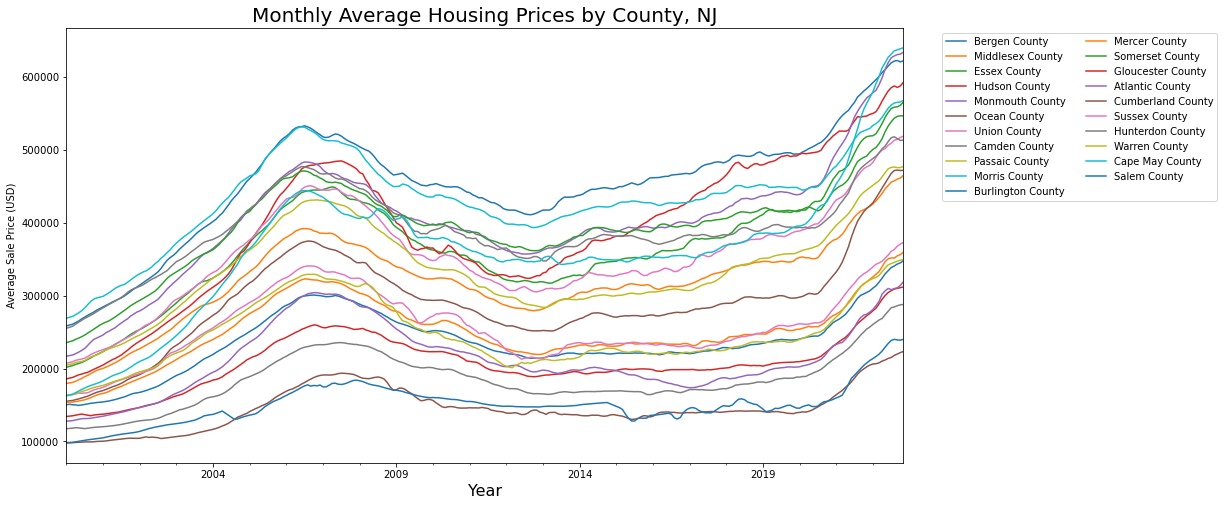

In [10]:
#EDA and Visualization

for county in dfm.RegionName.unique():
    temp_df = dfm[dfm.RegionName == county]
    temp_df['MeanValue'].plot(figsize = (15,8), label=county)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices by County, NJ', fontsize = 20);

In [13]:
# SARIMA models on all NJ County 
county_dfs = []
county_list = dfm.RegionName.unique()
for county in county_list:
    county_dfs.append(pd.DataFrame(dfm[dfm['RegionName']==county][['MeanValue']].copy()))
    
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    

In [14]:
#Run SARIMA
start=time.time()
ans = []

for df, name in zip(county_dfs, county_list):
    for p1 in pdq:
        for p2 in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = p1,
                                                seasonal_order = p2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, p1, p2, output.aic])
                print('Result for {}'.format(name) + ' ARIMAX {} x {}12 : AIC Calculated = {}'.format(p1, p2, output.aic))
            except:
                continue

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44042D+01    |proj g|=  5.50670D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   5.507D-09   1.440D+01
  F =   14.404151435492908     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Bergen County ARIMAX (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7924.2832895210995
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2    

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     38      1     0     0   8.033D-06   1.104D+01
  F =   11.035328250477914     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Bergen County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6075.4305377628525
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03288D+01    |proj g|=  1.05139D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluatio

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  1.88627D+01    |proj g|=  4.39938D+00

At iterate   10    f=  1.40670D+01    |proj g|=  9.15455D-02

At iterate   15    f=  1.39449D+01    |proj g|=  9.90315D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     24      1     0     0   4.765D-05   1.394D+01
  F =   13.944731940219668     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7675.602567120817
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   20    f=  1.42931D+02    |proj g|=  2.37068D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     26      1     0     0   1.356D-04   1.429D+02
  F =   142.93052577554812     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 78615.78917655147
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41906D+03    |proj g|=  2.70902D+01

At iterate    5    f=  1.54287D+01

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.90025D+02    |proj g|=  1.45913D+01
  ys=-4.479E+03  -gs= 5.042E+01 BFGS update SKIPPED

At iterate    5    f=  1.37799D+02    |proj g|=  9.18914D+00

At iterate   10    f=  1.37643D+02    |proj g|=  1.18246D+02

At iterate   15    f=  1.28043D+02    |proj g|=  6.73114D+02

At iterate   20    f=  5.46552D+01    |proj g|=  7.12483D+01

At iterate   25    f=  3.39097D+01    |proj g|=  1.51869D+01

At iterate   30    f=  2.05458D+01    |proj g|=  2.57276D+00

At iterate   35    f=  1.64773D+01    |proj g|=  1.71387D-02

At iterate   40    f=  1.63007D+01    |proj g|=  6.88040D-01

At iterate   45    f=  1.58040D+01    |proj g|=  2.30826D+00

At iterate   50    f=  1.56128D+01    |proj g|=  4.63942D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22961D+03    |proj g|=  2.54436D+02

At iterate    5    f=  1.03852D+03    |proj g|=  4.69133D+01

At iterate   10    f=  1.03468D+03    |proj g|=  1.22587D+02
  ys=-1.344E+02  -gs= 4.144E+01 BFGS update SKIPPED

At iterate   15    f=  1.50916D+01    |proj g|=  9.84498D+00

At iterate   20    f=  1.44006D+01    |proj g|=  7.63639D-01

At iterate   25    f=  1.41185D+01    |proj g|=  1.02315D-01

At iterate   30    f=  1.41133D+01    |proj g|=  3.67552D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  1.03542D+01    |proj g|=  7.99928D-02

At iterate   10    f=  1.03398D+01    |proj g|=  2.58725D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     36      1     0     0   2.587D-05   1.034D+01
  F =   10.339828034562613     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5692.9054190094375
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.87682D+0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  5.29151D+01    |proj g|=  4.02082D+00

At iterate   10    f=  1.62692D+01    |proj g|=  1.01077D+01

At iterate   15    f=  1.40433D+01    |proj g|=  3.36516D-01

At iterate   20    f=  1.40239D+01    |proj g|=  4.57474D-02

At iterate   25    f=  1.40232D+01    |proj g|=  1.16709D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     48      1     0     0   3.848D-05   1.402D+01
  F =   14.023217643887195     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7720.769704137957
RUNNING THE L-BF

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.78089D+00    |proj g|=  7.37818D-04

At iterate    5    f=  8.78077D+00    |proj g|=  1.41805D-02

At iterate   10    f=  8.76971D+00    |proj g|=  1.40145D-01

At iterate   15    f=  8.76191D+00    |proj g|=  1.58806D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     22      1     0     0   1.588D-07   8.762D+00
  F =   8.7619079106069897     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result f

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.39866D+00    |proj g|=  7.17353D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   2.533D-05   8.399D+00
  F =   8.3986610635737549     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4625.263584965565
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13371D+00    |proj g|=  2.33776D+00

At iterate    5    f=  8.99534D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  8.57095D+00    |proj g|=  5.95126D-03

At iterate   15    f=  8.56649D+00    |proj g|=  7.27733D-02

At iterate   20    f=  8.47114D+00    |proj g|=  1.11468D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     28      1     0     0   9.647D-05   8.467D+00
  F =   8.4671966497134967     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4662.958157342423
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.16023D+00    |proj g|=  7.36378D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   7.364D-05   8.160D+00
  F =   8.1602342822453622     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4494.128855234949
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16033D+01    |proj g|=  1.12832D+01

At iterate    5    f=  8.68485D+00

 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Result for Bergen County ARIMAX (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4730.5092051052325
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25719D+00    |proj g|=  3.99066D+00

At iterate    5    f=  8.57078D+00    |proj g|=  1.73787D-02

At iterate   10    f=  8.56966D+00    |proj g|=  1.87061D-04

At iterate   15    f=  8.56966D+00    |proj g|=  2.61412D-03

At iterate   20    f=  8.56919D+00    |proj g|=  3.10549D-02

At iterate   25    f=  8.53092D+00    |proj g|=  8.29240D-02

At iterate   30    f=  8.48952D+00    |proj g|=  1.65284D-01

At iterate   35    f=  8.46710D+00    |proj g|=  1.10794D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at f

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Bergen County ARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4544.050584505747
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.40709D+00    |proj g|=  2.96252D+00

At iterate    5    f=  8.15594D+00    |proj g|=  1.39622D-02

At iterate   10    f=  8.15517D+00    |proj g|=  2.79202D-04

At iterate   15    f=  8.15517D+00    |proj g|=  2.36495D-03

At iterate   20    f=  8.15485D+00    |proj g|=  3.22673D-02

At iterate   25    f=  8.14768D+00    |proj g|=  7.46383D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

Result for Bergen County ARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4820.292210116344
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.84196D+00    |proj g|=  6.98527D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   6.983D-04   8.842D+00
  F =   8.8419628499163867     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4867.079567454013


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate   15    f=  1.15247D+01    |proj g|=  8.25637D-02

At iterate   20    f=  1.15125D+01    |proj g|=  5.78677D-02

At iterate   25    f=  1.13948D+01    |proj g|=  1.29102D+00

At iterate   30    f=  8.97716D+00    |proj g|=  3.22859D+00

At iterate   35    f=  8.45926D+00    |proj g|=  1.60752D-02

At iterate   40    f=  8.45919D+00    |proj g|=  2.77947D-02

At iterate   45    f=  8.45879D+00    |proj g|=  2.43239D-03


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr


At iterate   50    f=  8.45839D+00    |proj g|=  2.45410D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     87      1     0     0   2.454D-02   8.458D+00
  F =   8.4583877276877182     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Result for Bergen County ARIMAX (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4658.113250228245
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.85816D+00    |proj g|=  7.57134D-01

At iterate    5    f=  8.82195D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.51817D+00    |proj g|=  2.95368D+00

At iterate   10    f=  8.43170D+00    |proj g|=  2.65727D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   4.076D-06   8.432D+00
  F =   8.4316969327307447     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Bergen County ARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4643.4333130019095
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40514D+0

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueW


At iterate   10    f=  8.92967D+00    |proj g|=  1.48516D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     26      1     0     0   1.485D-02   8.930D+00
  F =   8.9296741719672976     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4917.320794582014
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05797D+01    |proj g|=  1.30492D+01

At iterate    5    f=  9.21893D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   8.027D-05   8.710D+00
  F =   8.7102351366849931     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4796.6293251767465
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.18146D+01    |proj g|=  3.18473D+01

At iterate    5    f=  1.57046D+01    |proj g|=  2.02751D+01

At iterate   10    f=  1.35233D+0

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  8.96994D+00    |proj g|=  2.11087D+01

At iterate   10    f=  8.71775D+00    |proj g|=  1.55007D-01

At iterate   15    f=  8.71087D+00    |proj g|=  5.42222D+00

At iterate   20    f=  8.69658D+00    |proj g|=  2.19502D+00

At iterate   25    f=  8.61899D+00    |proj g|=  1.73368D+01

At iterate   30    f=  8.57728D+00    |proj g|=  1.89367D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     50      1     0     0   5.587D-04   8.577D+00
  F =   8.5772808550798647     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (1, 0, 1) x (1, 0, 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  1.01387D+01    |proj g|=  1.24745D-01

At iterate   10    f=  1.01376D+01    |proj g|=  1.43283D+00

At iterate   15    f=  9.94522D+00    |proj g|=  2.40710D+01

At iterate   20    f=  8.85488D+00    |proj g|=  6.48475D+01

At iterate   25    f=  8.65748D+00    |proj g|=  1.15503D+00

At iterate   30    f=  8.57785D+00    |proj g|=  4.16247D+00

At iterate   35    f=  8.52200D+00    |proj g|=  5.82290D-02

At iterate   40    f=  8.52087D+00    |proj g|=  3.68407D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     53      1     0     0   3.684D-04   8.521D+00
  F =   8.52086600692

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


At iterate    5    f=  8.39116D+00    |proj g|=  4.96743D-01

At iterate   10    f=  8.25332D+00    |proj g|=  5.42662D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   4.230D-05   8.253D+00
  F =   8.2531298422061354     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4547.221413213375
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09872D+01 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  1.18037D+01    |proj g|=  1.02616D+01

At iterate   10    f=  9.51148D+00    |proj g|=  1.29085D+00

At iterate   15    f=  9.47623D+00    |proj g|=  4.57151D-01

At iterate   20    f=  9.30593D+00    |proj g|=  8.14875D-01

At iterate   25    f=  8.86746D+00    |proj g|=  6.11879D+00

At iterate   30    f=  8.79573D+00    |proj g|=  5.14443D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     50      1     0     0   3.755D-04   8.796D+00
  F =   8.7957331538671202     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (1, 0, 1) x (1, 1, 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  8.08194D+00    |proj g|=  1.87895D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8      9      1     0     0   7.815D-06   8.082D+00
  F =   8.0819388416866804     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Bergen County ARIMAX (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4451.066362927674
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.44558D+00    |proj g|=  1.02148D-05

           * * *

Tit   = total nu

 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  8.01529D+00    |proj g|=  5.82615D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   5.826D-05   8.015D+00
  F =   8.0152870923030921     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4414.407900766701
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36553D+00    |proj g|=  7.24426D-01

At iterate    5    f=  8.07999D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  8.08160D+00    |proj g|=  1.73812D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   2.403D-05   8.082D+00
  F =   8.0816036654020049     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4452.882015971103
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.98707D+00    |proj g|=  2.72984D-01

At iterate    5    f=  7.93463D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   1.392D-04   7.934D+00
  F =   7.9341581322144368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4371.78697271794
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41766D+00    |proj g|=  5.24238D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   4.015D-06   8.414D+00
  F =   8.4143961275908712     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Bergen County ARIMAX (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4633.917870174979
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.00263D+00    |proj g|=  5.73157D-01

At iterate    5    f=  7.98006D+00    |proj g|=  1.21986D-03

           * * *

Tit   = total nu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Bergen County ARIMAX (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4437.824847406
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.98720D+00    |proj g|=  2.68579D-01

At iterate    5    f=  7.93520D+00    |proj g|=  1.42358D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   1.424D-04   7.935D+00
  F =   7.9351987962092077     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (1, 1,

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  7.90316D+00    |proj g|=  4.57387D-02

At iterate   10    f=  7.90307D+00    |proj g|=  2.03891D-04

At iterate   15    f=  7.90306D+00    |proj g|=  1.22891D-03

At iterate   20    f=  7.90297D+00    |proj g|=  1.70119D-02

At iterate   25    f=  7.88316D+00    |proj g|=  7.88999D-02

At iterate   30    f=  7.88106D+00    |proj g|=  5.60490D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     36      1     0     0   3.412D-05   7.881D+00
  F =   7.8810625140986934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Bergen County ARIMAX (1, 1, 1) x (1, 1, 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  1.68016D+01    |proj g|=  1.06901D-02

At iterate   15    f=  1.61011D+01    |proj g|=  1.78914D-04

At iterate   20    f=  1.60759D+01    |proj g|=  4.13697D-04
  ys=-1.665E+02  -gs= 7.530E-01 BFGS update SKIPPED

At iterate   25    f=  1.05293D+01    |proj g|=  8.12167D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     27     52      1     1     0   5.056D-06   1.053D+01
  F =   10.529245800404254     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Middlesex County ARIMAX (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5795.08519022234
RUNNING THE L-BFGS-B COD

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate   15    f=  1.08486D+01    |proj g|=  2.13798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     26      1     0     0   1.218D-05   1.085D+01
  F =   10.848610819672189     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Middlesex County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5972.735950819704
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01790D+01    |proj g|=  9.51772D-06

           * * *

Tit   = total

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   15    f=  1.34782D+01    |proj g|=  2.37927D-01

At iterate   20    f=  1.34444D+01    |proj g|=  4.15421D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     24      1     0     0   4.153D-05   1.344D+01
  F =   13.444425986616029     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Middlesex County ARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7400.434292638816
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91545D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  1.38331D+01    |proj g|=  1.88763D-01

At iterate   10    f=  1.38280D+01    |proj g|=  7.95046D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     17      1     0     0   2.436D-06   1.383D+01
  F =   13.828035828305220     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Middlesex County ARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7611.419705567871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11048D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  6.70950D+01    |proj g|=  3.28719D+01

At iterate   10    f=  6.70595D+01    |proj g|=  2.91845D+01

At iterate   15    f=  6.43150D+01    |proj g|=  5.48302D+02

At iterate   20    f=  2.73013D+01    |proj g|=  1.28864D+01

At iterate   25    f=  2.38858D+01    |proj g|=  4.95361D+00

At iterate   30    f=  1.49387D+01    |proj g|=  2.95968D-01

At iterate   35    f=  1.49305D+01    |proj g|=  2.41693D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     65      2     1     0   6.759D-05   1.493D+01
  F =   14.930537246968974     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  5.11824D+02    |proj g|=  3.94972D+01

At iterate   10    f=  1.44561D+01    |proj g|=  9.17023D+00

At iterate   15    f=  1.37996D+01    |proj g|=  6.93095D-01

At iterate   20    f=  1.37368D+01    |proj g|=  1.34146D-01

At iterate   25    f=  1.37337D+01    |proj g|=  3.84557D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     38      1     0     0   1.170D-05   1.373D+01
  F =   13.733688163584523     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Middlesex County ARIMAX (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7561.528489971488
RUNNING THE L

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.01712D+01    |proj g|=  5.81976D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     19      1     0     0   3.125D-05   1.016D+01
  F =   10.164318170128936     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Middlesex County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5596.374993570915
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74895D+02    |proj g|=  5.55579D+01

At iterate    5    f=  7.39158D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr

Result for Middlesex County ARIMAX (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4733.881353195844
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21449D+00    |proj g|=  1.11826D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      8      1     0     0   4.834D-05   8.208D+00
  F =   8.2080272380268990     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Middlesex County ARIMAX (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4518.4149809

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Middlesex County ARIMAX (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4695.689481287356
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.24402D+00    |proj g|=  4.63576D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.636D-06   8.244D+00
  F =   8.2440175930455553     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Middlesex County ARIMAX (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4538.2096761

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   25    f=  8.23836D+00    |proj g|=  1.91269D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     30      1     0     0   6.806D-06   8.238D+00
  F =   8.2379107183213343     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Middlesex County ARIMAX (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4536.850895076734
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11100D+01    |proj g|=  1.73974D+01

At iterate    5    f=  8.37523D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   1.278D-04   7.927D+00
  F =   7.9266970551886500     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Middlesex County ARIMAX (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4365.6833803537575
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05425D+01    |proj g|=  7.55334D+00

At iterate    5    f=  8.50508D+00    |proj g|=  1.67168D-01

At iterate   10    f=  8.48924

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Middlesex County ARIMAX (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4625.443293981245
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87633D+00    |proj g|=  2.64251D+00

At iterate    5    f=  8.38246D+00    |proj g|=  2.05758D-02

At iterate   10    f=  8.38100D+00    |proj g|=  2.13536D-02

At iterate   15    f=  8.38086D+00    |proj g|=  4.14220D-04

At iterate   20    f=  8.38079D+00    |proj g|=  1.24320D-02

At iterate   25    f=  8.37235D+00    |proj g|=  1.34762D-01

At iterate   30    f=  8.24149D+00    |proj g|=  2.47274D-01

At iterate   35    f=  8.22430D+00    |proj g|=  2.32813D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  7.93227D+00    |proj g|=  5.95675D-02

At iterate   10    f=  7.92451D+00    |proj g|=  1.67731D-02

At iterate   15    f=  7.92442D+00    |proj g|=  1.44798D-04

At iterate   20    f=  7.92441D+00    |proj g|=  3.74467D-03

At iterate   25    f=  7.92342D+00    |proj g|=  4.31324D-02

At iterate   30    f=  7.90639D+00    |proj g|=  2.99631D-02

At iterate   35    f=  7.90544D+00    |proj g|=  1.62767D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     39      1     0     0   9.122D-06   7.905D+00
  F =   7.9054403938889699     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.76022D+00    |proj g|=  1.62192D+00

At iterate    5    f=  8.75160D+00    |proj g|=  6.42109D+00

At iterate   10    f=  8.69184D+00    |proj g|=  6.02764D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   1.780D-04   8.692D+00
  F =   8.6918369858385169     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Middlesex County ARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : AIC C


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23041D+01    |proj g|=  4.22053D+00

At iterate    5    f=  1.21044D+01    |proj g|=  3.49942D+00

At iterate   10    f=  1.08669D+01    |proj g|=  1.52529D+00

At iterate   15    f=  1.07814D+01    |proj g|=  1.00807D-02

At iterate   20    f=  1.07814D+01    |proj g|=  3.82921D-02

At iterate   25    f=  1.07649D+01    |proj g|=  7.91684D-01

At iterate   30    f=  9.96032D+00    |proj g|=  3.34154D+00

At iterate   35    f=  8.42111D+00    |proj g|=  4.33896D+00

At iterate   40    f=  8.27099D+00    |proj g|=  2.10967D-02

At iterate   45    f=  8.26725D+00    |proj g|=  4.62493D-02

At iterate   50    f=  8.26500D+00    |proj g|=  9.89564D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr

Result for Middlesex County ARIMAX (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4709.656699944867
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15056D+01    |proj g|=  1.02395D+02

At iterate    5    f=  1.01779D+01    |proj g|=  1.15962D-01

At iterate   10    f=  1.01001D+01    |proj g|=  3.49284D+00
  ys=-2.515E-01  -gs= 4.213E-01 BFGS update SKIPPED

At iterate   15    f=  8.58182D+00    |proj g|=  2.76288D+00

At iterate   20    f=  8.58029D+00    |proj g|=  3.48800D+00

At iterate   25    f=  8.56790D+00    |proj g|=  1.00949D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     89      2     1     0   8.884D-04   8.568D+00
  F =   8.5679025604851127     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Result for Middlesex County ARIMAX (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4720.346408266812
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.70379D+00    |proj g|=  1.01909D+00

At iterate    5    f=  8.35301D+00    |proj g|=  3.32450D+00

At iterate   10    f=  8.24370D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54451D+01    |proj g|=  4.42418D+00

At iterate    5    f=  1.03807D+01    |proj g|=  1.02965D+00

At iterate   10    f=  9.82328D+00    |proj g|=  2.20271D-01

At iterate   15    f=  9.36370D+00    |proj g|=  1.51328D+00

At iterate   20    f=  8.50030D+00    |proj g|=  9.01398D+00

At iterate   25    f=  8.24664D+00    |proj g|=  1.40106D+00

At iterate   30    f=  8.24049D+00    |proj g|=  6.89009D-02

At iterate   35    f=  8.23995D+00    |proj g|=  9.70065D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     69      1     0     0   5.871D-04   8.240D+00
  F =   8.2399520566556674     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Middlesex County ARIMAX (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4539.9736311606175
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98373D+00    |proj g|=  4.07661D+00

At iterate    5    f=  8.75208D+00    |proj g|=  2.07249D+00

           * * *

Tit   = tota

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  8.47379D+00    |proj g|=  5.49615D-01

At iterate   10    f=  8.47263D+00    |proj g|=  1.16605D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     50      2     0     0   1.166D-04   8.473D+00
  F =   8.4726275638708728     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Result for Middlesex County ARIMAX (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4665.94516012898
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35031D+01    |proj g|=  1.22084D+01

At iterate    5    f=  1.15404D+01    |proj g|=  8.99216D+00

At iterate   10    f=  1.06040D+01    |proj g|=  4.52747D-01

At iterate   15    f=  1.02999D+01    |proj g|=  7.92118D-02

At iterate   20    f=  1.02907D+01    |proj g|=  4.47162D-03

At iterate   25    f=  1.02907D+01    |proj g|=  7.64256D-03

At iterate   30    f=  1.02879D+01    |proj g|=  8.82709D-02

At iterate   35    f=  1.00356D+01    |proj g|=  2.23453D+00

At iterate   40    f=  8.32602D+00    |proj g|=  1.23480D+00


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   45    f=  8.01003D+00    |proj g|=  6.72043D-01

At iterate   50    f=  7.95754D+00    |proj g|=  1.90387D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     66      1     0     0   1.904D-01   7.958D+00
  F =   7.9575391807843632     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Result for Middlesex County ARIMAX (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4384.6465494314
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24151D+0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   25    f=  8.40535D+00    |proj g|=  1.63602D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     48      1     0     0   1.636D-02   8.405D+00
  F =   8.4053470544755839     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Middlesex County ARIMAX (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4630.940879961571
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20345D+01    |proj g|=  1.01300D+02

At iterate    5    f=  1.00630D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  8.01088D+00    |proj g|=  4.91258D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   8.137D-05   8.011D+00
  F =   8.0108573299643862     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Middlesex County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4413.9715314804125
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82046D+01    |proj g|=  1.52174D+01

At iterate    5    f=  1.05929

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  9.36107D+00    |proj g|=  1.26749D-01

At iterate   15    f=  9.29999D+00    |proj g|=  8.31656D-01

At iterate   20    f=  9.10651D+00    |proj g|=  6.82306D+00

At iterate   25    f=  8.17125D+00    |proj g|=  9.60396D-01

At iterate   30    f=  8.02396D+00    |proj g|=  5.43865D-01

At iterate   35    f=  7.95639D+00    |proj g|=  1.01788D-01

At iterate   40    f=  7.95596D+00    |proj g|=  1.16145D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     64      1     0     0   1.252D-04   7.956D+00
  F =   7.9559590793424118     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   1.293D-05   8.124D+00
  F =   8.1235715376341773     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Middlesex County ARIMAX (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4471.964345698798
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.72792D+00    |proj g|=  3.51863D-01

At iterate    5    f=  7.69751D+00    |proj g|=  1.01915D-04

           * * *

Tit   = total

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Middlesex County ARIMAX (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4312.502412683121
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15537D+00    |proj g|=  1.66510D+00

At iterate    5    f=  7.82999D+00    |proj g|=  1.30367D-02

At iterate   10    f=  7.82977D+00    |proj g|=  5.26899D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   3.550D-05   7.830D+00
  F =   7.8297653774198199     

CONVERGENCE: REL_REDUCTION_OF_F

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.66273D+00    |proj g|=  7.40809D-02

At iterate   10    f=  7.66165D+00    |proj g|=  1.42747D-04

At iterate   15    f=  7.66164D+00    |proj g|=  4.67558D-03

At iterate   20    f=  7.66111D+00    |proj g|=  4.92736D-02

At iterate   25    f=  7.65262D+00    |proj g|=  8.72106D-02

At iterate   30    f=  7.65120D+00    |proj g|=  2.95664D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     34      1     0     0   2.957D-05   7.651D+00
  F =   7.6512010729267903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Middlesex County ARIMAX (1, 1, 0) x (1, 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.08778D+00    |proj g|=  7.46798D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   7.468D-06   8.088D+00
  F =   8.0877787601790594     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Middlesex County ARIMAX (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4454.2783180984825
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.69348D+00    |proj g|=  3.44742D-01

At iterate    5    f=  7.65493

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Result for Middlesex County ARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4218.207482358986
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.03102D+00    |proj g|=  5.98989D-01

At iterate    5    f=  7.82947D+00    |proj g|=  3.94349D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   2.829D-05   7.829D+00
  F =   7.8294646364605924     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Middlesex County ARIM

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70825D+00    |proj g|=  2.01509D-01

At iterate    5    f=  7.66724D+00    |proj g|=  1.53039D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   1.314D-04   7.667D+00
  F =   7.6672353205602120     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Middlesex County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4224.979426308117
RUNNING THE L-BFGS-B CODE

     

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.63306D+00    |proj g|=  4.33096D-02

At iterate   10    f=  7.63030D+00    |proj g|=  3.43314D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   1.424D-04   7.630D+00
  F =   7.6302967977782332     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Middlesex County ARIMAX (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4206.663238778028
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42062D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.33234D+01    |proj g|=  2.09190D-01

At iterate   10    f=  1.32815D+01    |proj g|=  4.39824D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     17      1     0     0   1.745D-06   1.328D+01
  F =   13.281480602241968     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Essex County ARIMAX (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7308.814331233083
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12200D+01 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   8.191D-04   1.115D+01
  F =   11.150734819894215     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Essex County ARIMAX (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6136.904150941818
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.85468D+02    |proj g|=  1.95585D+02

At iterate    5    f=  5.64146D+02    |proj g|=  2.32044D+02

At iterate   10    f=  1.58314D+01 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03106D+01    |proj g|=  1.06436D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   1.063D-05   1.031D+01
  F =   10.310569344194850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Essex County ARIMAX (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5674.813139307167
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.31049D+01    |proj g|=  4.41223D-02

At iterate   10    f=  1.31003D+01    |proj g|=  2.12380D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     29      1     0     0   2.567D-06   1.310D+01
  F =   13.100194193151143     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Essex County ARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7211.106806233129
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12963D+01 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.22957D+02    |proj g|=  5.62758D+00

At iterate    5    f=  9.47475D+01    |proj g|=  5.53839D+00

At iterate   10    f=  9.37605D+01    |proj g|=  2.12003D+02

At iterate   15    f=  7.22310D+01    |proj g|=  2.59453D+02

At iterate   20    f=  3.28791D+01    |proj g|=  2.12845D+01

At iterate   25    f=  1.55810D+01    |proj g|=  4.42912D-01

At iterate   30    f=  1.53854D+01    |proj g|=  5.62255D-02

At iterate   35    f=  1.53835D+01    |proj g|=  8.57906D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  5.52766D+02    |proj g|=  3.08790D+02

At iterate   10    f=  1.57849D+01    |proj g|=  7.66843D+00

At iterate   15    f=  1.35574D+01    |proj g|=  5.98786D-01

At iterate   20    f=  1.32342D+01    |proj g|=  1.89988D-01

At iterate   25    f=  1.30711D+01    |proj g|=  1.53490D-01

At iterate   30    f=  1.30636D+01    |proj g|=  2.58965D-02

At iterate   35    f=  1.30621D+01    |proj g|=  1.22300D-03

At iterate   40    f=  1.30620D+01    |proj g|=  2.50608D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     67      1     0     0   2.506D-06   1.306D+01
  F =   13.0620499630

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


  ys=-1.461E-02  -gs= 4.172E-03 BFGS update SKIPPED

At iterate    5    f=  1.03491D+01    |proj g|=  1.46958D-01

At iterate   10    f=  1.03377D+01    |proj g|=  2.70970D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     41      1     1     0   9.963D-05   1.034D+01
  F =   10.337714997094512     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Result for Essex County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5691.743248401982
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.85719D+02    |proj g|=  8.24329D+01

At iterate    5    f=  3.98868D+01    |proj g|=  5.81147D+00

At iterate   10    f=  3.75758D+01    |proj g|=  6.13114D+00

At iterate   15    f=  2.79112D+01    |proj g|=  1.81786D+01

At iterate   20    f=  1.42235D+01    |proj g|=  8.07889D-01

At iterate   25    f=  1.35044D+01    |proj g|=  2.92478D-02

At iterate   30    f=  1.34971D+01    |proj g|=  4.49470D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projecte

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Essex County ARIMAX (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4878.368276223643
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43808D+00    |proj g|=  2.60659D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   5.187D-05   8.438D+00
  F =   8.4379446088452443     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Essex County ARIMAX (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4644.869534864884
RU

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.44559D+00    |proj g|=  4.62261D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.623D-06   8.446D+00
  F =   8.4455935080248938     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Essex County ARIMAX (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4649.076429413692
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.10176D+00    |proj g|=  4.78370D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   1.794D-04   9.092D+00
  F =   9.0924072121695900     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Essex County ARIMAX (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5004.823966693274
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.16742D+00    |proj g|=  3.32132D-04

At iterate   10    f=  8.16742D+00    |proj g|=  2.92066D-03

At iterate   15    f=  8.16713D+00    |proj g|=  4.06260D-02

At iterate   20    f=  8.15960D+00    |proj g|=  1.32948D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     29      1     0     0   9.368D-06   8.157D+00
  F =   8.1569797864403224     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Essex County ARIMAX (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4492.338882542177
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.58863D+00    |proj g|=  6.86480D-02

At iterate   10    f=  8.58662D+00    |proj g|=  1.34850D-03

At iterate   15    f=  8.58661D+00    |proj g|=  9.84903D-04

At iterate   20    f=  8.58651D+00    |proj g|=  1.15546D-02

At iterate   25    f=  8.58223D+00    |proj g|=  9.58341D-03

At iterate   30    f=  8.54225D+00    |proj g|=  3.04697D-01

At iterate   35    f=  8.47776D+00    |proj g|=  1.21960D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     50      1     0     0   4.551D-06   8.478D+00
  F =   8.4776307267343309     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12300D+00    |proj g|=  1.03704D+01

At iterate    5    f=  8.15742D+00    |proj g|=  3.42937D-02

At iterate   10    f=  8.15719D+00    |proj g|=  4.27246D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     13      1     0     0   8.010D-05   8.157D+00
  F =   8.1571905278504886     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Essex County ARIMAX (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calcu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.28936D+00    |proj g|=  9.56184D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     17      1     0     0   9.562D-02   9.289D+00
  F =   9.2893558119339836     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Essex County ARIMAX (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5113.145696563691
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate   15    f=  1.13911D+01    |proj g|=  4.32116D-02

At iterate   20    f=  1.13894D+01    |proj g|=  2.70917D-03

At iterate   25    f=  1.11953D+01    |proj g|=  2.74798D-02
  ys=-1.115E+01  -gs= 6.363E-01 BFGS update SKIPPED

At iterate   30    f=  8.51595D+00    |proj g|=  2.76111D-01

At iterate   35    f=  8.51502D+00    |proj g|=  1.08408D-02

At iterate   40    f=  8.51480D+00    |proj g|=  1.44286D-01

At iterate   45    f=  8.51386D+00    |proj g|=  4.18276D-02

At iterate   50    f=  8.51307D+00    |proj g|=  2.52217D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     76      1     1

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueW

Result for Essex County ARIMAX (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4688.1911192945045
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.91866D+00    |proj g|=  7.37638D-01

At iterate    5    f=  8.88116D+00    |proj g|=  1.15628D+00

At iterate   10    f=  8.78483D+00    |proj g|=  9.07750D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     32      1     0     0   2.062D-04   8.785D+00
  F =   8.7845488376846692     

CONVERGENCE: REL_REDUCTION_OF_F_<=

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.53343D+00    |proj g|=  2.77050D+00

At iterate   10    f=  8.44715D+00    |proj g|=  3.19021D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   3.190D-05   8.447D+00
  F =   8.4471484136204662     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Essex County ARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4651.931627491256
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71739D+01 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   15    f=  8.88466D+00    |proj g|=  6.39998D+01

At iterate   20    f=  8.52765D+00    |proj g|=  1.91874D+00

At iterate   25    f=  8.52735D+00    |proj g|=  1.65859D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     43      1     0     0   1.659D-04   8.527D+00
  F =   8.5273461728256859     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Essex County ARIMAX (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4698.040395054128
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.37339D+01    |proj g|=  1.63104D+01

At iterate   10    f=  1.19833D+01    |proj g|=  1.53941D+00

At iterate   15    f=  1.09892D+01    |proj g|=  3.81812D-01

At iterate   20    f=  1.07912D+01    |proj g|=  1.35944D-02

At iterate   25    f=  1.07908D+01    |proj g|=  1.17566D-02

At iterate   30    f=  1.07842D+01    |proj g|=  1.98046D-01

At iterate   35    f=  1.02388D+01    |proj g|=  2.17503D+00

At iterate   40    f=  8.63342D+00    |proj g|=  5.75050D+00

At iterate   45    f=  8.27520D+00    |proj g|=  1.68861D-01

At iterate   50    f=  8.26937D+00    |proj g|=  4.08289D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37409D+01    |proj g|=  4.92133D+01

At iterate    5    f=  9.63213D+00    |proj g|=  1.70284D+00

At iterate   10    f=  9.29838D+00    |proj g|=  3.94627D-01

At iterate   15    f=  9.02709D+00    |proj g|=  7.40078D+00

At iterate   20    f=  8.67012D+00    |proj g|=  1.16934D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     32      1     0     0   1.842D-04   8.670D+00
  F =   8.6701090234617020     

CONVERG

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  1.01563D+01    |proj g|=  2.12841D-01

At iterate   10    f=  1.01547D+01    |proj g|=  3.25110D-01

At iterate   15    f=  9.82947D+00    |proj g|=  3.01851D+01

At iterate   20    f=  9.38624D+00    |proj g|=  1.24196D+00

At iterate   25    f=  9.23742D+00    |proj g|=  1.50043D+01

At iterate   30    f=  8.56349D+00    |proj g|=  1.76137D+01

At iterate   35    f=  8.53099D+00    |proj g|=  6.14073D-01

At iterate   40    f=  8.52716D+00    |proj g|=  1.02043D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     59      1     0     0   8.579D-04   8.527D+00
  F =   8.52688805933

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  8.27004D+00    |proj g|=  1.38733D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   6.017D-05   8.270D+00
  F =   8.2698117280473209     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Essex County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4556.396450426027
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14625D+01    |proj g|=  3.35383D+01

At iterate    5    f=  1.09289D+01 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  9.45376D+00    |proj g|=  1.38594D+00

At iterate   15    f=  9.41277D+00    |proj g|=  6.05952D-01

At iterate   20    f=  9.32052D+00    |proj g|=  1.18583D+00

At iterate   25    f=  8.83408D+00    |proj g|=  4.45629D+00

At iterate   30    f=  8.71675D+00    |proj g|=  6.74456D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     49      1     0     0   3.288D-04   8.717D+00
  F =   8.7167385765634418     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Essex County ARIMAX (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4804.206217109893
RUNNING THE L-BFG

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Essex County ARIMAX (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4678.498579767603
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89071D+00    |proj g|=  4.13616D+00

At iterate    5    f=  8.11881D+00    |proj g|=  6.76345D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8      9      1     0     0   1.608D-05   8.119D+00
  F =   8.1188067244897226     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Essex County ARIMAX (1, 1

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.11525D+00    |proj g|=  4.51069D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   4.237D-05   8.115D+00
  F =   8.1151067233170213     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Essex County ARIMAX (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4469.308697824362
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.45355D+00    |proj g|=  1.13737D+00

At iterate    5    f=  8.12191D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.00631D+00    |proj g|=  1.86768D-01

At iterate    5    f=  7.97820D+00    |proj g|=  1.49124D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   1.491D-04   7.978D+00
  F =   7.9781990836703054     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Essex County ARIMAX (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4394.009496018668
RUNNING THE L-BFGS-B CODE

         

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8      9      1     0     0   2.687D-05   8.072D+00
  F =   8.0720807053124961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Essex County ARIMAX (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4447.644387921873
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47973D+00    |proj g|=  3.40852D-01

At iterate    5    f=  8.46508D+00    |proj g|=  3.03966D-04

           * * *

Tit   = total num

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.01160D+00    |proj g|=  8.77643D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      8      1     0     0   8.776D-05   8.012D+00
  F =   8.0116045868421590     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Essex County ARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4414.382522763188
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.51375D+00    |proj g|=  1.19838D+00

At iterate    5    f=  8.11266D+00 

 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  8.07296D+00    |proj g|=  2.74696D-02

At iterate   10    f=  8.07206D+00    |proj g|=  7.83814D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     17      1     0     0   2.653D-05   8.072D+00
  F =   8.0720617451170984     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Essex County ARIMAX (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4449.633959814404
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.03675D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  7.97272D+00    |proj g|=  2.93462D-04

At iterate   15    f=  7.97268D+00    |proj g|=  7.23503D-03

At iterate   20    f=  7.96841D+00    |proj g|=  7.93325D-02

At iterate   25    f=  7.94662D+00    |proj g|=  2.02734D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   5.076D-07   7.947D+00
  F =   7.9466161709447496     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Essex County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4378.638894019612
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.93399D+00    |proj g|=  4.57795D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   1.525D-04   7.934D+00
  F =   7.9339707892830980     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Essex County ARIMAX (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4373.683934105704
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42783D+01    |proj g|=  7.28305D-09

           * * *

Tit   = total num

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  1.33504D+01    |proj g|=  2.64673D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     14      1     0     0   6.153D-06   1.335D+01
  F =   13.350360013043975     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hudson County ARIMAX (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7293.29656712201
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13803D+01    |proj g|=  1.27613D-06

           * * *

Tit   = total num

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fo


At iterate   20    f=  1.11887D+01    |proj g|=  6.34710D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     24      1     0     0   6.347D-06   1.119D+01
  F =   11.188685777654527     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hudson County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6115.022434599372
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05378D+01    |proj g|=  9.96145D-06

           * * *

Tit   = total nu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate   10    f=  1.65124D+01    |proj g|=  5.09202D-02

At iterate   15    f=  1.55285D+01    |proj g|=  9.92440D-03
  ys=-5.649E-01  -gs= 6.190E-01 BFGS update SKIPPED
  ys=-5.778E+00  -gs= 6.308E-01 BFGS update SKIPPED

At iterate   20    f=  1.06303D+01    |proj g|=  6.86536D-01

At iterate   25    f=  1.04942D+01    |proj g|=  8.24922D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     60      1     2     0   8.249D-06   1.049D+01
  F =   10.494218639622497     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hudson County ARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calcu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  1.38626D+01    |proj g|=  2.06640D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     33      1     0     0   9.379D-05   1.386D+01
  F =   13.862547922472537     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hudson County ARIMAX (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7572.951165670005
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71230D+02    |proj g|=  1.69358D+03

At iterate    5    f=  1.31667D+01

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/

Result for Hudson County ARIMAX (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 6239.588043870832
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61922D+02    |proj g|=  6.59551D+00

At iterate    5    f=  1.04453D+01    |proj g|=  2.72288D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     22      1     0     0   1.945D-05   1.044D+01
  F =   10.444872479858748     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hudson County ARIMAX (0,

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate   15    f=  1.31265D+01    |proj g|=  4.06892D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   2.327D-06   1.313D+01
  F =   13.126528430005633     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hudson County ARIMAX (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7175.084522783076
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08391D+01    |proj g|=  5.84090D-01

At iterate    5    f=  1.04994D+01

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/

Result for Hudson County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5738.376502922796
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.55004D+02    |proj g|=  1.20671D+02

At iterate    5    f=  3.62931D+01    |proj g|=  1.06282D+01


 This problem is unconstrained.



At iterate   10    f=  1.12211D+01    |proj g|=  2.24186D-01

At iterate   15    f=  1.12115D+01    |proj g|=  1.91589D-01

At iterate   20    f=  1.11709D+01    |proj g|=  2.78940D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     37      1     0     0   1.211D-05   1.117D+01
  F =   11.170343725102168     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hudson County ARIMAX (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 6107.007673905783
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/

Result for Hudson County ARIMAX (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4776.764136304213
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.09368D+00    |proj g|=  5.68949D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.689D-06   9.094D+00
  F =   9.0936839806483629     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hudson County ARIMAX (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4969.151453434006


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate   10    f=  8.73419D+00    |proj g|=  1.41608D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   1.416D-05   8.734D+00
  F =   8.7341877603832945     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hudson County ARIMAX (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4774.866517169279
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.34249D+00    |proj g|=  2.32901D-01

           * * *

Tit   = total nu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  8.57469D+00    |proj g|=  2.81398D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   3.195D-05   8.575D+00
  F =   8.5746909785864354     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hudson County ARIMAX (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4687.781274308194
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17920D+00    |proj g|=  1.21292D+00

At iterate    5    f=  8.98436D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74637D+00    |proj g|=  7.58269D-01

At iterate    5    f=  8.66056D+00    |proj g|=  1.34131D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   2.148D-05   8.661D+00
  F =   8.6605586389951217     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hudson County ARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4734.665016891337
RUNNING THE L-BFGS-B CODE

        

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  8.56450D+00    |proj g|=  4.00642D-02

At iterate   10    f=  8.56147D+00    |proj g|=  3.73623D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   3.736D-05   8.561D+00
  F =   8.5614690800761490     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hudson County ARIMAX (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4682.562117721577
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53970D+00

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and


At iterate   10    f=  9.25426D+00    |proj g|=  1.13506D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   1.135D-02   9.254D+00
  F =   9.2542584858444279     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hudson County ARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5058.825133271058
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22595D+00    |proj g|=  4.36430D-04

           * * *

Tit   = total nu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/t


At iterate    5    f=  9.12850D+00    |proj g|=  5.07098D-01

At iterate   10    f=  9.06543D+00    |proj g|=  3.16489D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     21      1     0     0   2.163D-02   9.065D+00
  F =   9.0653994625549004     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hudson County ARIMAX (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4955.7081065549755
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.17778D+0

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  1.11464D+01    |proj g|=  1.16589D+00

At iterate   10    f=  1.11440D+01    |proj g|=  2.30100D-02

At iterate   15    f=  1.11434D+01    |proj g|=  8.70013D-01

At iterate   20    f=  1.11178D+01    |proj g|=  9.61022D+00

At iterate   25    f=  1.09161D+01    |proj g|=  1.10393D+00

At iterate   30    f=  1.08595D+01    |proj g|=  1.86308D-03

At iterate   35    f=  1.08595D+01    |proj g|=  5.08938D-03

At iterate   40    f=  1.08593D+01    |proj g|=  1.94325D-01

At iterate   45    f=  1.08280D+01    |proj g|=  3.25031D-01
  ys=-1.770E+00  -gs= 6.337E-01 BFGS update SKIPPED

At iterate   50    f=  8.87019D+00    |proj g|=  5.08946D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/t

Result for Hudson County ARIMAX (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5085.631689540435
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19024D+00    |proj g|=  8.37525D-01

At iterate    5    f=  9.11500D+00    |proj g|=  4.57492D-02

At iterate   10    f=  9.11396D+00    |proj g|=  3.76895D-03

At iterate   15    f=  9.11390D+00    |proj g|=  3.21308D-01

At iterate   20    f=  9.10779D+00    |proj g|=  3.84497D+00

At iterate   25    f=  8.94802D+00    |proj g|=  1.61110D+01

At iterate   30    f=  8.91914D+00    |proj g|=  1.59248D-01

At iterate   35    f=  8.87615D+00    |proj g|=  1.87904D+00

At iterate   40    f=  8.86111D+00    |proj g|=  8.34929D-01

At iterate   45    f=  8.85966D+00    |proj g|=  1.07043D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fo


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     49     76      1     0     0   9.215D-03   8.860D+00
  F =   8.8596314485426717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hudson County ARIMAX (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4845.358770904299
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53355D+00    |proj g|=  3.63940D+00

At iterate    5    f=  9.10175D+00    |proj g|=  2.49670D-03

           * * *

Tit   = total nu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/t


At iterate   50    f=  8.66757D+00    |proj g|=  2.55426D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     90      1     1     0   2.554D-02   8.668D+00
  F =   8.6675712419242483     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Result for Hudson County ARIMAX (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4740.49389809064
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21716D+01    |proj g|=  1.37153D+01

At iterate    5    f=  9.19321D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


Result for Hudson County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4742.387796603167
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55905D+01    |proj g|=  6.56329D+01

At iterate    5    f=  9.56250D+00    |proj g|=  1.34035D+00

At iterate   10    f=  9.54498D+00    |proj g|=  2.00765D+00


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.



At iterate   15    f=  9.48205D+00    |proj g|=  1.00298D-01

At iterate   20    f=  9.44294D+00    |proj g|=  1.12751D+00

At iterate   25    f=  9.37130D+00    |proj g|=  1.11761D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     36      1     0     0   2.891D-04   9.371D+00
  F =   9.3712027100862265     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hudson County ARIMAX (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5126.6766797070795
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.00615D+00    |proj g|=  6.98783D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   6.988D-06   9.006D+00
  F =   9.0061512574377982     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hudson County ARIMAX (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4921.358586561038
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  8.71945D+00    |proj g|=  9.48133D-03

At iterate   10    f=  8.71917D+00    |proj g|=  2.15144D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   1.941D-05   8.719D+00
  F =   8.7191704611858647     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hudson County ARIMAX (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4768.667071807482
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.51128D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.



At iterate    5    f=  8.49815D+00    |proj g|=  8.05872D-02

At iterate   10    f=  8.49275D+00    |proj g|=  6.01251D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   6.012D-05   8.493D+00
  F =   8.4927487289326606     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hudson County ARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4645.040805997232
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.05182D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/

At iterate    5    f=  8.66394D+00    |proj g|=  3.82109D-02

At iterate   10    f=  8.66248D+00    |proj g|=  7.59748D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   7.597D-06   8.662D+00
  F =   8.6624760317003755     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hudson County ARIMAX (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4737.711913308405
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.97311D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.81449D+00    |proj g|=  6.77457D-01

At iterate    5    f=  8.66507D+00    |proj g|=  2.85679D-02

At iterate   10    f=  8.66249D+00    |proj g|=  2.02969D-03

At iterate   15    f=  8.66244D+00    |proj g|=  9.81199D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   7.607D-06   8.662D+00
  F =   8.6624350709783453     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hudson County ARIMAX (1, 1, 1) x (1, 0, 1,

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  8.49434D+00    |proj g|=  9.71334D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   6.185D-05   8.494D+00
  F =   8.4943379473261142     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hudson County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4645.908519240058
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.55408D+00    |proj g|=  8.89204D-01

At iterate    5    f=  8.46271D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Monmouth County ARIMAX (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7355.807151775665
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13419D+01    |proj g|=  1.27933D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.279D-06   1.134D+01
  F =   11.341855818306312     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Monmouth County ARIMAX (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6240.020700068

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

At iterate    5    f=  6.54199D+02    |proj g|=  3.24054D+02

At iterate   10    f=  1.15874D+01    |proj g|=  3.09500D+00

At iterate   15    f=  1.11284D+01    |proj g|=  3.56209D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     30      1     0     0   5.510D-06   1.112D+01
  F =   11.124621332098418     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Monmouth County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6124.541732654129
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.50134D+01    |proj g|=  3.61998D-01

At iterate   10    f=  1.41107D+01    |proj g|=  9.28835D-01

At iterate   15    f=  1.39012D+01    |proj g|=  1.30626D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   5.763D-05   1.390D+01
  F =   13.901185051125527     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Monmouth County ARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7651.65177811904
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency 


At iterate   15    f=  1.07239D+02    |proj g|=  4.72601D-02

At iterate   20    f=  1.06071D+02    |proj g|=  1.79266D-03
  ys=-3.134E-04  -gs= 2.993E-04 BFGS update SKIPPED

At iterate   25    f=  1.06043D+02    |proj g|=  1.65220D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     25     55      2     1     0   1.652D-04   1.060D+02
  F =   106.04317879702502     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Monmouth County ARIMAX (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 58327.74833836376
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.20705D+02    |proj g|=  6.37497D+00

At iterate   10    f=  1.17190D+02    |proj g|=  4.18586D+02

At iterate   15    f=  6.80701D+01    |proj g|=  8.41520D+01

At iterate   20    f=  3.28740D+01    |proj g|=  8.26254D+00

At iterate   25    f=  2.32213D+01    |proj g|=  1.70585D-01
  ys=-4.971E-07  -gs= 3.564E-07 BFGS update SKIPPED

At iterate   30    f=  2.32111D+01    |proj g|=  9.53562D-02
  ys=-4.072E-06  -gs= 5.496E-07 BFGS update SKIPPED

At iterate   35    f=  2.32109D+01    |proj g|=  1.61032D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.644E-09  -gs= 9.030E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     37    194      3     3     0   1.652D-01   2.321D+01
  F =   23.210899677469371     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Result for Monmouth County ARIMAX (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 12771.994822608154
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09615D+02    |proj g|=  9.88390D+02


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This pr


At iterate    5    f=  1.42575D+01    |proj g|=  3.70726D-03

At iterate   10    f=  1.42575D+01    |proj g|=  2.73381D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   2.734D-06   1.426D+01
  F =   14.257528490755034     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Monmouth County ARIMAX (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7847.6406699152685
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.30530D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


  ys=-3.599E-03  -gs= 6.440E-03 BFGS update SKIPPED

At iterate    5    f=  1.04604D+01    |proj g|=  3.36027D-01

At iterate   10    f=  1.04569D+01    |proj g|=  2.27573D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     20      1     1     0   2.276D-05   1.046D+01
  F =   10.456891372922298     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Monmouth County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5757.290255107264
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exa

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  1.12770D+02    |proj g|=  1.38395D+01

At iterate   10    f=  8.05942D+01    |proj g|=  4.18367D+00

At iterate   15    f=  2.21181D+01    |proj g|=  3.18930D-01

At iterate   20    f=  1.80092D+01    |proj g|=  5.39944D-02

At iterate   25    f=  1.76219D+01    |proj g|=  5.36583D-02

At iterate   30    f=  1.76105D+01    |proj g|=  4.25096D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     40      1     0     0   3.922D-05   1.761D+01
  F =   17.610500516568536     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Monmouth County ARIMAX (0, 0, 1) x (1, 1

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  8.89651D+00    |proj g|=  2.92046D-03

At iterate   15    f=  8.89590D+00    |proj g|=  3.75094D-02

At iterate   20    f=  8.87161D+00    |proj g|=  2.69462D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     27      1     0     0   1.747D-05   8.872D+00
  F =   8.8715564817451469     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Monmouth County ARIMAX (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4883.356064959831
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variabl

 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be u


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   4.193D-05   8.481D+00
  F =   8.4812007238001694     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Monmouth County ARIMAX (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4668.660398090094
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.85808D+00    |proj g|=  6.77502D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be u

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.51244D+00    |proj g|=  4.41833D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.418D-06   8.512D+00
  F =   8.5124449572075154     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Monmouth County ARIMAX (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4685.844726464134
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  8.67201D+00    |proj g|=  2.73993D-04

At iterate   15    f=  8.67199D+00    |proj g|=  6.43686D-03

At iterate   20    f=  8.66960D+00    |proj g|=  6.99907D-02

At iterate   25    f=  8.55461D+00    |proj g|=  3.79742D-01

At iterate   30    f=  8.52204D+00    |proj g|=  2.08901D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     37      1     0     0   1.812D-06   8.522D+00
  F =   8.5220396544456172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Monmouth County ARIMAX (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4693.12180994509
RUNNING THE L-B

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.65836D+00    |proj g|=  6.15249D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     10      1     0     0   4.687D-05   8.658D+00
  F =   8.6580514915411122     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Monmouth County ARIMAX (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4765.928320347612
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.40270D+00    |proj g|=  2.20336D+00

At iterate    5    f=  8.18279D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39733D+00    |proj g|=  2.46668D+00

At iterate    5    f=  8.67212D+00    |proj g|=  3.38976D-02

At iterate   10    f=  8.67142D+00    |proj g|=  1.81185D-04

At iterate   15    f=  8.67140D+00    |proj g|=  3.24246D-03

At iterate   20    f=  8.66801D+00    |proj g|=  5.38623D-02

At iterate   25    f=  8.54853D+00    |proj g|=  3.04339D-01

At iterate   30    f=  8.51872D+00    |proj g|=  8.80838D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Monmouth County ARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4554.809293697514
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98575D+00    |proj g|=  1.00298D+01

At iterate    5    f=  8.19301D+00    |proj g|=  1.05367D-01

At iterate   10    f=  8.18329D+00    |proj g|=  3.52979D-02

At iterate   15    f=  8.18247D+00    |proj g|=  1.10857D-04

At iterate   20    f=  8.18139D+00    |proj g|=  4.65796D-02

At iterate   25    f=  8.16391D+00    |proj g|=  1.18264D-01

At iterate   30    f=  8.15636D+00    |proj g|=  2.35828D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final proje

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37647D+00    |proj g|=  9.61060D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     17      1     0     0   9.611D-02   9.376D+00
  F =   9.3764655660151472     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Monmouth County ARIMAX (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5161.056061308331
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanj


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     50      1     0     0   8.495D-04   8.855D+00
  F =   8.8550005069019075     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Monmouth County ARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4876.250278796049
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92807D+00    |proj g|=  7.48269D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueW


At iterate   50    f=  8.54225D+00    |proj g|=  3.08288D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     75      1     0     0   3.083D-02   8.542D+00
  F =   8.5422545775242842     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Result for Monmouth County ARIMAX (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4704.240017638356
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.94717D+00    |proj g|=  6.38138D-01

At iterate    5    f=  8.89178D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  8.51076D+00    |proj g|=  7.34435D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   7.344D-06   8.511D+00
  F =   8.5107572718145548     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Monmouth County ARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4686.916499498006
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24263D+01    |proj g|=  8.88961D+00

At iterate    5    f=  1.13141D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Pos


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     51      2     0     0   2.351D-02   9.123D+00
  F =   9.1227136228484103     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Result for Monmouth County ARIMAX (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5023.4924925666255
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10746D+01    |proj g|=  1.50487D+01

At iterate    5    f=  1.09501D+01    |proj g|=  3.13659D-01

At iterate   10    f=  1.09460D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70980D+01    |proj g|=  2.08557D+01

At iterate    5    f=  1.36833D+01    |proj g|=  1.54975D+01

At iterate   10    f=  1.20329D+01    |proj g|=  8.56942D-01

At iterate   15    f=  1.12244D+01    |proj g|=  6.07781D-01

At iterate   20    f=  1.10219D+01    |proj g|=  2.27475D-02

At iterate   25    f=  1.10210D+01    |proj g|=  4.92608D-03

At iterate   30    f=  1.10008D+01    |proj g|=  6.34045D-02

At iterate   35    f=  1.05779D+01    |proj g|=  2.73034D+00

At iterate   40    f=  9.37920D+00    |proj g|=  3.08547D+00

At iterate   45    f=  8.37903D+00    |proj g|=  2.75809D+00

At iterate   50    f=  8.24140D+00    |proj g|=  2.51876D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45183D+01    |proj g|=  5.40879D+01

At iterate    5    f=  9.71928D+00    |proj g|=  1.53098D+00

At iterate   10    f=  9.41519D+00    |proj g|=  6.32283D-01

At iterate   15    f=  8.90530D+00    |proj g|=  2.86808D+01

At iterate   20    f=  8.66045D+00    |proj g|=  1.84963D+00

At iterate   25    f=  8.65869D+00    |proj g|=  4.09507D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     35      1     0     0   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  1.05234D+01    |proj g|=  1.32782D+00

At iterate   10    f=  1.05104D+01    |proj g|=  9.58687D-02

At iterate   15    f=  1.04564D+01    |proj g|=  8.19364D-01

At iterate   20    f=  1.02011D+01    |proj g|=  1.16209D+00

At iterate   25    f=  1.01854D+01    |proj g|=  1.22638D+00

At iterate   30    f=  9.69261D+00    |proj g|=  1.10698D+01

At iterate   35    f=  8.81887D+00    |proj g|=  7.07528D+00

At iterate   40    f=  8.79287D+00    |proj g|=  1.14305D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     60      1     0     0   7.824D-04   8.793D+00
  F =   8.79286866701

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  8.40103D+00    |proj g|=  5.64816D-01

At iterate   10    f=  8.27026D+00    |proj g|=  1.73983D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     15      1     0     0   7.801D-05   8.270D+00
  F =   8.2699706345526014     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Monmouth County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4556.483849003931
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79972D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  1.27596D+01    |proj g|=  6.57846D+00

At iterate   10    f=  9.77097D+00    |proj g|=  9.52973D-01

At iterate   15    f=  9.75707D+00    |proj g|=  5.11609D-01

At iterate   20    f=  9.32601D+00    |proj g|=  4.46636D+00

At iterate   25    f=  8.90904D+00    |proj g|=  5.49991D-01

At iterate   30    f=  8.90791D+00    |proj g|=  3.61263D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     45      1     0     0   7.098D-04   8.908D+00
  F =   8.9079088047136903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Monmouth County ARIMAX (1, 0, 1) x (1, 1

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding erro

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.01176D+00    |proj g|=  4.83625D-01

At iterate    5    f=  7.94701D+00    |proj g|=  1.59020D-04

At iterate   10    f=  7.94696D+00    |proj g|=  2.15546D-02

At iterate   15    f=  7.94278D+00    |proj g|=  1.50636D-01


 This problem is unconstrained.



At iterate   20    f=  7.94025D+00    |proj g|=  1.85767D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     38      1     0     0   1.858D-05   7.940D+00
  F =   7.9402546919730961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Monmouth County ARIMAX (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4373.140080585203
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.33285D+00    |proj g|=  6.97652D-01

At iterate    5    f=  8.03357D+


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.00096D+00    |proj g|=  4.70344D+00

At iterate    5    f=  8.04087D+00    |proj g|=  9.42073D-02

At iterate   10    f=  8.03106D+00    |proj g|=  1.62016D-02

At iterate   15    f=  8.03079D+00    |proj g|=  5.46375D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   5.464D-05   8.031D+00
  F =   8.0307937948621468     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result f

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


At iterate    5    f=  7.86543D+00    |proj g|=  3.66114D-04

At iterate   10    f=  7.86510D+00    |proj g|=  4.07097D-02

At iterate   15    f=  7.84444D+00    |proj g|=  2.31249D-01

At iterate   20    f=  7.83731D+00    |proj g|=  1.26231D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     26      1     0     0   1.262D-05   7.837D+00
  F =   7.8373092441552528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Monmouth County ARIMAX (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4316.520084285389


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.01009D+00    |proj g|=  4.46786D-01

At iterate    5    f=  7.86482D+00    |proj g|=  7.86802D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     13      1     0     0   1.711D-04   7.864D+00
  F =   7.8640059271132241     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Monmouth County ARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4333.203259912273
RUNNING THE L-BFGS-B CODE

      

 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be u


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      8      1     0     0   4.806D-06   8.374D+00
  F =   8.3737336913394920     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Monmouth County ARIMAX (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4611.553530236721
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00402D+01    |proj g|=  9.75910D+00

At iterate    5    f=  7.99808D+00    |proj g|=  8.87472D-02

At iterate   10    f=  7.99341D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.97420D+00    |proj g|=  4.81156D-01

At iterate    5    f=  7.90366D+00    |proj g|=  3.11824D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     12      1     0     0   1.059D-04   7.904D+00
  F =   7.9036599284950615     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Monmouth County ARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4355.012960672284
RUNNING THE L-BFGS-B CODE

      

 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  8.02784D+00    |proj g|=  6.62361D-02

At iterate   10    f=  8.02548D+00    |proj g|=  6.02944D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   2.242D-05   8.025D+00
  F =   8.0254833277622968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Monmouth County ARIMAX (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4422.0158302692635
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.77429D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.92408D+00    |proj g|=  2.44357D-01

At iterate    5    f=  7.86243D+00    |proj g|=  5.75477D-04

At iterate   10    f=  7.86242D+00    |proj g|=  2.80462D-03

At iterate   15    f=  7.86147D+00    |proj g|=  3.83974D-02

At iterate   20    f=  7.83867D+00    |proj g|=  1.29630D-01

At iterate   25    f=  7.83324D+00    |proj g|=  1.21729D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     41      1     0     0   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Result for Monmouth County ARIMAX (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4313.665524376507
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39736D+01    |proj g|=  9.05940D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   9.059D-09   1.397D+01
  F =   13.973646464566782     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Ocean County ARIMAX (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7687.50555551173


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  2.58197D+01    |proj g|=  1.98929D-01

At iterate   10    f=  1.70462D+01    |proj g|=  8.84150D-03

At iterate   15    f=  1.64123D+01    |proj g|=  1.34700D-04

At iterate   20    f=  1.63926D+01    |proj g|=  3.42360D-04
  ys=-6.337E+00  -gs= 8.256E-01 BFGS update SKIPPED

At iterate   25    f=  1.07522D+01    |proj g|=  1.61777D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     27     53      1     1     0   5.129D-06   1.075D+01
  F =   10.751709019300383     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Ocean County ARIMAX (0, 0, 0) x (0, 1, 1, 12)12 : 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate   10    f=  1.18285D+01    |proj g|=  7.29345D+00

At iterate   15    f=  1.16901D+01    |proj g|=  8.69298D+00

At iterate   20    f=  1.10823D+01    |proj g|=  5.34959D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     30      1     0     0   1.654D-05   1.108D+01
  F =   11.082347886724808     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Ocean County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6101.291337698644
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

At iterate    5    f=  3.63390D+01    |proj g|=  1.35891D+00

At iterate   10    f=  1.42233D+01    |proj g|=  2.62966D-02

At iterate   15    f=  1.38135D+01    |proj g|=  1.13101D+00

At iterate   20    f=  1.35376D+01    |proj g|=  2.42860D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     27      1     0     0   1.506D-05   1.354D+01
  F =   13.537609230807588     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Ocean County ARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7451.6850769441735
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13911D+01    |proj g|=  4.53997D-01

At iterate    5    f=  1.08945D+01    |proj g|=  4.36841D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     11      1     0     0   1.945D-05   1.089D+01
  F =   10.894491294037351     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Ocean County ARIMAX (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5995.970211720543
RUNNING THE L-BFGS-B CODE

         

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Ocean County ARIMAX (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7123.059755247201
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.31011D+02    |proj g|=  7.41310D+01

At iterate    5    f=  1.29357D+01    |proj g|=  1.24612D+00

At iterate   10    f=  1.28431D+01    |proj g|=  1.79496D-02

At iterate   15    f=  1.28414D+01    |proj g|=  2.31568D-03

At iterate   20    f=  1.28412D+01    |proj g|=  6.00762D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09256D+01    |proj g|=  4.66481D-01

At iterate    5    f=  1.03829D+01    |proj g|=  3.38619D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     15      1     0     0   2.447D-05   1.038D+01
  F =   10.382923501704294     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Ocean County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5716.607925937362
RUNNING THE L-BFGS-B CODE

         

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46949D+00    |proj g|=  2.89804D-01

At iterate    5    f=  8.40924D+00    |proj g|=  4.17046D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   4.170D-05   8.409D+00
  F =   8.4092374447044058     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Ocean County ARIMAX (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4629.080594587424
RUNNING THE L-BFGS-B CODE

         

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Ocean County ARIMAX (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4814.931316623668
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43981D+00    |proj g|=  4.19966D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.200D-06   8.440D+00
  F =   8.4398066220840651     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Ocean County ARIMAX (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4645.893642146236
RU

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   20    f=  8.54320D+00    |proj g|=  6.00733D-01

At iterate   25    f=  8.34948D+00    |proj g|=  1.47396D-02

At iterate   30    f=  8.34863D+00    |proj g|=  2.54979D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     40      1     0     0   7.843D-06   8.349D+00
  F =   8.3486334978808934     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Ocean County ARIMAX (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4597.748423834491
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

At iterate   15    f=  8.55361D+00    |proj g|=  6.50263D-02

At iterate   20    f=  8.52840D+00    |proj g|=  1.59568D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     21     39      1     0     0   2.132D-08   8.528D+00
  F =   8.5284033072154095     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Ocean County ARIMAX (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4694.621818968475
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.20611D+00  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  8.64821D+00    |proj g|=  6.06982D-02

At iterate   10    f=  8.64609D+00    |proj g|=  1.95117D-04

At iterate   15    f=  8.64607D+00    |proj g|=  8.07188D-03

At iterate   20    f=  8.64435D+00    |proj g|=  1.02494D-01

At iterate   25    f=  8.54122D+00    |proj g|=  6.40877D-01

At iterate   30    f=  8.50990D+00    |proj g|=  2.52393D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     41      1     0     0   4.178D-06   8.510D+00
  F =   8.5098956120477247     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Ocean County ARIMAX (0, 1, 1) x (1, 0, 0

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  8.63074D+00    |proj g|=  9.56086D-02

At iterate   10    f=  8.61311D+00    |proj g|=  6.70344D-03

At iterate   15    f=  8.61310D+00    |proj g|=  6.67564D-03

At iterate   20    f=  8.61181D+00    |proj g|=  1.03922D-01

At iterate   25    f=  8.49377D+00    |proj g|=  1.79651D+00

At iterate   30    f=  8.35108D+00    |proj g|=  1.80450D-01

At iterate   35    f=  8.34529D+00    |proj g|=  3.79551D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     48      1     0     0   1.840D-06   8.345D+00
  F =   8.3452860952963288     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  8.15159D+00    |proj g|=  8.59214D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     18      1     0     0   1.379D-04   8.152D+00
  F =   8.1515692829125577     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Ocean County ARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4489.363105601907
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.49816D+00    |proj g|=  4.68797D+00

At iterate    5    f=  8.20259D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  8.14706D+00    |proj g|=  7.83740D-02

At iterate   15    f=  8.14603D+00    |proj g|=  1.87826D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   1.878D-04   8.146D+00
  F =   8.1460291990879874     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Ocean County ARIMAX (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4488.316059498393
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29550D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

  ys=-2.676E+00  -gs= 8.100E-01 BFGS update SKIPPED

At iterate    5    f=  8.94905D+00    |proj g|=  1.21619D+01

At iterate   10    f=  8.88893D+00    |proj g|=  2.89842D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     35      1     1     0   1.419D-04   8.889D+00
  F =   8.8889302352678872     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Ocean County ARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4894.911629397338
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactl

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

Result for Ocean County ARIMAX (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4872.658212214048
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14367D+01    |proj g|=  1.96974D+00

At iterate    5    f=  1.13870D+01    |proj g|=  7.95525D-01

At iterate   10    f=  1.10972D+01    |proj g|=  1.10271D+00

At iterate   15    f=  1.10615D+01    |proj g|=  9.16479D-03

At iterate   20    f=  1.10614D+01    |proj g|=  9.37403D-03

At iterate   25    f=  1.10607D+01    |proj g|=  1.32832D-01

At iterate   30    f=  1.09481D+01    |proj g|=  2.10456D+00

At iterate   35    f=  9.26557D+00    |proj g|=  1.08768D+01

At iterate   40    f=  8.51908D+00    |proj g|=  3.22322D-02

At iterate   45    f=  8.48373D+00    |proj g|=  4.50684D-03

At iterate   50    f=  8.47669D+00    |proj g|=  4.18640D-02

           * * *

Tit   = total number of iterations
T

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr

Result for Ocean County ARIMAX (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4668.181921340725
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87208D+00    |proj g|=  6.60539D-01

At iterate    5    f=  8.82721D+00    |proj g|=  1.28313D+00

At iterate   10    f=  8.76525D+00    |proj g|=  1.73553D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     17      1     0     0   9.036D-05   8.765D+00
  F =   8.7652474353976970     

CONVERGENCE: REL_REDUCTION_OF_F_<=_

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.46683D+00    |proj g|=  2.16257D+00

At iterate   10    f=  8.43739D+00    |proj g|=  7.06901D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   7.069D-06   8.437D+00
  F =   8.4373921477818357     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Ocean County ARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4646.56568128001
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30915D+01  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   15    f=  1.06730D+01    |proj g|=  1.86930D+00

At iterate   20    f=  1.06677D+01    |proj g|=  1.53811D-01

At iterate   25    f=  1.06147D+01    |proj g|=  8.97335D+00

At iterate   30    f=  9.92624D+00    |proj g|=  5.71314D+01

At iterate   35    f=  8.51519D+00    |proj g|=  8.20584D+00

At iterate   40    f=  8.49342D+00    |proj g|=  1.27447D-03

At iterate   45    f=  8.49338D+00    |proj g|=  1.32262D-01

At iterate   50    f=  8.48793D+00    |proj g|=  1.60051D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     73      1     0     0   1.601D+00   8.488D+00
  F =   8.48792855963

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   30    f=  8.65883D+00    |proj g|=  4.91550D-01

At iterate   35    f=  8.64670D+00    |proj g|=  5.16441D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     37     43      1     0     0   3.360D-04   8.647D+00
  F =   8.6466982441978857     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Ocean County ARIMAX (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4761.684034308837
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23834D+01 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  1.06224D+01    |proj g|=  5.77729D-02

At iterate   15    f=  1.06046D+01    |proj g|=  3.32073D-01

At iterate   20    f=  1.05885D+01    |proj g|=  8.02640D-04

At iterate   25    f=  1.05884D+01    |proj g|=  1.51155D-02

At iterate   30    f=  1.05861D+01    |proj g|=  1.74133D-01

At iterate   35    f=  1.02954D+01    |proj g|=  1.65596D+00

At iterate   40    f=  8.37687D+00    |proj g|=  1.16580D+00

At iterate   45    f=  8.13738D+00    |proj g|=  1.52707D-01

At iterate   50    f=  8.12278D+00    |proj g|=  3.14397D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     64   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  9.30683D+00    |proj g|=  8.23601D-01

At iterate   10    f=  9.18800D+00    |proj g|=  7.67793D-01

At iterate   15    f=  8.60620D+00    |proj g|=  1.47507D+00

At iterate   20    f=  8.56221D+00    |proj g|=  2.01273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     31      1     0     0   2.013D-04   8.562D+00
  F =   8.5622145892702850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Ocean County ARIMAX (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4717.218024098656
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  1.06616D+01    |proj g|=  5.51960D+00

At iterate   15    f=  1.06379D+01    |proj g|=  1.46478D-01

At iterate   20    f=  1.05848D+01    |proj g|=  2.28236D-01

At iterate   25    f=  1.04575D+01    |proj g|=  3.94520D+00

At iterate   30    f=  8.73392D+00    |proj g|=  1.85624D+00

At iterate   35    f=  8.65220D+00    |proj g|=  1.01661D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     55      1     0     0   2.074D-04   8.652D+00
  F =   8.6521781991069879     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Ocean County ARIMAX (1, 0, 1) x (1, 0, 1

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


At iterate    5    f=  8.39228D+00    |proj g|=  3.86841D-01

At iterate   10    f=  8.16629D+00    |proj g|=  1.36834D+00

At iterate   15    f=  8.14992D+00    |proj g|=  2.76905D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     23      1     0     0   2.769D-04   8.150D+00
  F =   8.1499197325982333     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Ocean County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4490.455852929028


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59916D+01    |proj g|=  9.09887D+00

At iterate    5    f=  1.04940D+01    |proj g|=  4.94615D+00

At iterate   10    f=  9.93598D+00    |proj g|=  9.31558D-02

At iterate   15    f=  9.76406D+00    |proj g|=  1.84478D+00

At iterate   20    f=  9.01999D+00    |proj g|=  1.54125D+00

At iterate   25    f=  8.67753D+00    |proj g|=  6.80308D-01

At iterate   30    f=  8.67586D+00    |proj g|=  2.59143D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  8.57673D+00    |proj g|=  3.99112D-03

At iterate   10    f=  8.57669D+00    |proj g|=  3.40787D-03

At iterate   15    f=  8.57429D+00    |proj g|=  4.44678D-02

At iterate   20    f=  8.26243D+00    |proj g|=  1.20337D+00

At iterate   25    f=  7.84221D+00    |proj g|=  4.79277D-02

At iterate   30    f=  7.84164D+00    |proj g|=  3.60936D-02

At iterate   35    f=  7.83360D+00    |proj g|=  8.64859D-02

At iterate   40    f=  7.82996D+00    |proj g|=  3.77478D-02

At iterate   45    f=  7.82745D+00    |proj g|=  4.09111D-03

At iterate   50    f=  7.82563D+00    |proj g|=  8.31432D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeli


At iterate    5    f=  7.72290D+00    |proj g|=  1.17623D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   1.176D-04   7.723D+00
  F =   7.7228973492508883     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Ocean County ARIMAX (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4253.593542087989
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.06306D+00    |proj g|=  6.56669D-01

At iterate    5    f=  7.81696D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   2.994D-05   7.815D+00
  F =   7.8150370509540288     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Ocean County ARIMAX (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4306.270378024716
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70331D+00    |proj g|=  2.68633D-01

At iterate    5    f=  7.65841D+00    |proj g|=  1.88083D-04

At iterate   10    f=  7.65833D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.65838D+00    |proj g|=  3.48687D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.894D-04   7.658D+00
  F =   7.6580478823158540     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Ocean County ARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4219.92633527372
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.11213D+00    |proj g|=  1.09548D-01

           * * *

Tit   = total numb

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.26374D+00    |proj g|=  1.45243D-02

At iterate   10    f=  8.26333D+00    |proj g|=  6.36513D-04

At iterate   15    f=  8.26265D+00    |proj g|=  4.28486D-02

At iterate   20    f=  8.17464D+00    |proj g|=  4.72883D-01

At iterate   25    f=  7.83072D+00    |proj g|=  1.39810D-01

At iterate   30    f=  7.81078D+00    |proj g|=  1.61538D-01

At iterate   35    f=  7.79263D+00    |proj g|=  4.29066D-02

At iterate   40    f=  7.78350D+00    |proj g|=  3.19322D-02

At iterate   45    f=  7.77867D+00    |proj g|=  5.73382D-03

At iterate   50    f=  7.77662D+00    |proj g|=  2.01696D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr

Result for Ocean County ARIMAX (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4463.627752005266
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83754D+00    |proj g|=  7.12390D-01

At iterate    5    f=  7.66289D+00    |proj g|=  1.62939D-03


 This problem is unconstrained.



At iterate   10    f=  7.66289D+00    |proj g|=  1.46494D-03

At iterate   15    f=  7.66280D+00    |proj g|=  2.27531D-02

At iterate   20    f=  7.65504D+00    |proj g|=  1.68984D-01

At iterate   25    f=  7.64921D+00    |proj g|=  1.29915D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   4.638D-05   7.649D+00
  F =   7.6492120202345752     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Ocean County ARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4215.066611129017
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Ocean County ARIMAX (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4280.499230533211
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.71097D+00    |proj g|=  2.92767D-01

At iterate    5    f=  7.64845D+00    |proj g|=  5.79424D-03

At iterate   10    f=  7.64844D+00    |proj g|=  3.14331D-03


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   15    f=  7.64811D+00    |proj g|=  4.28115D-02

At iterate   20    f=  7.63352D+00    |proj g|=  1.44211D-01

At iterate   25    f=  7.63108D+00    |proj g|=  2.76487D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     30      1     0     0   1.301D-05   7.631D+00
  F =   7.6310761327794268     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Ocean County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4205.091873028685
RUNNING THE L-BFGS-B CODE

           * * *


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88051D+00    |proj g|=  7.31078D-01

At iterate    5    f=  7.61048D+00    |proj g|=  5.15481D-03

At iterate   10    f=  7.61046D+00    |proj g|=  1.87763D-04

At iterate   15    f=  7.61045D+00    |proj g|=  4.86511D-03

At iterate   20    f=  7.60835D+00    |proj g|=  6.22124D-02

At iterate   25    f=  7.59097D+00    |proj g|=  1.65363D-02

At iterate   30    f=  7.59090D+00    |proj g|=  1.55765D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     35    

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.32459D+01    |proj g|=  9.22907D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     14      1     0     0   1.803D-06   1.325D+01
  F =   13.245927487053935     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Union County ARIMAX (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7289.260117879664
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12071D+01    |proj g|=  1.51203D-06

           * * *

Tit   = total num

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

Result for Union County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6080.651617698686
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03351D+01    |proj g|=  1.00211D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   9.970D-06   1.034D+01
  F =   10.335057921204356     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Union County ARIMAX (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5688.281856662396
RU

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.55308D+01    |proj g|=  1.17149D+00

At iterate   10    f=  1.38128D+01    |proj g|=  2.91123D-02

At iterate   15    f=  1.38003D+01    |proj g|=  4.04736D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     21      1     0     0   4.048D-05   1.380D+01
  F =   13.800264933490693     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Union County ARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7596.145713419881
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.37892D+01    |proj g|=  1.69896D-02

At iterate   10    f=  1.37881D+01    |proj g|=  1.66591D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     22      1     0     0   2.565D-05   1.379D+01
  F =   13.788061707774370     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Union County ARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7589.433939275903
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13227D+01 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.70822D+01    |proj g|=  4.97805D+00

At iterate   10    f=  8.63994D+01    |proj g|=  2.59700D+02

At iterate   15    f=  3.37818D+01    |proj g|=  3.02776D+01

At iterate   20    f=  2.78740D+01    |proj g|=  1.05430D+01

At iterate   25    f=  2.12872D+01    |proj g|=  1.40966D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  2.02046D+01    |proj g|=  3.08661D-02
  ys=-1.732E-08  -gs= 2.352E-09 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34    112      2     1     0   1.613D-02   2.020D+01
  F =   20.204595577258523     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Union County ARIMAX (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 11118.527567492187
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41431D+01    |proj g|=  3.14605D-01

At iterate    5    f=  1.40345D+01    |proj g|=  2.94060D-03

At iterate   10    f=  1.40344D+01

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  1.03330D+01    |proj g|=  1.62282D-01

At iterate   10    f=  1.03291D+01    |proj g|=  7.67486D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     23      1     0     0   5.543D-04   1.033D+01
  F =   10.329116794084307     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Union County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5687.014236746369
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.10952D+02 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  3.96521D+01    |proj g|=  7.61473D+00

At iterate   10    f=  3.54194D+01    |proj g|=  1.54378D+01

At iterate   15    f=  1.63287D+01    |proj g|=  5.24278D+00

At iterate   20    f=  1.35403D+01    |proj g|=  1.85098D-01

At iterate   25    f=  1.34951D+01    |proj g|=  9.32561D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     35      1     0     0   5.867D-05   1.350D+01
  F =   13.495141095177797     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Union County ARIMAX (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7430.327602347788
RUNNING THE L-BFG

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   6.774D-05   8.840D+00
  F =   8.8399906821782359     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Union County ARIMAX (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4865.99487519803
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88330D+00    |proj g|=  1.85805D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.44733D+00    |proj g|=  5.00472D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   2.579D-05   8.447D+00
  F =   8.4473297741419575     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Union County ARIMAX (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4652.031375778077
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53325D+00    |proj g|=  9.58542D+00

At iterate    5    f=  8.99679D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.59675D+00    |proj g|=  1.07600D-01

At iterate   10    f=  8.58485D+00    |proj g|=  1.62687D-04

At iterate   15    f=  8.58484D+00    |proj g|=  2.59017D-03

At iterate   20    f=  8.58421D+00    |proj g|=  3.15207D-02

At iterate   25    f=  8.53868D+00    |proj g|=  2.41982D-01

At iterate   30    f=  8.51099D+00    |proj g|=  2.02366D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     40      1     0     0   1.338D-06   8.511D+00
  F =   8.5109892157996363     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Union County ARIMAX (0, 1, 1) x (0, 0, 1

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.67137D+00    |proj g|=  1.77210D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     11      1     0     0   4.116D-07   8.669D+00
  F =   8.6689695863949989     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Union County ARIMAX (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4771.933272517249
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35801D+00    |proj g|=  1.28775D+00

At iterate    5    f=  8.19453D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.67277D+00    |proj g|=  9.54155D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     16      1     0     0   1.498D-04   8.670D+00
  F =   8.6703798772721399     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Union County ARIMAX (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4774.708932499677
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30172D+00    |proj g|=  3.90122D+00

At iterate    5    f=  8.57993D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.29693D+00    |proj g|=  2.70423D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     10      1     0     0   3.251D-05   8.297D+00
  F =   8.2966092127607709     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Union County ARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4569.135067018424
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.63088D+00    |proj g|=  5.36295D+00

At iterate    5    f=  8.18227D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

  ys=-1.328E+00  -gs= 7.364E-01 BFGS update SKIPPED

At iterate    5    f=  9.02443D+00    |proj g|=  7.72997D+00

At iterate   10    f=  8.96860D+00    |proj g|=  1.00601D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     34      1     1     0   1.423D-04   8.969D+00
  F =   8.9685985471431131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Union County ARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4938.729200928712
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactl

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72527D+01    |proj g|=  1.02747D+01

At iterate    5    f=  1.64413D+01    |proj g|=  1.18105D+01

At iterate   10    f=  1.18898D+01    |proj g|=  2.57426D+00

At iterate   15    f=  1.14531D+01    |proj g|=  9.82019D-02

At iterate   20    f=  1.14490D+01    |proj g|=  4.36813D-03

At iterate   25    f=  9.29008D+00    |proj g|=  4.10773D-01

At iterate   30    f=  8.52928D+00    |proj g|=  4.59204D-02

At iterate   35    f=  8.52911D+00    |proj g|=  3.39942D-03

At iterate   40    f=  8.52889D+00    |proj g|=  3.23332D-02

At iterate   45    f=  8.52800D+00    |proj g|=  1.39110D-02

At iterate   50    f=  8.52723D+00    |proj g|=  1.96472D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr


At iterate    5    f=  8.89059D+00    |proj g|=  1.20974D+00

At iterate   10    f=  8.79736D+00    |proj g|=  2.88475D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     20      1     0     0   7.336D-05   8.796D+00
  F =   8.7964331776146132     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Union County ARIMAX (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4844.038247688037
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.31108D+01 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Union County ARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4670.277621083631
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92769D+01    |proj g|=  1.34411D+01

At iterate    5    f=  1.03597D+01    |proj g|=  2.83109D+00

At iterate   10    f=  1.03374D+01    |proj g|=  1.92157D-02

At iterate   15    f=  1.03363D+01    |proj g|=  1.24455D-01

At iterate   20    f=  1.03362D+01    |proj g|=  2.50417D-03

At iterate   25    f=  1.03360D+01    |proj g|=  6.78654D-02

At iterate   30    f=  1.03147D+01    |proj g|=  3.00157D-01

At iterate   35    f=  9.34698D+00    |proj g|=  1.60035D+00

At iterate   40    f=  8.56914D+00    |proj g|=  1.61568D+00

At iterate   45    f=  8.51631D+00    |proj g|=  3.38793D-01


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr


At iterate   50    f=  8.48932D+00    |proj g|=  3.54792D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     66      1     0     0   3.548D-02   8.489D+00
  F =   8.4893162543915039     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Result for Union County ARIMAX (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4677.123939915327
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38951D+00    |proj g|=  1.70712D+01

At iterate    5    f=  8.95725D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Union County ARIMAX (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4835.145191344322
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87696D+01    |proj g|=  2.38242D+01

At iterate    5    f=  1.40173D+01    |proj g|=  1.60285D+01

At iterate   10    f=  1.23099D+01    |proj g|=  1.44535D+00

At iterate   15    f=  1.10185D+01    |proj g|=  7.67172D-02

At iterate   20    f=  1.08661D+01    |proj g|=  4.33652D-02

At iterate   25    f=  1.08660D+01    |proj g|=  1.02407D-03

At iterate   30    f=  1.08659D+01    |proj g|=  3.46064D-02

At iterate   35    f=  1.08547D+01    |proj g|=  4.44758D-01
  ys=-3.496E+00  -gs= 1.160E+00 BFGS update SKIPPED

At iterate   40    f=  8.79820D+00    |proj g|=  5.24923D+00

At iterate   45    f=  8.30590D+00    |proj g|=  5.88676D-01

At iterate   50    f=  8.29523D+00    |proj g|=  1.20527D-01

  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Result for Union County ARIMAX (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4570.376189478731
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67214D+01    |proj g|=  5.11332D+01

At iterate    5    f=  9.16755D+00    |proj g|=  1.06703D+01

At iterate   10    f=  8.76386D+00    |proj g|=  1.88495D-01

At iterate   15    f=  8.68876D+00    |proj g|=  2.07945D+00

At iterate   20    f=  8.60665D+00    |proj g|=  8.15182D-01

At iterate   25    f=  8.60554D+00    |proj g|=  1.42260D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  1.00965D+01    |proj g|=  1.31741D-01

At iterate   10    f=  1.00933D+01    |proj g|=  1.97483D+00

At iterate   15    f=  9.83452D+00    |proj g|=  1.62846D+01

At iterate   20    f=  9.45549D+00    |proj g|=  9.19416D-01

At iterate   25    f=  9.36840D+00    |proj g|=  1.77310D+01

At iterate   30    f=  8.80484D+00    |proj g|=  5.91604D+00

At iterate   35    f=  8.78856D+00    |proj g|=  4.66906D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     45      1     0     0   1.807D-04   8.789D+00
  F =   8.7885536501039567     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   15    f=  8.30008D+00    |proj g|=  3.26692D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   3.267D-04   8.300D+00
  F =   8.3000823188907411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Union County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4573.045275389908
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34637D+01    |proj g|=  3.58351D+01

At iterate    5    f=  1.04768D+01 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  9.45791D+00    |proj g|=  7.11565D-01

At iterate   15    f=  9.35392D+00    |proj g|=  2.99579D+00

At iterate   20    f=  9.24903D+00    |proj g|=  4.41371D-01

At iterate   25    f=  8.85864D+00    |proj g|=  1.67518D+00

At iterate   30    f=  8.79892D+00    |proj g|=  9.66297D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     47      1     0     0   3.114D-04   8.799D+00
  F =   8.7989137163524838     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Union County ARIMAX (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4849.402543993866
RUNNING THE L-BFG

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  8.18700D+00    |proj g|=  2.32376D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   3.882D-06   8.187D+00
  F =   8.1867907983002937     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Union County ARIMAX (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4508.734939065162
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.55372D+00    |proj g|=  9.48823D-06

           * * *

Tit   = total num

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.03120D+00    |proj g|=  2.04134D-04

At iterate   10    f=  8.03104D+00    |proj g|=  1.43976D-02

At iterate   15    f=  8.01841D+00    |proj g|=  1.07302D-01

At iterate   20    f=  8.00827D+00    |proj g|=  5.80441D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     27      1     0     0   5.814D-07   8.008D+00
  F =   8.0082704515498442     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Union County ARIMAX (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4410.548748352414


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.06030D+00    |proj g|=  1.36531D-01

At iterate    5    f=  8.03079D+00    |proj g|=  1.45134D-03

At iterate   10    f=  8.03078D+00    |proj g|=  3.13231D-03

At iterate   15    f=  8.02967D+00    |proj g|=  4.06450D-02

At iterate   20    f=  8.00772D+00    |proj g|=  5.56491D-02

At iterate   25    f=  8.00746D+00    |proj g|=  6.58531D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43481D+00    |proj g|=  1.43686D+00

At iterate    5    f=  8.15122D+00    |proj g|=  1.84594D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   1.206D-05   8.151D+00
  F =   8.1510806750969991     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Union County ARIMAX (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4491.094371303349
RUNNING THE L-BFGS-B CODE

         

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  8.05766D+00    |proj g|=  1.35400D-02

At iterate   10    f=  8.05735D+00    |proj g|=  3.49589D-04

At iterate   15    f=  8.05724D+00    |proj g|=  7.60573D-03

At iterate   20    f=  8.05133D+00    |proj g|=  7.91001D-02

At iterate   25    f=  8.04921D+00    |proj g|=  4.82281D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   4.823D-06   8.049D+00
  F =   8.0492141060322311     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Union County ARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4435.067758317728
RUNNING THE L-BFG

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  8.14858D+00    |proj g|=  3.21379D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     20      1     0     0   1.833D-05   8.149D+00
  F =   8.1485764430784151     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Union County ARIMAX (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4491.717043693128
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07215D+00    |proj g|=  2.09813D-01

At iterate    5    f=  8.02527D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  8.02527D+00    |proj g|=  1.17530D-03

At iterate   15    f=  8.02502D+00    |proj g|=  1.80934D-02

At iterate   20    f=  8.00922D+00    |proj g|=  8.97301D-02

At iterate   25    f=  8.00307D+00    |proj g|=  2.97996D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     30      1     0     0   3.722D-06   8.003D+00
  F =   8.0030714279713404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Union County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4409.689285384237
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  7.97638D+00    |proj g|=  4.48700D-03

At iterate   15    f=  7.97519D+00    |proj g|=  6.59970D-02

At iterate   20    f=  7.94982D+00    |proj g|=  1.53388D-01

At iterate   25    f=  7.94722D+00    |proj g|=  2.25121D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   2.251D-05   7.947D+00
  F =   7.9472197077704747     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Union County ARIMAX (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4380.970839273761
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

At iterate    5    f=  2.03461D+01    |proj g|=  2.17753D-01

At iterate   10    f=  1.53735D+01    |proj g|=  8.92093D-03

At iterate   15    f=  1.51272D+01    |proj g|=  1.00569D-04

At iterate   20    f=  1.50986D+01    |proj g|=  1.04740D-03
  ys=-1.002E+02  -gs= 6.749E-01 BFGS update SKIPPED

At iterate   25    f=  1.02140D+01    |proj g|=  1.16735D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26     51      1     1     0   1.644D-06   1.021D+01
  F =   10.213990658778338     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Camden County ARIMAX (0, 0, 0) x (0, 1, 1, 12)12 : 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding erro


At iterate   15    f=  1.05451D+01    |proj g|=  2.90837D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     28      1     0     0   1.907D-05   1.055D+01
  F =   10.545103403974712     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Camden County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5805.806872186092
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75654D+00    |proj g|=  9.96820D-06

           * * *

Tit   = total nu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   7.594D-05   1.268D+01
  F =   12.683342500534186     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Camden County ARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6981.8383752938025
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93163D+01    |proj g|=  2.27550D+00

At iterate    5    f=  1.31043D+01    |proj g|=  3.53323D-02

           * * *

Tit   = total n

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.36166D+01    |proj g|=  8.61873D+00

At iterate   10    f=  1.25564D+01    |proj g|=  3.17658D+00

At iterate   15    f=  1.24528D+01    |proj g|=  2.96330D-01

At iterate   20    f=  1.24436D+01    |proj g|=  5.51935D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     81      1     0     0   2.812D-05   1.244D+01
  F =   12.443550864113273     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Camden County ARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6849.9529752623


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08357D+01    |proj g|=  4.56826D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4     11      1     0     0   3.434D-05   1.034D+01
  F =   10.337423376078913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Camden County ARIMAX (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5689.582856843403
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.25001D+01    |proj g|=  5.67304D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     16      1     0     0   5.042D-06   1.250D+01
  F =   12.500131833643890     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Camden County ARIMAX (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 6881.0725085041395
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82950D+02    |proj g|=  5.12145D+01

At iterate    5    f=  1.41149D+0

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Camden County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5409.991876901022
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62870D+02    |proj g|=  2.49991D+01

At iterate    5    f=  1.45079D+01    |proj g|=  1.26532D+00

At iterate   10    f=  1.25347D+01    |proj g|=  1.71870D-01

At iterate   15    f=  1.24672D+01    |proj g|=  5.30308D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   5.784D-05   1.247D+01
  F =

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   15    f=  8.22844D+00    |proj g|=  5.49882D-02

At iterate   20    f=  8.18676D+00    |proj g|=  3.94478D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     25      1     0     0   2.833D-06   8.186D+00
  F =   8.1861370406254412     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Camden County ARIMAX (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4506.375372343993
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15451D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Camden County ARIMAX (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4479.111824738613
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.10912D+00    |proj g|=  6.18809D-02

At iterate    5    f=  8.10810D+00    |proj g|=  4.40979D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   4.410D-05   8.108D+00
  F =   8.1081030249898642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Camden County ARIMAX (0,

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   25    f=  7.90455D+00    |proj g|=  5.58722D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     30      1     0     0   3.362D-05   7.905D+00
  F =   7.9045001675990667     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Camden County ARIMAX (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4353.475092179487
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36485D+00    |proj g|=  3.52791D+00

At iterate    5    f=  7.94890D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  7.55715D+00    |proj g|=  1.53418D-04

At iterate   10    f=  7.55715D+00    |proj g|=  1.88857D-03

At iterate   15    f=  7.55693D+00    |proj g|=  2.31467D-02

At iterate   20    f=  7.55086D+00    |proj g|=  7.96224D-02

At iterate   25    f=  7.54695D+00    |proj g|=  1.80167D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     28      1     0     0   1.802D-06   7.547D+00
  F =   7.5469464881262880     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Camden County ARIMAX (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4156.8205684694585
RUNNING THE L-B

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

At iterate   10    f=  8.01515D+00    |proj g|=  3.69155D-03

At iterate   15    f=  8.01098D+00    |proj g|=  4.57132D-02

At iterate   20    f=  7.92758D+00    |proj g|=  1.38753D-01

At iterate   25    f=  7.86568D+00    |proj g|=  2.22278D-01

At iterate   30    f=  7.85238D+00    |proj g|=  2.27922D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     40      1     0     0   6.708D-07   7.852D+00
  F =   7.8523836024599882     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Camden County ARIMAX (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4326.810981352994
RUNNING THE L-BFG

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  7.63153D+00    |proj g|=  4.38743D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   1.280D-04   7.632D+00
  F =   7.6315313118676267     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Camden County ARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4203.342221527195
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66478D+00    |proj g|=  1.13471D+00

At iterate    5    f=  7.56055D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  8.92047D+00    |proj g|=  4.53232D+01

At iterate   10    f=  8.78055D+00    |proj g|=  4.58277D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     52      1     0     0   4.583D-03   8.781D+00
  F =   8.7805513039643763     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Camden County ARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4835.303217180407
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18174D+00


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanj

Result for Camden County ARIMAX (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4503.957520908449
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.57072D+00    |proj g|=  5.47130D-01

At iterate    5    f=  9.55780D+00    |proj g|=  2.04322D-01

At iterate   10    f=  9.52707D+00    |proj g|=  1.38801D-03

At iterate   15    f=  9.52628D+00    |proj g|=  1.06441D-01

At iterate   20    f=  9.40166D+00    |proj g|=  2.35133D+00

At iterate   25    f=  7.93467D+00    |proj g|=  6.92834D-01

At iterate   30    f=  7.84626D+00    |proj g|=  5.71101D-01

At iterate   35    f=  7.83406D+00    |proj g|=  4.07705D-02

At iterate   40    f=  7.83100D+00    |proj g|=  2.06744D-03

At iterate   45    f=  7.82888D+00    |proj g|=  9.58792D-04

At iterate   50    f=  7.82781D+00    |proj g|=  1.15085D-02

           * * *

Tit   = total number of iterations


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr


At iterate    5    f=  9.97383D+00    |proj g|=  1.00162D-01

At iterate   10    f=  9.94628D+00    |proj g|=  4.51566D+00

At iterate   15    f=  9.30816D+00    |proj g|=  5.93343D+01

At iterate   20    f=  8.18869D+00    |proj g|=  1.32117D+00

At iterate   25    f=  8.18637D+00    |proj g|=  1.42878D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     54      1     0     0   1.429D-02   8.186D+00
  F =   8.1863682179501751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Camden County ARIMAX (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4510.502519872596
RUNNING THE L-BF


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05055D+01    |proj g|=  1.17105D+00

At iterate    5    f=  9.10468D+00    |proj g|=  4.91885D-01

At iterate   10    f=  8.82036D+00    |proj g|=  4.52948D+00

At iterate   15    f=  7.89247D+00    |proj g|=  6.17422D+00

At iterate   20    f=  7.81760D+00    |proj g|=  4.54555D-01

At iterate   25    f=  7.81279D+00    |proj g|=  9.59646D-02

At iterate   30    f=  7.81083D+00    |proj g|=  3.80475D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  1.08090D+01    |proj g|=  1.95102D+00

At iterate   10    f=  1.07824D+01    |proj g|=  6.09295D-01

At iterate   15    f=  8.27004D+00    |proj g|=  1.23308D+01

At iterate   20    f=  8.15784D+00    |proj g|=  8.99019D-02

At iterate   25    f=  8.15782D+00    |proj g|=  5.83108D-03

At iterate   30    f=  8.15781D+00    |proj g|=  1.06681D-01

At iterate   35    f=  8.15711D+00    |proj g|=  1.19694D+00

At iterate   40    f=  8.09150D+00    |proj g|=  1.54025D+01

At iterate   45    f=  7.97599D+00    |proj g|=  5.58478D-01

At iterate   50    f=  7.91099D+00    |proj g|=  2.36818D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr


At iterate    5    f=  8.03414D+00    |proj g|=  1.06436D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   5.847D-05   8.034D+00
  F =   8.0341365744047692     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Camden County ARIMAX (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4424.775115922623
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58367D+00    |proj g|=  1.52154D+00

At iterate    5    f=  9.36096D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Result for Camden County ARIMAX (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4199.833308078063
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27412D+01    |proj g|=  1.27897D+01

At iterate    5    f=  8.37393D+00    |proj g|=  1.67618D+01

At iterate   10    f=  8.12127D+00    |proj g|=  1.94100D-01

At iterate   15    f=  8.11007D+00    |proj g|=  1.62207D-02

At iterate   20    f=  8.11007D+00    |proj g|=  2.31754D-02

At iterate   25    f=  8.10988D+00    |proj g|=  3.93183D-01

At iterate   30    f=  8.09379D+00    |proj g|=  5.91265D-01

At iterate   35    f=  8.05468D+00    |proj g|=  2.89792D-01

At iterate   40    f=  8.00226D+00    |proj g|=  2.24788D-01

At iterate   45    f=  7.99680D+00    |proj g|=  2.53824D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total num

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   20    f=  8.16090D+00    |proj g|=  3.72828D-01

At iterate   25    f=  8.15982D+00    |proj g|=  1.38380D+00

At iterate   30    f=  8.15800D+00    |proj g|=  2.00347D-02

At iterate   35    f=  8.15796D+00    |proj g|=  8.05533D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     50      1     0     0   3.586D-04   8.158D+00
  F =   8.1579551011579952     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Camden County ARIMAX (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4496.875305636897
RUNNING THE L-BFGS-B CODE

           * * *



/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42160D+00    |proj g|=  4.17199D+00

At iterate    5    f=  7.89835D+00    |proj g|=  6.08658D-01

At iterate   10    f=  7.63811D+00    |proj g|=  4.78765D-01

At iterate   15    f=  7.63564D+00    |proj g|=  1.33073D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   1.331D-04   7.636D+00
  F =   7.6356419993643829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Camden County ARIMAX (1, 0, 1) x (1, 1, 0,

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09532D+01    |proj g|=  3.67371D+00

At iterate    5    f=  9.36688D+00    |proj g|=  6.13118D-01

At iterate   10    f=  8.85631D+00    |proj g|=  1.43008D-01

At iterate   15    f=  8.70807D+00    |proj g|=  2.64774D-01

At iterate   20    f=  8.05314D+00    |proj g|=  5.92265D+00

At iterate   25    f=  7.68692D+00    |proj g|=  9.90452D-01

At iterate   30    f=  7.59854D+00    |proj g|=  1.24622D-01

At iterate   35    f=  7.58770D+00    |proj g|=  2.86272D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  7.35718D+00    |proj g|=  2.98656D-04

At iterate   10    f=  7.35713D+00    |proj g|=  1.42878D-02

At iterate   15    f=  7.35465D+00    |proj g|=  6.66219D-02

At iterate   20    f=  7.35366D+00    |proj g|=  2.06235D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     26      1     0     0   2.062D-06   7.354D+00
  F =   7.3536582020094761     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Camden County ARIMAX (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4050.512011105212
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   3.844D-05   7.498D+00
  F =   7.4979888350454198     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Camden County ARIMAX (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4129.893859274981
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74183D+00    |proj g|=  8.39668D-01

At iterate    5    f=  7.49780D+00    |proj g|=  2.07145D-03

At iterate   10    f=  7.49779D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.32375D+00    |proj g|=  3.61613D-02

At iterate   10    f=  7.32329D+00    |proj g|=  1.75728D-04

At iterate   15    f=  7.32321D+00    |proj g|=  9.91476D-03

At iterate   20    f=  7.31834D+00    |proj g|=  5.46332D-02

At iterate   25    f=  7.31622D+00    |proj g|=  5.78861D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   1.481D-05   7.316D+00
  F =   7.3162204862642648     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Camden County ARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4031.9212674453456
RUNNING THE L-B

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Camden County ARIMAX (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4115.223629428249
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.72393D+00    |proj g|=  1.45455D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   4.199D-06   7.724D+00
  F =   7.7239326571431688     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Camden County ARIMAX (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4254.162961428743


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  7.31234D+00    |proj g|=  8.66179D-04

At iterate   15    f=  7.31223D+00    |proj g|=  1.38254D-02

At iterate   20    f=  7.30534D+00    |proj g|=  6.91264D-02

At iterate   25    f=  7.30273D+00    |proj g|=  9.10726D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   2.169D-06   7.303D+00
  F =   7.3027298635554709     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Camden County ARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4024.501424955509
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  7.46762D+00    |proj g|=  2.54948D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     17      1     0     0   7.992D-05   7.468D+00
  F =   7.4676181172237461     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Camden County ARIMAX (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4117.18996447306
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.37245D+00    |proj g|=  2.63622D-01

At iterate    5    f=  7.32434D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Camden County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4036.388463478297
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35140D+00    |proj g|=  2.95483D-01

At iterate    5    f=  7.29562D+00    |proj g|=  3.96329D-02

At iterate   10    f=  7.29444D+00    |proj g|=  1.76437D-04

At iterate   15    f=  7.29444D+00    |proj g|=  1.62379D-03

At iterate   20    f=  7.29407D+00    |proj g|=  2.08746D-02

At iterate   25    f=  7.28731D+00    |proj g|=  6.47484D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11461D+01    |proj g|=  1.60725D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.607D-06   1.115D+01
  F =   11.146105756155778     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Passaic County ARIMAX (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6132.358165885678
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2    

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding erro


At iterate    5    f=  4.70288D+02    |proj g|=  1.84508D+02

At iterate   10    f=  2.95642D+01    |proj g|=  1.32458D+02

At iterate   15    f=  1.17348D+01    |proj g|=  4.86106D+00

At iterate   20    f=  1.09875D+01    |proj g|=  3.49639D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     39      1     0     0   6.365D-06   1.099D+01
  F =   10.987391664709397     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Passaic County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6049.065415590168
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   1.117D-05   1.022D+01
  F =   10.222769134188711     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Passaic County ARIMAX (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5626.523023803791
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65471D+02    |proj g|=  3.69511D+01

At iterate    5    f=  1.38579D+01    |proj g|=  3.85933D-01

At iterate   10    f=  1.37657D+0

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency 


At iterate   10    f=  1.49008D+01    |proj g|=  1.29478D+01
  ys=-4.515E-02  -gs= 2.039E-02 BFGS update SKIPPED

At iterate   15    f=  1.31173D+01    |proj g|=  3.43595D+00

At iterate   20    f=  1.30117D+01    |proj g|=  1.08427D-01

At iterate   25    f=  1.30091D+01    |proj g|=  1.19543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     72      1     1     0   3.594D-05   1.301D+01
  F =   13.009114987544976     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Passaic County ARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7161.013243149737


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12821D+01    |proj g|=  4.47140D-01

At iterate    5    f=  1.07949D+01    |proj g|=  7.50346D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     13      1     0     0   2.116D-05   1.079D+01
  F =   10.794940054864487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Passaic County ARIMAX (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5941.217030175468
RUNNING THE L-BFGS-B CODE

       


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency 


At iterate   30    f=  2.06172D+01    |proj g|=  5.21629D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     78      2     0     0   7.174D-03   2.062D+01
  F =   20.617231236371072     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Passaic County ARIMAX (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 11345.47718000409
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12460D+01    |proj g|=  1.64224D+02

At iterate    5    f=  1.40563D+0

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Passaic County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5652.530693376393
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72659D+02    |proj g|=  6.74298D+01

At iterate    5    f=  9.44748D+01    |proj g|=  6.10041D+00


 This problem is unconstrained.



At iterate   10    f=  3.12988D+01    |proj g|=  2.61292D+00

At iterate   15    f=  1.95180D+01    |proj g|=  6.02389D-01

At iterate   20    f=  1.77738D+01    |proj g|=  4.96196D-02

At iterate   25    f=  1.72674D+01    |proj g|=  6.06253D-03

At iterate   30    f=  1.72295D+01    |proj g|=  4.29170D-04

At iterate   35    f=  1.72295D+01    |proj g|=  7.74239D-04

At iterate   40    f=  1.72289D+01    |proj g|=  2.68990D-03

At iterate   45    f=  1.71851D+01    |proj g|=  1.80672D-02

At iterate   50    f=  1.52633D+01    |proj g|=  9.91841D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     72   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr

Result for Passaic County ARIMAX (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 8402.794532475311
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22346D+00    |proj g|=  2.58904D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.589D-06   9.223D+00
  F =   9.2234588514935218     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Passaic County ARIMAX (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5074.90236832143

 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be u


At iterate    5    f=  8.25280D+00    |proj g|=  4.45956D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     11      1     0     0   4.460D-05   8.253D+00
  F =   8.2527998805550808     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Passaic County ARIMAX (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4543.039934305294
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.60040D+00    |proj g|=  7.80567D-06

           * * *

Tit   = total n

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Passaic County ARIMAX (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4560.111816391982
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.26766D+00    |proj g|=  8.68221D-02

At iterate    5    f=  8.25073D+00    |proj g|=  4.16251D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   2.988D-05   8.251D+00
  F =   8.2506559514437914     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Passaic County ARIMAX (

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.85169D+00    |proj g|=  2.50450D-03

At iterate   10    f=  8.85090D+00    |proj g|=  5.78376D-02

At iterate   15    f=  8.75421D+00    |proj g|=  7.96059D-01

At iterate   20    f=  8.71856D+00    |proj g|=  2.19073D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     29      1     0     0   1.733D-05   8.719D+00
  F =   8.7185621717927795     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Passaic County ARIMAX (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4799.2091944860285
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   20    f=  8.63972D+00    |proj g|=  8.83524D-01

At iterate   25    f=  8.39860D+00    |proj g|=  1.18605D-01

At iterate   30    f=  8.38813D+00    |proj g|=  1.07349D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     31     36      1     0     0   2.416D-08   8.388D+00
  F =   8.3881281736012472     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Passaic County ARIMAX (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4617.470495480686
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variable

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   20    f=  8.52621D+00    |proj g|=  1.28092D-01

At iterate   25    f=  8.47607D+00    |proj g|=  1.02395D+00

At iterate   30    f=  8.39944D+00    |proj g|=  8.94409D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     44      1     0     0   4.158D-06   8.399D+00
  F =   8.3994353538025237     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Passaic County ARIMAX (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4625.689444591388
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variable

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  8.42004D+00    |proj g|=  6.84749D-03

At iterate   15    f=  8.41999D+00    |proj g|=  2.50088D-04

At iterate   20    f=  8.41994D+00    |proj g|=  6.59054D-03

At iterate   25    f=  8.41386D+00    |proj g|=  7.40301D-02

At iterate   30    f=  8.30065D+00    |proj g|=  2.19869D-01

At iterate   35    f=  8.21590D+00    |proj g|=  6.60932D-02

At iterate   40    f=  8.21408D+00    |proj g|=  1.95673D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     59      1     0     0   1.805D-06   8.214D+00
  F =   8.2140777829528790     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Passaic County ARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4410.230037214922
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01152D+01    |proj g|=  2.56059D+01

At iterate    5    f=  8.05092D+00    |proj g|=  1.97779D-01


 This problem is unconstrained.



At iterate   10    f=  8.01209D+00    |proj g|=  9.80158D-02

At iterate   15    f=  8.01128D+00    |proj g|=  2.10312D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     26      1     0     0   2.103D-04   8.011D+00
  F =   8.0112816650612046     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Passaic County ARIMAX (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4414.204915783663
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17969D+0

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

  ys=-1.224E-01  -gs= 6.947E-01 BFGS update SKIPPED

At iterate    5    f=  9.48045D+00    |proj g|=  9.24965D+01

At iterate   10    f=  9.31717D+00    |proj g|=  1.01183D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     37      1     1     0   2.270D-04   9.317D+00
  F =   9.3171734956246279     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Passaic County ARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5130.445422593545
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exac

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21535D+01    |proj g|=  3.39137D+00

At iterate    5    f=  1.20403D+01    |proj g|=  2.17557D+00

At iterate   10    f=  1.10693D+01    |proj g|=  9.38447D-01

At iterate   15    f=  1.09822D+01    |proj g|=  1.07967D-02

At iterate   20    f=  1.09822D+01    |proj g|=  3.99520D-03

At iterate   25    f=  1.09821D+01    |proj g|=  5.87740D-02

At iterate   30    f=  1.09624D+01    |proj g|=  7.52321D-01

At iterate   35    f=  9.70135D+00    |proj g|=  1.04316D+01

At iterate   40    f=  8.36027D+00    |proj g|=  8.22460D-01

At iterate   45    f=  8.31325D+00    |proj g|=  1.42810D-01

At iterate   50    f=  8.30761D+00    |proj g|=  8.87626D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr


At iterate   15    f=  9.93755D+00    |proj g|=  6.25134D+01

At iterate   20    f=  8.65333D+00    |proj g|=  2.40238D-01

At iterate   25    f=  8.64358D+00    |proj g|=  3.21097D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     62      1     0     0   2.255D-03   8.643D+00
  F =   8.6425913367566345     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Passaic County ARIMAX (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4761.425235216149



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74372D+00    |proj g|=  8.82603D-01

At iterate    5    f=  8.28450D+00    |proj g|=  3.38022D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   9.764D-06   8.284D+00
  F =   8.2838488736061056     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Passaic County ARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4562.116880483358
RUNNING THE L-BFGS-B CODE

       

 This problem is unconstrained.



At iterate    5    f=  1.05542D+01    |proj g|=  5.40190D-01

At iterate   10    f=  1.04868D+01    |proj g|=  3.15832D-01

At iterate   15    f=  1.04634D+01    |proj g|=  5.20142D-02

At iterate   20    f=  1.04634D+01    |proj g|=  3.58806D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     25      1     0     0   3.588D-04   1.046D+01
  F =   10.463391360031833     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Passaic County ARIMAX (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5762.865248017509
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate   15    f=  1.08707D+01    |proj g|=  9.38111D-01

At iterate   20    f=  1.05865D+01    |proj g|=  4.16447D+01

At iterate   25    f=  9.68537D+00    |proj g|=  1.68528D+02

At iterate   30    f=  8.62851D+00    |proj g|=  1.13139D+01

At iterate   35    f=  8.56211D+00    |proj g|=  5.98928D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     76      1     0     0   1.877D-03   8.562D+00
  F =   8.5618108810216302     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Passaic County ARIMAX (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4716.995984561897
RUNNING THE L-B


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  1.09426D+01    |proj g|=  1.08405D+00

At iterate   10    f=  1.05776D+01    |proj g|=  8.49022D-01

At iterate   15    f=  1.04544D+01    |proj g|=  9.93569D-02

At iterate   20    f=  1.04537D+01    |proj g|=  1.84518D-02

At iterate   25    f=  1.03813D+01    |proj g|=  6.92715D-02

At iterate   30    f=  8.07003D+00    |proj g|=  4.56764D+00

At iterate   35    f=  7.94243D+00    |proj g|=  2.07599D-01

At iterate   40    f=  7.93647D+00    |proj g|=  2.12636D-01

At iterate   45    f=  7.93575D+00    |proj g|=  1.77532D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     71   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  9.48650D+00    |proj g|=  1.62666D+00

At iterate   10    f=  9.19331D+00    |proj g|=  3.41105D-01

At iterate   15    f=  8.96663D+00    |proj g|=  1.18014D+00

At iterate   20    f=  8.46475D+00    |proj g|=  3.00565D+00

At iterate   25    f=  8.45712D+00    |proj g|=  7.89843D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     48      1     0     0   7.898D-04   8.457D+00
  F =   8.4571159391081636     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Passaic County ARIMAX (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4659.41376650949



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99620D+01    |proj g|=  1.36467D+02

At iterate    5    f=  1.04495D+01    |proj g|=  8.34521D-01

At iterate   10    f=  1.04154D+01    |proj g|=  5.06092D+00

At iterate   15    f=  1.04050D+01    |proj g|=  3.71761D-01

At iterate   20    f=  1.03839D+01    |proj g|=  1.09326D+00

At iterate   25    f=  1.03803D+01    |proj g|=  1.22428D+00

At iterate   30    f=  1.00260D+01    |proj g|=  3.57428D+01

At iterate   35    f=  9.07453D+00    |proj g|=  1.83370D+01

At iterate   40    f=  8.44070D+00    |proj g|=  2.98345D+00

At iterate   45    f=  8.39381D+00    |proj g|=  1.75776D-01


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   50    f=  8.38711D+00    |proj g|=  1.70799D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     74      1     0     0   1.708D+00   8.387D+00
  F =   8.3871052408444928     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Result for Passaic County ARIMAX (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4622.907882464471
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22134D+01    |proj g|=  1.29460D+01

At iterate    5    f=  8.33827D+0

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  1.07462D+01    |proj g|=  2.60164D+00

At iterate   10    f=  9.50158D+00    |proj g|=  4.57754D-01

At iterate   15    f=  9.35203D+00    |proj g|=  2.86281D+00

At iterate   20    f=  9.15796D+00    |proj g|=  1.96150D+00

At iterate   25    f=  8.49357D+00    |proj g|=  2.11669D+00

At iterate   30    f=  8.48215D+00    |proj g|=  1.57680D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     42      1     0     0   2.642D-04   8.482D+00
  F =   8.4821480504625253     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Passaic County ARIMAX (1, 0, 1) x (1, 1,

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

Result for Passaic County ARIMAX (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4253.943850854737
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.09564D+00    |proj g|=  1.51479D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     10      1     0     0   1.504D-05   8.096D+00
  F =   8.0956393294522222     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Passaic County ARIMAX (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4456.60163119872

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

At iterate   15    f=  7.72160D+00    |proj g|=  3.50532D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     20      1     0     0   3.505D-05   7.722D+00
  F =   7.7215950172710359     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Passaic County ARIMAX (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4254.87725949907
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66753D+00    |proj g|=  2.73327D-01

At iterate    5    f=  7.61794D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   15    f=  7.61111D+00    |proj g|=  7.58577D-02

At iterate   20    f=  7.60333D+00    |proj g|=  1.06607D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     26      1     0     0   4.341D-06   7.603D+00
  F =   7.6033261918356150     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Passaic County ARIMAX (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4187.8294055095885
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.72800D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.61717D+00    |proj g|=  5.18918D-02

At iterate   10    f=  7.61683D+00    |proj g|=  3.87571D-04

At iterate   15    f=  7.61680D+00    |proj g|=  9.26018D-03

At iterate   20    f=  7.61340D+00    |proj g|=  7.11437D-02

At iterate   25    f=  7.60168D+00    |proj g|=  1.00860D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     37      1     0     0   4.992D-06   7.602D+00
  F =   7.6016667668383340     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Passaic County ARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4188.916721761084
RUNNING THE L-B

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      8      1     0     0   4.374D-06   8.044D+00
  F =   8.0441536748120406     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Passaic County ARIMAX (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4430.284521146622
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.99913D+00    |proj g|=  6.84594D+00

At iterate    5    f=  7.68589D+00    |proj g|=  1.09242D-01

At iterate   10    f=  7.68423D+0

 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  8.04566D+00    |proj g|=  8.13554D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   3.500D-06   8.046D+00
  F =   8.0456556117051043     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Passaic County ARIMAX (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4431.110586437808
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.67985D+00    |proj g|=  4.16172D-01

At iterate    5    f=  7.61891D+0

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Passaic County ARIMAX (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4235.772826830731
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66931D+00    |proj g|=  2.42022D-01

At iterate    5    f=  7.61074D+00    |proj g|=  1.41388D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   1.607D-04   7.611D+00
  F =   7.6106979863899786     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Result for Passaic County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4193.883892514488
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.69602D+00    |proj g|=  4.85344D-01

At iterate    5    f=  7.57400D+00    |proj g|=  1.01259D-01


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  7.57151D+00    |proj g|=  1.74044D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   1.740D-04   7.572D+00
  F =   7.5715081925689267     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Passaic County ARIMAX (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4174.32950591291
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43576D+01    |proj g|=  5.15143D-09

           * * *

Tit   = total nu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Morris County ARIMAX (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6150.18228293408
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.19560D+02    |proj g|=  1.85292D+01

At iterate    5    f=  3.31807D+01    |proj g|=  2.73760D-01

At iterate   10    f=  1.81131D+01    |proj g|=  1.26193D-02

At iterate   15    f=  1.67329D+01    |proj g|=  3.49685D-04

At iterate   20    f=  1.66927D+01    |proj g|=  2.18695D-04
  ys=-6.310E+01  -gs= 7.874E-01 BFGS update SKIPPED

At iterate   25    f=  1.06718D+01    |proj g|=  1.20482D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59806D+03    |proj g|=  3.30077D+02

At iterate    5    f=  9.92291D+02    |proj g|=  4.57724D+02

At iterate   10    f=  2.44337D+01    |proj g|=  4.38016D+01

At iterate   15    f=  1.13208D+01    |proj g|=  2.37297D+00

At iterate   20    f=  1.10312D+01    |proj g|=  3.34509D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     70      2     0     0   3.345D-04   1.103D+01
  F =   11.031234988478396     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Result for Morris County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6073.179243663118
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03544D+01    |proj g|=  9.17719D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluation

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate   10    f=  1.51201D+01    |proj g|=  2.22448D-01

At iterate   15    f=  1.32565D+01    |proj g|=  5.28959D-02

At iterate   20    f=  1.32441D+01    |proj g|=  9.91863D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     59      1     0     0   2.275D-06   1.324D+01
  F =   13.244043117267809     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Morris County ARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7290.223714497295
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.08305D+01    |proj g|=  2.00069D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      8      1     0     0   2.001D-05   1.083D+01
  F =   10.830543712189927     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Morris County ARIMAX (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5960.79904170446
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55742D+02    |proj g|=  1.76603D+01

At iterate    5    f=  1.45712D+02 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  1.43432D+01    |proj g|=  5.32567D-02

At iterate   15    f=  1.43422D+01    |proj g|=  5.49934D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     18      1     0     0   2.095D-06   1.434D+01
  F =   14.342179131590429     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Morris County ARIMAX (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7894.198522374736
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64044D+03

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.03126D+01    |proj g|=  5.99514D-02

At iterate   10    f=  1.03053D+01    |proj g|=  1.98232D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     19      1     0     0   1.207D-04   1.031D+01
  F =   10.305286588570013     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Morris County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5673.907623713507
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.44938D+02

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Morris County ARIMAX (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4630.865213610362
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.75509D+00    |proj g|=  6.71783D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   6.718D-06   8.755D+00
  F =   8.7550873702790390     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Morris County ARIMAX (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4819.2980536534715

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

At iterate    5    f=  8.40762D+00    |proj g|=  1.22219D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   2.886D-05   8.408D+00
  F =   8.4076173057366166     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Morris County ARIMAX (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4630.189518155139
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.21358D+00    |proj g|=  5.02936D+00

At iterate    5    f=  8.95947D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  8.53182D+00    |proj g|=  2.00168D-04

At iterate   15    f=  8.53179D+00    |proj g|=  8.00179D-03

At iterate   20    f=  8.52833D+00    |proj g|=  8.70206D-02

At iterate   25    f=  8.41704D+00    |proj g|=  3.78656D-02

At iterate   30    f=  8.40622D+00    |proj g|=  1.16234D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     37      1     0     0   6.536D-06   8.406D+00
  F =   8.4062235200580400     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Morris County ARIMAX (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4629.422936031922
RUNNING THE L-BF

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Morris County ARIMAX (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4739.881851489141
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.45953D+00    |proj g|=  3.02591D+00

At iterate    5    f=  8.14074D+00    |proj g|=  4.55114D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   1.043D-04   8.141D+00
  F =   8.1407323125600861     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Morris County ARIMAX (0,

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.63740D+00    |proj g|=  1.00157D-01

At iterate   10    f=  8.62971D+00    |proj g|=  1.77463D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     19      1     0     0   1.775D-04   8.630D+00
  F =   8.6297108916141188     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Morris County ARIMAX (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4752.3409903877655
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37277D+0

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

At iterate    5    f=  8.22984D+00    |proj g|=  1.78352D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   8.154D-05   8.225D+00
  F =   8.2250684810442412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Morris County ARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4529.787664574333
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.09267D+00    |proj g|=  1.10195D+01

At iterate    5    f=  8.14176D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding erro


At iterate    5    f=  9.25981D+00    |proj g|=  5.21000D+01

At iterate   10    f=  8.92937D+00    |proj g|=  5.26997D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     30      1     0     0   1.270D-04   8.929D+00
  F =   8.9293442557862672     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Morris County ARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4917.139340682447
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86274D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  1.82978D+01    |proj g|=  1.32857D+01

At iterate   10    f=  1.23651D+01    |proj g|=  2.68560D+00

At iterate   15    f=  1.16011D+01    |proj g|=  1.61770D-01

At iterate   20    f=  8.50677D+00    |proj g|=  2.65907D+00

At iterate   25    f=  8.47480D+00    |proj g|=  4.56820D-03

At iterate   30    f=  8.47411D+00    |proj g|=  8.11084D-03

At iterate   35    f=  8.47319D+00    |proj g|=  8.69908D-02

At iterate   40    f=  8.47253D+00    |proj g|=  8.46026D-02

At iterate   45    f=  8.47219D+00    |proj g|=  3.73574D-02

At iterate   50    f=  8.47171D+00    |proj g|=  5.81967D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr


At iterate   10    f=  8.75173D+00    |proj g|=  1.20679D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     21      1     0     0   8.847D-05   8.752D+00
  F =   8.7517212351435010     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Morris County ARIMAX (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4819.446679328926
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30831D+02    |proj g|=  2.39347D+02

At iterate    5    f=  1.03819D+01

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

At iterate   10    f=  8.44213D+00    |proj g|=  2.05008D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   1.107D-05   8.442D+00
  F =   8.4421304909649528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Morris County ARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4649.1717700307245
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19223D+01    |proj g|=  1.53063D+01

At iterate    5    f=  1.05631D+01

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr


At iterate    5    f=  1.03879D+01    |proj g|=  1.83425D+00

At iterate   10    f=  1.03830D+01    |proj g|=  2.98671D-01

At iterate   15    f=  1.02633D+01    |proj g|=  4.51847D+00

At iterate   20    f=  9.32099D+00    |proj g|=  1.34133D+02

At iterate   25    f=  8.50711D+00    |proj g|=  1.90987D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     46      1     0     0   2.001D-04   8.507D+00
  F =   8.5066032895350254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Morris County ARIMAX (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4686.631809244264
RUNNING THE L-BF

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  1.36685D+01    |proj g|=  1.51051D+00

At iterate   15    f=  1.15196D+01    |proj g|=  5.60370D-01

At iterate   20    f=  1.11283D+01    |proj g|=  4.46752D-02

At iterate   25    f=  1.11265D+01    |proj g|=  1.99022D-03

At iterate   30    f=  1.11265D+01    |proj g|=  3.77770D-02

At iterate   35    f=  1.11174D+01    |proj g|=  4.54515D-01

At iterate   40    f=  1.06509D+01    |proj g|=  2.35712D+00

At iterate   45    f=  8.58270D+00    |proj g|=  4.21431D+00

At iterate   50    f=  8.20334D+00    |proj g|=  5.29567D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     73   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   15    f=  9.09163D+00    |proj g|=  1.20371D+00

At iterate   20    f=  8.57522D+00    |proj g|=  1.14234D+00

At iterate   25    f=  8.56726D+00    |proj g|=  3.20302D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     34      1     0     0   3.203D-04   8.567D+00
  F =   8.5672607853349199     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Morris County ARIMAX (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4719.993431934206
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   15    f=  1.02046D+01    |proj g|=  4.67661D+00

At iterate   20    f=  1.02001D+01    |proj g|=  1.20354D-01

At iterate   25    f=  1.01548D+01    |proj g|=  4.06832D+00

At iterate   30    f=  8.70481D+00    |proj g|=  7.89203D+00

At iterate   35    f=  8.52765D+00    |proj g|=  1.14481D+00

At iterate   40    f=  8.52613D+00    |proj g|=  3.46548D+00

At iterate   45    f=  8.50781D+00    |proj g|=  1.44084D+00

At iterate   50    f=  8.50659D+00    |proj g|=  4.87684D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     79      1     0     0   4.877D-03   8.507D+00
  F =   8.50659423314

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  8.22501D+00    |proj g|=  7.22105D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   7.720D-05   8.225D+00
  F =   8.2250098681351069     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Morris County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4531.755427474309
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07389D+01    |proj g|=  4.85605D+01

At iterate    5    f=  1.11800D+01

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  9.57909D+00    |proj g|=  6.90869D-01

At iterate   15    f=  9.54415D+00    |proj g|=  8.99931D-01

At iterate   20    f=  9.35449D+00    |proj g|=  3.09415D+00

At iterate   25    f=  8.97274D+00    |proj g|=  2.56166D+00

At iterate   30    f=  8.88974D+00    |proj g|=  1.72328D-01

At iterate   35    f=  8.88966D+00    |proj g|=  4.60145D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     50      1     0     0   4.601D-04   8.890D+00
  F =   8.8896550892367543     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Morris County ARIMAX (1, 0, 1) x (1, 1, 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  7.93319D+00    |proj g|=  3.91879D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   7.136D-05   7.933D+00
  F =   7.9331914651713307     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Morris County ARIMAX (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4369.255305844232
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23424D+00    |proj g|=  6.55456D-01

At iterate    5    f=  7.99830D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   15    f=  7.99802D+00    |proj g|=  1.20616D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     25      1     0     0   4.061D-05   7.998D+00
  F =   7.9979510170439392     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Morris County ARIMAX (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4406.873059374167
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.90670D+00    |proj g|=  2.26279D-01

At iterate    5    f=  7.87360D+00

 This problem is unconstrained.



At iterate   15    f=  7.87076D+00    |proj g|=  5.41033D-02

At iterate   20    f=  7.85882D+00    |proj g|=  1.82087D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     27      1     0     0   6.860D-06   7.859D+00
  F =   7.8588143414182161     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Morris County ARIMAX (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4328.347887780019
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.90271D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  7.87179D+00    |proj g|=  2.16541D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     12      1     0     0   1.339D-04   7.872D+00
  F =   7.8717576201809472     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Morris County ARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4337.466691099521
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.33450D+00    |proj g|=  9.22715D-03

           * * *

Tit   = total nu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Morris County ARIMAX (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4388.4302384619405
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.33057D+00    |proj g|=  5.34318D-02

At iterate    5    f=  8.32986D+00    |proj g|=  4.77645D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   4.776D-06   8.330D+00
  F =   8.3298561660996899     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Morris County ARIMAX (1

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  7.96441D+00    |proj g|=  1.82344D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   1.982D-05   7.964D+00
  F =   7.9644122909534962     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Morris County ARIMAX (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4390.426760024423
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.91561D+00    |proj g|=  1.71302D-01

At iterate    5    f=  7.87393D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Morris County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4338.660055526153
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.87258D+00    |proj g|=  1.88861D-01

At iterate    5    f=  7.84095D+00    |proj g|=  3.99296D-02

At iterate   10    f=  7.84084D+00    |proj g|=  1.33931D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   2.700D-04   7.841D+00
  F =   7.8408446696271730     

CONVERGENCE: REL_REDUCTION_OF_F_<=

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Burlington County ARIMAX (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5953.960162115869
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81410D+02    |proj g|=  9.84959D+00

At iterate    5    f=  2.26676D+01    |proj g|=  2.26896D-01

At iterate   10    f=  1.59730D+01    |proj g|=  9.70249D-03

At iterate   15    f=  1.55622D+01    |proj g|=  9.05427D-05

At iterate   20    f=  1.55350D+01    |proj g|=  6.93386D-04

At iterate   25    f=  1.03415D+01    |proj g|=  8.05191D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate   10    f=  1.16293D+01    |proj g|=  6.71720D+00

At iterate   15    f=  1.06905D+01    |proj g|=  1.81602D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     45      1     0     0   1.605D-04   1.069D+01
  F =   10.688846743095324     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Burlington County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5884.8657087024285
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.9063


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

Result for Burlington County ARIMAX (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5452.472686290446
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45969D+02    |proj g|=  1.69781D+01

At iterate    5    f=  1.31990D+01    |proj g|=  6.24996D-02

At iterate   10    f=  1.31564D+01    |proj g|=  2.62233D-01

At iterate   15    f=  1.30558D+01    |proj g|=  8.46969D-03

At iterate   20    f=  1.30558D+01    |proj g|=  1.16974D-03

At iterate   25    f=  1.30557D+01    |proj g|=  1.95595D-02

At iterate   30    f=  1.30465D+01    |proj g|=  1.98363D-01

At iterate   35    f=  1.29475D+01    |proj g|=  3.42217D-02

At iterate   40    f=  1.29433D+01    |proj g|=  5.88715D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = nu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.35175D+01    |proj g|=  5.73037D-02

At iterate   10    f=  1.35161D+01    |proj g|=  3.33103D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     26      1     0     0   3.331D-06   1.352D+01
  F =   13.516096958940421     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Burlington County ARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7439.853327417231
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08318

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  3.64887D+01    |proj g|=  5.79351D+00

At iterate   10    f=  3.09799D+01    |proj g|=  6.11106D+01

At iterate   15    f=  1.91858D+01    |proj g|=  2.11877D+01

At iterate   20    f=  1.46714D+01    |proj g|=  3.55473D-01

At iterate   25    f=  1.44283D+01    |proj g|=  5.75405D-03

At iterate   30    f=  1.44281D+01    |proj g|=  5.03772D-03

At iterate   35    f=  1.44249D+01    |proj g|=  1.29806D-02

At iterate   40    f=  1.21270D+01    |proj g|=  4.44992D+00

At iterate   45    f=  1.12565D+01    |proj g|=  2.31991D+00

At iterate   50    f=  1.00295D+01    |proj g|=  1.04127D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr

Result for Burlington County ARIMAX (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7517.69413628321
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86615D+02    |proj g|=  7.67794D+01

At iterate    5    f=  3.18657D+02    |proj g|=  8.58905D+00

At iterate   10    f=  3.18583D+02    |proj g|=  9.53269D+00

At iterate   15    f=  7.35698D+01    |proj g|=  6.35796D+02

At iterate   20    f=  1.34375D+01    |proj g|=  3.38239D-01

At iterate   25    f=  1.34356D+01    |proj g|=  4.21884D-01

At iterate   30    f=  1.34098D+01    |proj g|=  2.02500D-02

At iterate   35    f=  1.34064D+01    |proj g|=  1.34614D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  9.96565D+00    |proj g|=  7.16574D-02

At iterate   10    f=  9.95820D+00    |proj g|=  9.44923D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     23      1     0     0   7.182D-04   9.958D+00
  F =   9.9581988201198275     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Burlington County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5483.009351065905
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37976

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  2.13777D+01    |proj g|=  1.45732D+00

At iterate   10    f=  1.75720D+01    |proj g|=  4.93985D-01

At iterate   15    f=  1.62825D+01    |proj g|=  5.20435D-02

At iterate   20    f=  1.62387D+01    |proj g|=  4.24218D-04

At iterate   25    f=  1.62387D+01    |proj g|=  2.45816D-04

At iterate   30    f=  1.62385D+01    |proj g|=  3.76939D-03

At iterate   35    f=  1.62243D+01    |proj g|=  3.44014D-02
  ys=-3.759E-01  -gs= 5.670E-01 BFGS update SKIPPED

At iterate   40    f=  1.44648D+01    |proj g|=  7.18851D-02

At iterate   45    f=  1.42435D+01    |proj g|=  4.57876D-02


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr


At iterate   50    f=  1.33064D+01    |proj g|=  3.80532D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     77      1     1     0   3.805D-01   1.331D+01
  F =   13.306385022884861     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Result for Burlington County ARIMAX (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7326.511762586673
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.90893D+00    |proj g|=  3.63141D-06

           * * *

Tit   = tota

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34373D+00    |proj g|=  8.31014D-01

At iterate    5    f=  8.23281D+00    |proj g|=  2.46059D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   2.052D-05   8.233D+00
  F =   8.2328090491851285     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Burlington County ARIMAX (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4534.044977051821
RUNNING THE L-BFGS-B CODE

    

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  7.89595D+00    |proj g|=  3.71743D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     21      1     0     0   5.006D-05   7.896D+00
  F =   7.8958793890829870     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Burlington County ARIMAX (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4348.733663995643
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.65521D+00    |proj g|=  1.31236D+00

At iterate    5    f=  8.57802

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  8.15469D+00    |proj g|=  2.91066D-03

At iterate   15    f=  8.15373D+00    |proj g|=  3.83279D-02

At iterate   20    f=  8.08221D+00    |proj g|=  3.79282D-01

At iterate   25    f=  7.99321D+00    |proj g|=  1.93539D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     31      1     0     0   2.053D-07   7.993D+00
  F =   7.9931058053162385     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Burlington County ARIMAX (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4402.208192923931
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.85850D+00    |proj g|=  1.76720D+00

At iterate    5    f=  7.62936D+00    |proj g|=  5.85516D-03

At iterate   10    f=  7.62935D+00    |proj g|=  7.69835D-04

At iterate   15    f=  7.62929D+00    |proj g|=  1.23050D-02

At iterate   20    f=  7.62390D+00    |proj g|=  1.01913D-01

At iterate   25    f=  7.61373D+00    |proj g|=  1.70285D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     29      1     0     0   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   30    f=  8.16231D+00    |proj g|=  1.16438D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     44      1     0     0   1.164D-05   8.162D+00
  F =   8.1623082218015632     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Burlington County ARIMAX (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4495.26952199086
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.51415D+00    |proj g|=  1.95457D+00

At iterate    5    f=  8.14128D

 This problem is unconstrained.



At iterate   30    f=  7.93715D+00    |proj g|=  2.13930D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     35      1     0     0   8.354D-07   7.937D+00
  F =   7.9371423269973889     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Burlington County ARIMAX (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4373.428279848564
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02759D+00    |proj g|=  3.47008D+00

At iterate    5    f=  7.70723

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.01370D+00    |proj g|=  3.56633D+00

At iterate    5    f=  7.63878D+00    |proj g|=  1.14716D-01

At iterate   10    f=  7.62744D+00    |proj g|=  2.85238D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   1.714D-04   7.627D+00
  F =   7.6270053528669779     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Burlington County ARIMAX (0, 1, 1) x (1, 1, 1, 12)12 : AIC 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate   10    f=  8.44283D+00    |proj g|=  7.49953D+00

At iterate   15    f=  8.43516D+00    |proj g|=  1.43194D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     31      1     0     0   1.432D-03   8.435D+00
  F =   8.4351603881154631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Burlington County ARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4645.338213463505
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.30073

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate   10    f=  9.98200D+00    |proj g|=  2.34102D-03

At iterate   15    f=  9.98185D+00    |proj g|=  1.69598D-02

At iterate   20    f=  9.95850D+00    |proj g|=  3.71305D-01

At iterate   25    f=  8.98056D+00    |proj g|=  1.10223D+01

At iterate   30    f=  8.00438D+00    |proj g|=  2.17322D+00

At iterate   35    f=  7.95058D+00    |proj g|=  2.98828D-02

At iterate   40    f=  7.94297D+00    |proj g|=  2.85193D-01

At iterate   45    f=  7.94051D+00    |proj g|=  2.85246D-02

At iterate   50    f=  7.93907D+00    |proj g|=  7.48427D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     65   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueW

Result for Burlington County ARIMAX (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4372.48755206216
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.33723D+00    |proj g|=  3.01987D-01

At iterate    5    f=  8.28299D+00    |proj g|=  3.87411D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     21      1     0     0   4.521D-03   8.283D+00
  F =   8.2829858632522360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Burlington County ARI

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  7.92566D+00    |proj g|=  3.61400D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   6.958D-06   7.926D+00
  F =   7.9256628843341455     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Burlington County ARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4365.11458638378
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09484D+01    |proj g|=  1.26120D+00

At iterate    5    f=  9.46002D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  8.14938D+00    |proj g|=  7.93981D-01

At iterate   10    f=  8.14734D+00    |proj g|=  2.18496D+00

At iterate   15    f=  8.11717D+00    |proj g|=  7.25377D-01

At iterate   20    f=  8.11486D+00    |proj g|=  1.68440D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     50      1     0     0   1.684D-03   8.115D+00
  F =   8.1148554468253362     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Burlington County ARIMAX (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4471.170495753935
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  8.13449D+00    |proj g|=  4.04521D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     17      1     0     0   2.077D-05   8.134D+00
  F =   8.1344933452048256     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Burlington County ARIMAX (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4479.9713398626545
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02105D+01    |proj g|=  3.34005D+00

At iterate    5    f=  9.7182

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65867D+01    |proj g|=  2.23503D+01

At iterate    5    f=  8.28783D+00    |proj g|=  9.00893D+00

At iterate   10    f=  8.25065D+00    |proj g|=  2.91227D-01

At iterate   15    f=  8.24876D+00    |proj g|=  2.34176D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     25      1     0     0   1.330D-03   8.249D+00
  F =   8.2487617679335372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result f

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  8.05218D+00    |proj g|=  1.38723D+00

At iterate   10    f=  7.72294D+00    |proj g|=  1.52530D+00

At iterate   15    f=  7.70561D+00    |proj g|=  1.26174D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     20      1     0     0   1.276D-04   7.706D+00
  F =   7.7056118865669880     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Burlington County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4246.086537611844
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 varia

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  9.72815D+00    |proj g|=  5.87235D-01

At iterate   10    f=  9.21364D+00    |proj g|=  2.19014D-01

At iterate   15    f=  9.09817D+00    |proj g|=  1.79644D-01

At iterate   20    f=  8.48008D+00    |proj g|=  1.09449D+01

At iterate   25    f=  8.02584D+00    |proj g|=  6.04217D-01

At iterate   30    f=  8.01922D+00    |proj g|=  2.38761D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     46      1     0     0   2.388D-04   8.019D+00
  F =   8.0192213924691398     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Burlington County ARIMAX (1, 0, 1) x (1,

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Burlington County ARIMAX (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4291.898340126647
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.49222D+00    |proj g|=  4.75860D-01

At iterate    5    f=  7.37960D+00    |proj g|=  1.63338D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     10      1     0     0   1.634D-04   7.380D+00
  F =   7.3795995908170662     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Burlington County AR

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25031D+00    |proj g|=  2.85392D+00

At iterate    5    f=  7.50848D+00    |proj g|=  1.50622D-01

At iterate   10    f=  7.49454D+00    |proj g|=  1.24006D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     15      1     0     0   1.831D-05   7.494D+00
  F =   7.4944315175692759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Burlington County ARIMAX (1, 1, 0) x (1, 0, 1, 12)12 : AIC 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.33936D+00    |proj g|=  2.32500D-02

At iterate   10    f=  7.33883D+00    |proj g|=  2.25453D-04

At iterate   15    f=  7.33882D+00    |proj g|=  8.02376D-03

At iterate   20    f=  7.33760D+00    |proj g|=  7.84042D-02

At iterate   25    f=  7.32560D+00    |proj g|=  2.50576D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     33      1     0     0   2.198D-06   7.325D+00
  F =   7.3254813812059130     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Burlington County ARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4037.0147596632523
RUNNING THE

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/o

Result for Burlington County ARIMAX (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4114.954187142997
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76294D+00    |proj g|=  6.69521D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   6.179D-06   7.763D+00
  F =   7.7629150151832631     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Burlington County ARIMAX (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4275.60325

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  7.33643D+00    |proj g|=  1.59995D-03

At iterate   15    f=  7.33631D+00    |proj g|=  2.21506D-02

At iterate   20    f=  7.32681D+00    |proj g|=  1.34052D-01

At iterate   25    f=  7.32172D+00    |proj g|=  1.97490D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     30      1     0     0   2.316D-06   7.322D+00
  F =   7.3217225069249432     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Burlington County ARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4034.947378808719
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.40599D+00    |proj g|=  3.08218D-01

At iterate    5    f=  7.34087D+00    |proj g|=  2.15316D-04

At iterate   10    f=  7.34087D+00    |proj g|=  4.21917D-03

At iterate   15    f=  7.34042D+00    |proj g|=  5.13642D-02


 This problem is unconstrained.



At iterate   20    f=  7.33090D+00    |proj g|=  1.25581D-01

At iterate   25    f=  7.32895D+00    |proj g|=  6.85230D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     29      1     0     0   6.852D-07   7.329D+00
  F =   7.3289472598726935     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Burlington County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4038.9209929299814
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.4767

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  7.30911D+00    |proj g|=  2.73365D-04

At iterate   15    f=  7.30911D+00    |proj g|=  1.94848D-03

At iterate   20    f=  7.30871D+00    |proj g|=  2.47139D-02

At iterate   25    f=  7.29925D+00    |proj g|=  1.57599D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     33      1     0     0   1.824D-04   7.296D+00
  F =   7.2960701935591903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Burlington County ARIMAX (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4022.8386064575548
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-1

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Mercer County ARIMAX (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7103.1872896674395
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08927D+01    |proj g|=  2.11884D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.119D-06   1.089D+01
  F =   10.892697604321688     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Mercer County ARIMAX (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5992.983682376928

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate   15    f=  1.07463D+01    |proj g|=  4.59491D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     29      1     0     0   6.896D-04   1.075D+01
  F =   10.746318492211888     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5916.475170716538
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00519D+01    |proj g|=  8.60556D-06

           * * *

Tit   = total nu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

At iterate   10    f=  1.31309D+01    |proj g|=  2.28482D-01

At iterate   15    f=  1.30969D+01    |proj g|=  3.57671D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     19      1     0     0   3.577D-05   1.310D+01
  F =   13.096901842585844     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7209.296013422214
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78835D+02 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  4.79192D+02    |proj g|=  8.78035D+00

At iterate   10    f=  1.46283D+01    |proj g|=  6.16907D+00

At iterate   15    f=  1.27762D+01    |proj g|=  1.42594D+00

At iterate   20    f=  1.27317D+01    |proj g|=  4.54144D-02

At iterate   25    f=  1.27308D+01    |proj g|=  1.88080D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     56      1     0     0   1.071D-05   1.273D+01
  F =   12.730821920210660     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7007.952056115863
RUNNING THE L-BF

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  3.93115D+01    |proj g|=  7.28797D+00

At iterate   10    f=  3.82539D+01    |proj g|=  2.69732D+02

At iterate   15    f=  2.17667D+01    |proj g|=  1.65275D+02

At iterate   20    f=  1.77897D+01    |proj g|=  1.55783D+02

At iterate   25    f=  1.63359D+01    |proj g|=  1.58411D+02

At iterate   30    f=  1.58919D+01    |proj g|=  1.53397D+01

At iterate   35    f=  1.57037D+01    |proj g|=  5.85802D+01

At iterate   40    f=  1.56606D+01    |proj g|=  2.14641D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     42     69      1     0     0   6.149D+00   1.566D+01
  F =   15.6580016742

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   15    f=  7.65968D+01    |proj g|=  6.64319D+02

At iterate   20    f=  1.45917D+01    |proj g|=  1.12801D+01

At iterate   25    f=  1.35092D+01    |proj g|=  5.26083D-01

At iterate   30    f=  1.34688D+01    |proj g|=  6.85301D-03

At iterate   35    f=  1.34686D+01    |proj g|=  5.68007D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     48      1     0     0   3.163D-05   1.347D+01
  F =   13.468639745596688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7415.751860078179
RUNNING THE L-BF

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


  ys=-1.202E-02  -gs= 1.283E-02 BFGS update SKIPPED

At iterate    5    f=  1.00402D+01    |proj g|=  2.96250D-01

At iterate   10    f=  1.00317D+01    |proj g|=  4.61375D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     25      1     1     0   3.611D-05   1.003D+01
  F =   10.031688088753036     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5523.42844881417
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactl

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  4.55830D+01    |proj g|=  4.25019D+00

At iterate   10    f=  1.77427D+01    |proj g|=  8.65964D-01

At iterate   15    f=  1.64270D+01    |proj g|=  5.71026D-02

At iterate   20    f=  1.63788D+01    |proj g|=  3.82955D-02

At iterate   25    f=  1.63744D+01    |proj g|=  6.11074D-05

At iterate   30    f=  1.63647D+01    |proj g|=  1.09458D-02

At iterate   35    f=  1.50713D+01    |proj g|=  5.22653D-02
  ys=-1.021E-02  -gs= 2.575E-01 BFGS update SKIPPED

At iterate   40    f=  1.46288D+01    |proj g|=  1.77647D-02


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr


At iterate   45    f=  1.37159D+01    |proj g|=  7.05767D-02

At iterate   50    f=  1.32601D+01    |proj g|=  1.76683D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     87      1     1     0   1.767D-02   1.326D+01
  F =   13.260114986969747     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Result for Mercer County ARIMAX (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7301.06324283336
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.00755D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Mercer County ARIMAX (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4645.140256845147
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13070D+00    |proj g|=  4.67200D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.672D-06   8.131D+00
  F =   8.1307026064659329     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Mercer County ARIMAX (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4475.886433556263


 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be u


At iterate    5    f=  8.67614D+00    |proj g|=  7.47319D-04

At iterate   10    f=  8.67613D+00    |proj g|=  4.66784D-03

At iterate   15    f=  8.67501D+00    |proj g|=  6.72284D-02

At iterate   20    f=  8.60545D+00    |proj g|=  2.01469D-01

At iterate   25    f=  8.59870D+00    |proj g|=  9.28502D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     25     28      1     0     0   9.285D-07   8.599D+00
  F =   8.5986991091055547     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Mercer County ARIMAX (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4733.284510008055
RUNNING THE L-BF

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Mercer County ARIMAX (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4499.7526991899485
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95450D+00    |proj g|=  1.02470D+01

At iterate    5    f=  8.29962D+00    |proj g|=  4.41639D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     10      1     0     0   3.444D-05   8.299D+00
  F =   8.2994299121348600     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (0

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77282D+00    |proj g|=  4.72718D+00

At iterate    5    f=  8.36458D+00    |proj g|=  1.33111D-01

At iterate   10    f=  8.36047D+00    |proj g|=  2.21032D-04

At iterate   15    f=  8.36045D+00    |proj g|=  9.34415D-03

At iterate   20    f=  8.35759D+00    |proj g|=  1.17763D-01

At iterate   25    f=  8.28747D+00    |proj g|=  4.05578D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     33      1     0     0   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   15    f=  8.26191D+00    |proj g|=  4.06024D-03

At iterate   20    f=  8.26030D+00    |proj g|=  4.53614D-02

At iterate   25    f=  8.22455D+00    |proj g|=  6.94299D-02

At iterate   30    f=  8.16434D+00    |proj g|=  4.06998D-02

At iterate   35    f=  8.14330D+00    |proj g|=  1.07709D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     45      1     0     0   4.269D-05   8.143D+00
  F =   8.1432170975846212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4486.769403671542
RUNNING THE L-BF

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  7.93714D+00    |proj g|=  3.53902D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   8.094D-05   7.937D+00
  F =   7.9368454912322361     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4371.26502017773
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.40869D+00    |proj g|=  5.75344D+00

At iterate    5    f=  7.83968D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  8.64282D+00    |proj g|=  3.74054D-01

At iterate   10    f=  8.63895D+00    |proj g|=  1.79188D-04

At iterate   15    f=  8.63893D+00    |proj g|=  4.65624D-02

At iterate   20    f=  8.63668D+00    |proj g|=  9.73647D-02

At iterate   25    f=  8.48206D+00    |proj g|=  3.57156D-02

At iterate   30    f=  8.48205D+00    |proj g|=  8.25329D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     61      1     0     0   1.029D-04   8.482D+00
  F =   8.4820451118458653     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (1, 0, 0) x (0, 0, 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     18      1     0     0   6.441D-04   8.549D+00
  F =   8.5489909798341976     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4705.945038908809
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07686D+01    |proj g|=  1.85365D+00

At iterate    5    f=  1.07166D+01    |proj g|=  8.24450D-01

At iterate   10    f=  1.04814D+01

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueW


At iterate    5    f=  8.46184D+00    |proj g|=  1.38980D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     30      1     0     0   2.271D-03   8.461D+00
  F =   8.4608853705903027     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4659.486953824667
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.62617D+01    |proj g|=  7.22562D+01

At iterate    5    f=  1.01920D+01

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.17969D+00    |proj g|=  2.42071D+00

At iterate   10    f=  8.12944D+00    |proj g|=  2.93367D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   2.934D-05   8.129D+00
  F =   8.1294352152137410     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4477.189368367557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27816D+01

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

At iterate    5    f=  8.64227D+00    |proj g|=  3.02645D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   2.356D-04   8.642D+00
  F =   8.6422621279097118     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4759.244170350342
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03391D+01    |proj g|=  2.85361D+00

At iterate    5    f=  8.27601D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.02611D+01    |proj g|=  3.23944D+00

At iterate   10    f=  9.96872D+00    |proj g|=  2.36526D-02

At iterate   15    f=  9.95913D+00    |proj g|=  4.44277D-02

At iterate   20    f=  9.95888D+00    |proj g|=  3.29252D-03

At iterate   25    f=  9.95632D+00    |proj g|=  1.70162D-01

At iterate   30    f=  9.64425D+00    |proj g|=  5.12134D+00

At iterate   35    f=  8.31307D+00    |proj g|=  6.49271D-01

At iterate   40    f=  7.97603D+00    |proj g|=  1.51656D-01

At iterate   45    f=  7.94602D+00    |proj g|=  1.18866D-01

At iterate   50    f=  7.93549D+00    |proj g|=  1.54458D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Result for Mercer County ARIMAX (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4372.519812308066
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77691D+01    |proj g|=  2.32086D+01

At iterate    5    f=  8.68669D+00    |proj g|=  9.78933D+00

At iterate   10    f=  8.42422D+00    |proj g|=  1.15401D-01

At iterate   15    f=  8.41290D+00    |proj g|=  5.21823D+00

At iterate   20    f=  8.31548D+00    |proj g|=  1.15365D+01

At iterate   25    f=  8.30214D+00    |proj g|=  4.42819D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66316D+01    |proj g|=  7.30470D+01

At iterate    5    f=  1.00718D+01    |proj g|=  1.02390D-01

At iterate   10    f=  1.00681D+01    |proj g|=  1.69008D+00

At iterate   15    f=  9.49514D+00    |proj g|=  3.50844D+01

At iterate   20    f=  8.28463D+00    |proj g|=  6.87982D-01

At iterate   25    f=  8.26139D+00    |proj g|=  3.28459D+00

At iterate   30    f=  8.24994D+00    |proj g|=  3.60852D+00

At iterate   35    f=  8.24388D+00    |proj g|=  2.59767D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  8.05732D+00    |proj g|=  6.36581D-01

At iterate   10    f=  7.93952D+00    |proj g|=  4.85624D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   3.484D-04   7.939D+00
  F =   7.9393251914776091     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4374.628855312685


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39459D+01    |proj g|=  8.12822D+00

At iterate    5    f=  1.00864D+01    |proj g|=  1.29321D+00

At iterate   10    f=  9.30006D+00    |proj g|=  1.58014D-01

At iterate   15    f=  9.25325D+00    |proj g|=  9.33709D-01

At iterate   20    f=  9.20972D+00    |proj g|=  8.48970D-01

At iterate   25    f=  8.46079D+00    |proj g|=  3.26479D+00

At iterate   30    f=  8.27394D+00    |proj g|=  6.05725D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   1.263D-04   7.683D+00
  F =   7.6831539664409272     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4231.73468154251
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04212D+00    |proj g|=  6.36597D-01

At iterate    5    f=  7.77425D+00    |proj g|=  5.05207D-02

           * * *

Tit   = total num

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  7.77575D+00    |proj g|=  3.84171D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   2.005D-05   7.776D+00
  F =   7.7757465687041130     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4284.660612787262
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.64983D+00    |proj g|=  2.42602D-01

At iterate    5    f=  7.60642D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  7.60613D+00    |proj g|=  1.74373D-02

At iterate   15    f=  7.58721D+00    |proj g|=  1.08250D-01

At iterate   20    f=  7.57848D+00    |proj g|=  1.02960D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     26      1     0     0   1.030D-05   7.578D+00
  F =   7.5784817273547871     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4174.164950045133
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.60412D+00    |proj g|=  8.20404D-02

At iterate   10    f=  7.60353D+00    |proj g|=  3.33322D-04

At iterate   15    f=  7.60348D+00    |proj g|=  1.33607D-02

At iterate   20    f=  7.59817D+00    |proj g|=  1.49336D-01

At iterate   25    f=  7.57372D+00    |proj g|=  2.47792D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   2.382D-05   7.574D+00
  F =   7.5737146187840532     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4173.543040331229
RUNNING THE L-BF

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Mercer County ARIMAX (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4268.32099986731
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.08748D+00    |proj g|=  1.03524D-01

At iterate    5    f=  8.08475D+00    |proj g|=  5.56835D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   5.568D-06   8.085D+00
  F =   8.0847480438114552     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Mercer County ARIMAX (1, 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  7.63983D+00    |proj g|=  3.76872D-03

At iterate   15    f=  7.63833D+00    |proj g|=  4.85650D-02

At iterate   20    f=  7.62512D+00    |proj g|=  3.57306D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     27      1     0     0   3.971D-06   7.625D+00
  F =   7.6251112664634437     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Mercer County ARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4201.811196554894
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   15    f=  7.74497D+00    |proj g|=  7.01364D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     27      1     0     0   1.585D-05   7.745D+00
  F =   7.7449675388964216     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Mercer County ARIMAX (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4269.732146393032
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66117D+00    |proj g|=  1.74059D-01

At iterate    5    f=  7.60588D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   15    f=  7.60574D+00    |proj g|=  2.30152D-02

At iterate   20    f=  7.59308D+00    |proj g|=  1.98372D-01

At iterate   25    f=  7.57848D+00    |proj g|=  3.58729D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     31      1     0     0   3.961D-06   7.578D+00
  F =   7.5784789318650523     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Mercer County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4176.163412525779
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.57444D+00    |proj g|=  8.31412D-02

At iterate   10    f=  7.57337D+00    |proj g|=  3.15944D-04

At iterate   15    f=  7.57336D+00    |proj g|=  3.30770D-03

At iterate   20    f=  7.57305D+00    |proj g|=  3.96847D-02

At iterate   25    f=  7.55411D+00    |proj g|=  1.81029D-01

At iterate   30    f=  7.54480D+00    |proj g|=  3.41501D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     37      1     0     0   4.343D-06   7.545D+00
  F =   7.5447872592530656     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Mercer County ARIMAX (1, 1, 1) x (1, 1, 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  2.10225D+01    |proj g|=  6.15735D-02

At iterate   10    f=  1.66753D+01    |proj g|=  2.49311D-03

At iterate   15    f=  1.64704D+01    |proj g|=  6.85208D-05

At iterate   20    f=  1.62598D+01    |proj g|=  6.57809D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     24     44      1     0     0   5.677D-06   1.060D+01
  F =   10.600002309160708     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Somerset County ARIMAX (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5834.0012700383895
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate   10    f=  4.28216D+01    |proj g|=  6.71849D+01

At iterate   15    f=  1.10110D+01    |proj g|=  9.99949D-01

At iterate   20    f=  1.09380D+01    |proj g|=  3.11708D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     43      1     0     0   3.117D-05   1.094D+01
  F =   10.937982307674273     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6021.89026922085
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.81869D+02    |proj g|=  8.21304D+01

At iterate    5    f=  1.95149D+01    |proj g|=  7.67949D+00

At iterate   10    f=  1.37491D+01    |proj g|=  2.46732D-01

At iterate   15    f=  1.36147D+01    |proj g|=  6.30994D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     24      1     0     0   2.642D-05   1.361D+01
  F =   13.614664693453481     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result f

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.39059D+01    |proj g|=  2.66615D-02

At iterate   10    f=  1.38994D+01    |proj g|=  2.08875D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     26      1     0     0   3.665D-05   1.390D+01
  F =   13.899369583193677     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7650.653270756522
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12798D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.75505D+02    |proj g|=  3.46045D+00

At iterate    5    f=  5.26923D+02    |proj g|=  4.31119D+02

At iterate   10    f=  5.38585D+01    |proj g|=  1.00535D+01

At iterate   15    f=  2.59112D+01    |proj g|=  2.06939D+00

At iterate   20    f=  1.64185D+01    |proj g|=  1.56981D-02

At iterate   25    f=  1.59801D+01    |proj g|=  1.27880D+02

At iterate   30    f=  1.53609D+01    |proj g|=  1.11983D+01

At iterate   35    f=  1.53162D+01    |proj g|=  7.00970D-01

At iterate   40    f=  1.53138D+01    |proj g|=  4.17572D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43779D+01    |proj g|=  2.83203D-01

At iterate    5    f=  1.41508D+01    |proj g|=  2.90249D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   1.706D-05   1.415D+01
  F =   14.150725604864782     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7788.89908267563
RUNNING THE L-BFGS-B CODE

       

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.02374D+01    |proj g|=  2.87621D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     11      1     0     0   1.674D-04   1.024D+01
  F =   10.237389146278556     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5636.564030453205
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.58063D+02    |proj g|=  1.14565D+02

At iterate    5    f=  1.18593D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Somerset County ARIMAX (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4863.800379771532
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.67597D+00    |proj g|=  2.53663D+00

At iterate    5    f=  8.41933D+00    |proj g|=  4.02139D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     11      1     0     0   4.915D-05   8.419D+00
  F =   8.4193323322515745     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.73893D+00    |proj g|=  1.77833D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   1.778D-05   8.739D+00
  F =   8.7389260335120920     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4812.409318431651
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43459D+00    |proj g|=  4.90505D-06

           * * *

Tit   = total 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Somerset County ARIMAX (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4756.622415379665
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22677D+01    |proj g|=  2.40774D+01

At iterate    5    f=  8.62755D+00    |proj g|=  1.16532D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   2.007D-06   8.628D+00
  F =   8.6275441135498010     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Somerset County ARIMAX

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  8.14901D+00    |proj g|=  1.72712D-03

At iterate   15    f=  8.14885D+00    |proj g|=  2.75347D-02

At iterate   20    f=  8.14138D+00    |proj g|=  1.07416D-01

At iterate   25    f=  8.14000D+00    |proj g|=  1.40830D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     29      1     0     0   1.408D-06   8.140D+00
  F =   8.1400046121106069     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Somerset County ARIMAX (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4483.002536660833
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  8.52103D+00    |proj g|=  4.19510D-02

At iterate   15    f=  8.51944D+00    |proj g|=  1.76179D-04

At iterate   20    f=  8.51941D+00    |proj g|=  4.45566D-03

At iterate   25    f=  8.51514D+00    |proj g|=  7.22940D-02

At iterate   30    f=  8.44433D+00    |proj g|=  4.06876D-02

At iterate   35    f=  8.44290D+00    |proj g|=  1.53510D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     48      1     0     0   3.658D-06   8.443D+00
  F =   8.4428971082083670     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Somerset County ARIMAX (0, 1, 1) x (1, 0

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.14538D+00    |proj g|=  2.69215D-02

At iterate   10    f=  8.14150D+00    |proj g|=  2.33304D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   7.580D-05   8.141D+00
  F =   8.1414983235598850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4485.824077957936
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23733D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

Result for Somerset County ARIMAX (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5084.529734673102
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01473D+01    |proj g|=  9.63856D+00

At iterate    5    f=  9.50669D+00    |proj g|=  6.45817D+01

At iterate   10    f=  8.77087D+00    |proj g|=  5.74816D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     41      1     0     0   4.801D-05   8.771D+00
  F =   8.7708693737571455     

CONVERGENCE: REL_REDUCTION_OF_F_


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanj

Result for Somerset County ARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4829.97815556643
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87173D+00    |proj g|=  5.19993D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   5.200D-04   8.872D+00
  F =   8.8717287051635729     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4883.4507878399

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr

At iterate   10    f=  8.74896D+00    |proj g|=  5.05926D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     29      1     0     0   5.059D-04   8.749D+00
  F =   8.7489600480719751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4817.928026439587
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01438D+02    |proj g|=  1.82181D+02

At iterate    5    f=  1.02182D+0

 This problem is unconstrained.



At iterate   20    f=  8.88817D+00    |proj g|=  2.33902D+01

At iterate   25    f=  8.77064D+00    |proj g|=  1.72373D-02

At iterate   30    f=  8.77062D+00    |proj g|=  1.39308D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     59      1     0     0   1.091D-03   8.771D+00
  F =   8.7706164105032975     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4831.839025776813



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.04344D+00    |proj g|=  1.07744D+00

At iterate    5    f=  8.44568D+00    |proj g|=  5.89858D-01

At iterate   10    f=  8.43473D+00    |proj g|=  2.28942D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   2.289D-05   8.435D+00
  F =   8.4347295577044985     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : AIC Ca

 This problem is unconstrained.



At iterate    5    f=  1.03994D+01    |proj g|=  1.41027D+00

At iterate   10    f=  1.03932D+01    |proj g|=  1.78658D-01

At iterate   15    f=  1.03785D+01    |proj g|=  3.22125D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     24      1     0     0   7.370D-04   1.038D+01
  F =   10.378458536527637     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5716.152195090201
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variabl

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/o


At iterate    5    f=  9.99009D+00    |proj g|=  3.22838D+00

At iterate   10    f=  9.94397D+00    |proj g|=  4.65015D-01

At iterate   15    f=  9.92334D+00    |proj g|=  6.71113D-01

At iterate   20    f=  9.90689D+00    |proj g|=  4.03873D+00

At iterate   25    f=  9.30861D+00    |proj g|=  6.47325D+01

At iterate   30    f=  8.74596D+00    |proj g|=  5.25936D-01

At iterate   35    f=  8.74558D+00    |proj g|=  1.71279D-02

At iterate   40    f=  8.74548D+00    |proj g|=  3.58638D-01

At iterate   45    f=  8.72939D+00    |proj g|=  2.04051D+01

At iterate   50    f=  8.57020D+00    |proj g|=  2.89969D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr

Result for Somerset County ARIMAX (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4819.530934039154
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12426D+01    |proj g|=  3.13240D+01

At iterate    5    f=  1.56675D+01    |proj g|=  2.54770D+01

At iterate   10    f=  1.26671D+01    |proj g|=  2.37964D+00

At iterate   15    f=  1.11580D+01    |proj g|=  1.32770D+00

At iterate   20    f=  1.08362D+01    |proj g|=  6.92531D-02

At iterate   25    f=  1.08356D+01    |proj g|=  8.69904D-04

At iterate   30    f=  1.08356D+01    |proj g|=  2.41444D-02

At iterate   35    f=  1.08267D+01    |proj g|=  2.99051D-01

At iterate   40    f=  1.01775D+01    |proj g|=  5.01685D+00

At iterate   45    f=  8.29203D+00    |proj g|=  1.32979D+00


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   50    f=  8.26591D+00    |proj g|=  4.97124D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     60      1     0     0   4.971D-02   8.266D+00
  F =   8.2659091981210224     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Result for Somerset County ARIMAX (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4554.250058966562
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98332D+01    |proj g|=  6.56699D+01

At iterate    5    f=  9.77324D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   15    f=  1.00252D+01    |proj g|=  4.23140D-01

At iterate   20    f=  1.00058D+01    |proj g|=  1.32867D-01

At iterate   25    f=  9.91794D+00    |proj g|=  8.16096D+00

At iterate   30    f=  9.47784D+00    |proj g|=  3.78420D+01

At iterate   35    f=  8.52150D+00    |proj g|=  3.28526D+00

At iterate   40    f=  8.49465D+00    |proj g|=  1.29101D+01

At iterate   45    f=  8.48089D+00    |proj g|=  1.34300D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     66      1     0     0   1.642D-04   8.481D+00
  F =   8.4808794462241082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  8.28693D+00    |proj g|=  6.07147D-01

At iterate   10    f=  8.24714D+00    |proj g|=  5.40448D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   9.884D-05   8.247D+00
  F =   8.2471443137653342     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4543.929372570934
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83733D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  1.11395D+01    |proj g|=  7.80014D+00

At iterate   10    f=  9.39483D+00    |proj g|=  1.25823D+00

At iterate   15    f=  9.34126D+00    |proj g|=  9.39648D-01

At iterate   20    f=  9.01571D+00    |proj g|=  6.12359D+00

At iterate   25    f=  8.74114D+00    |proj g|=  5.19020D-01

At iterate   30    f=  8.72426D+00    |proj g|=  5.44593D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     40      1     0     0   3.413D-04   8.724D+00
  F =   8.7242411096386814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX (1, 0, 1) x (1, 1

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

Result for Somerset County ARIMAX (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4674.683196783108
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.45604D+00    |proj g|=  3.75917D+00

At iterate    5    f=  8.05179D+00    |proj g|=  4.16675D-03

At iterate   10    f=  8.05178D+00    |proj g|=  4.11772D-03

At iterate   15    f=  8.05133D+00    |proj g|=  5.92290D-02

At iterate   20    f=  8.04718D+00    |proj g|=  6.12395D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.10351D+00    |proj g|=  6.33505D-03

At iterate   10    f=  8.10215D+00    |proj g|=  7.83024D-02

At iterate   15    f=  8.09961D+00    |proj g|=  2.13136D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     23      1     0     0   1.181D-05   8.100D+00
  F =   8.0996107412194291     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4462.785907670686
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variabl

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.95972D+00    |proj g|=  1.88018D-04

At iterate   10    f=  7.95936D+00    |proj g|=  2.18487D-02

At iterate   15    f=  7.93868D+00    |proj g|=  1.16633D-01

At iterate   20    f=  7.93133D+00    |proj g|=  4.38707D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     27      1     0     0   4.387D-06   7.931D+00
  F =   7.9313315236064428     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Somerset County ARIMAX (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4368.232337983543


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.05516D+00    |proj g|=  1.00325D+00

At iterate    5    f=  7.95936D+00    |proj g|=  3.50475D-02

At iterate   10    f=  7.95929D+00    |proj g|=  4.82800D-04

At iterate   15    f=  7.95925D+00    |proj g|=  1.11842D-02

At iterate   20    f=  7.95524D+00    |proj g|=  1.33313D-01

At iterate   25    f=  7.93060D+00    |proj g|=  1.94718D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Somerset County ARIMAX (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4649.590554292567
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.31881D+00    |proj g|=  3.02608D+00

At iterate    5    f=  7.99773D+00    |proj g|=  1.88181D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   8.187D-05   7.998D+00
  F =   7.9975049323157315     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Result for Somerset County ARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4406.627712773652
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.45837D+00    |proj g|=  1.33821D+00

At iterate    5    f=  8.09698D+00    |proj g|=  7.63657D-02

At iterate   10    f=  8.09358D+00    |proj g|=  9.36926D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   6.411D-06   8.094D+00
  F =   8.0935837343569599     

CONVERGENCE: NORM_OF_PROJECTED_G

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   15    f=  8.05822D+00    |proj g|=  6.04269D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     26      1     0     0   1.272D-05   8.058D+00
  F =   8.0582202218426318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4442.021122013448
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02721D+00    |proj g|=  4.63936D-01

At iterate    5    f=  7.95342D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     12      1     0     0   1.491D-04   7.953D+00
  F =   7.9534128958341350     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4382.377092708774
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.01589D+00    |proj g|=  1.01412D+00


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.91329D+00    |proj g|=  3.72458D-02

At iterate   10    f=  7.91257D+00    |proj g|=  6.16075D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   1.580D-04   7.913D+00
  F =   7.9125650301851351     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Somerset County ARIMAX (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4361.910766601824
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36316D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Gloucester County ARIMAX (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7499.4063180658395
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84635D+02    |proj g|=  1.60975D+00

At iterate    5    f=  1.27315D+01    |proj g|=  1.16114D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     15      1     0     0   3.087D-06   1.273D+01
  F =   12.731461674819888     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Gloucester County A

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  2.60573D+02    |proj g|=  1.12360D+02

At iterate   10    f=  1.13726D+01    |proj g|=  4.08182D+00

At iterate   15    f=  1.06234D+01    |proj g|=  2.26630D+00

At iterate   20    f=  1.05930D+01    |proj g|=  6.65251D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     51      1     0     0   8.502D-05   1.059D+01
  F =   10.593002442915511     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5832.151343603531



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80884D+00    |proj g|=  9.19513D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   9.195D-06   9.809D+00
  F =   9.8088431213535028     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Gloucester County ARIMAX (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5398.863716744427
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.49487D+01    |proj g|=  7.27995D-02

At iterate   10    f=  1.37365D+01    |proj g|=  2.16685D+00

At iterate   15    f=  1.34302D+01    |proj g|=  9.98123D-01

At iterate   20    f=  1.33837D+01    |proj g|=  5.63474D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     59      1     0     0   5.525D-06   1.338D+01
  F =   13.383254992418966     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Gloucester County ARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7366.790245830431
RUNNING THE L-BFGS-B CODE

           * * *



/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08407D+01    |proj g|=  4.65461D-01

At iterate    5    f=  1.03742D+01    |proj g|=  1.04991D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     10      1     0     0   3.281D-05   1.037D+01
  F =   10.374174541375863     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5709.795997756725
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  1.37236D+01    |proj g|=  5.56147D+00

At iterate   15    f=  1.34107D+01    |proj g|=  8.77100D-01

At iterate   20    f=  1.32749D+01    |proj g|=  1.19034D-01

At iterate   25    f=  1.32655D+01    |proj g|=  7.06478D-03

At iterate   30    f=  1.32649D+01    |proj g|=  1.15781D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     51      1     0     0   1.158D-04   1.326D+01
  F =   13.264948067461187     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7303.721437103653
RUNNING THE 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

  ys=-3.859E-03  -gs= 2.167E-03 BFGS update SKIPPED

At iterate    5    f=  9.88308D+00    |proj g|=  1.12719D-01

At iterate   10    f=  9.85942D+00    |proj g|=  1.13344D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     21      1     1     0   4.411D-05   9.859D+00
  F =   9.8594224545481577     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5428.682350001487
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are e

 This problem is unconstrained.



At iterate    5    f=  1.76778D+01    |proj g|=  1.51114D+00

At iterate   10    f=  1.31760D+01    |proj g|=  8.76189D-01

At iterate   15    f=  1.29262D+01    |proj g|=  1.29076D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   6.553D-05   1.293D+01
  F =   12.926130180080227     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7117.371599044125
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 varia

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Gloucester County ARIMAX (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4529.175388038831
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86161D+00    |proj g|=  1.02123D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   5.120D-05   7.858D+00
  F =   7.8579830711734555     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4325.89068

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88706D+00    |proj g|=  4.18137D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.181D-06   7.887D+00
  F =   7.8870604100637536     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Gloucester County ARIMAX (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4341.883225535064
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3 

 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  7.85258D+00    |proj g|=  7.50898D-03

At iterate   15    f=  7.85224D+00    |proj g|=  2.02618D-03

At iterate   20    f=  7.85202D+00    |proj g|=  4.52804D-02

At iterate   25    f=  7.84813D+00    |proj g|=  8.03205D-02

At iterate   30    f=  7.84695D+00    |proj g|=  3.00122D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     43      1     0     0   2.411D-05   7.847D+00
  F =   7.8469471742419028     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4321.820945833047
RUNNING THE 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  8.07694D+00    |proj g|=  3.16046D-03

At iterate   15    f=  8.07486D+00    |proj g|=  5.16692D-02

At iterate   20    f=  7.98844D+00    |proj g|=  4.80046D-01

At iterate   25    f=  7.95075D+00    |proj g|=  7.34801D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     29      1     0     0   2.390D-05   7.951D+00
  F =   7.9507511719046988     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4378.913144547584
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Gloucester County ARIMAX (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4413.803967651247
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.68966D+00    |proj g|=  9.10677D-01

At iterate    5    f=  7.60799D+00    |proj g|=  2.39628D-04

At iterate   10    f=  7.60799D+00    |proj g|=  1.25455D-03

At iterate   15    f=  7.60789D+00    |proj g|=  1.60914D-02

At iterate   20    f=  7.60157D+00    |proj g|=  9.18942D-02

At iterate   25    f=  7.59674D+00    |proj g|=  2.57172D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

At iterate   15    f=  8.17721D+00    |proj g|=  1.06198D-03

At iterate   20    f=  8.17716D+00    |proj g|=  1.84655D-02

At iterate   25    f=  8.17088D+00    |proj g|=  2.11981D-01

At iterate   30    f=  8.09541D+00    |proj g|=  1.68909D-01

At iterate   35    f=  8.09128D+00    |proj g|=  3.99023D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     35     40      1     0     0   3.990D-06   8.091D+00
  F =   8.0912806370830292     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Gloucester County ARIMAX (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4456.204350395667
RUNNING THE L

 This problem is unconstrained.



At iterate   15    f=  8.06140D+00    |proj g|=  8.49733D-03

At iterate   20    f=  8.05617D+00    |proj g|=  9.61392D-02

At iterate   25    f=  7.94500D+00    |proj g|=  4.07699D-01

At iterate   30    f=  7.90461D+00    |proj g|=  1.73714D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     35      1     0     0   4.091D-06   7.905D+00
  F =   7.9046090537819893     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Gloucester County ARIMAX (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4355.534979580094
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  7.68469D+00    |proj g|=  3.44324D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   1.242D-04   7.685D+00
  F =   7.6846874830921656     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4232.578115700691
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73261D+00    |proj g|=  1.37928D+00

At iterate    5    f=  7.60887

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

Result for Gloucester County ARIMAX (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4825.294731120315
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08138D+01    |proj g|=  7.87186D-01

At iterate    5    f=  8.33813D+00    |proj g|=  1.39148D+01

At iterate   10    f=  8.25627D+00    |proj g|=  8.83656D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     49      1     0     0   8.837D-03   8.256D+00
  F =   8.2562749838989298     

CONVERGENCE: REL_REDUCTION_OF_


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanj


At iterate    5    f=  9.80644D+00    |proj g|=  4.89244D-02

At iterate   10    f=  9.80636D+00    |proj g|=  3.20967D-03

At iterate   15    f=  9.80613D+00    |proj g|=  5.43219D-02

At iterate   20    f=  9.77395D+00    |proj g|=  7.95461D-01

At iterate   25    f=  8.07540D+00    |proj g|=  2.08066D+00

At iterate   30    f=  7.93062D+00    |proj g|=  1.26726D-01

At iterate   35    f=  7.90624D+00    |proj g|=  8.61289D-02

At iterate   40    f=  7.90118D+00    |proj g|=  1.08969D-01

At iterate   45    f=  7.89842D+00    |proj g|=  2.59308D-02


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   50    f=  7.89682D+00    |proj g|=  6.52609D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     65      1     0     0   6.526D-03   7.897D+00
  F =   7.8968150193050910     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Result for Gloucester County ARIMAX (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4349.2482606178
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28392D+00    |proj g|=  3.25602D-01

At iterate    5    f=  8.22169D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   20    f=  8.25893D+00    |proj g|=  2.46772D-01

At iterate   25    f=  8.25588D+00    |proj g|=  1.36368D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     42      1     0     0   1.341D-03   8.256D+00
  F =   8.2558768613285274     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4548.73227373069
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.39894D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

At iterate   10    f=  7.88224D+00    |proj g|=  3.09441D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   3.094D-06   7.882D+00
  F =   7.8822436137037979     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Gloucester County ARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4341.233987537089
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14019D+01    |proj g|=  1.83870D+00

At iterate    5    f=  9.24648D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.06645D+01    |proj g|=  4.34235D+00

At iterate   10    f=  8.92070D+00    |proj g|=  2.55887D+01

At iterate   15    f=  8.26049D+00    |proj g|=  1.91157D+00

At iterate   20    f=  8.23735D+00    |proj g|=  5.62955D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     45      1     0     0   4.599D-03   8.237D+00
  F =   8.2373521075717306     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4538.543659164452
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  9.43706D+00    |proj g|=  1.44735D-01

At iterate   15    f=  9.40148D+00    |proj g|=  1.99897D-01

At iterate   20    f=  9.39749D+00    |proj g|=  2.24263D-02

At iterate   25    f=  9.29716D+00    |proj g|=  6.55904D-01

At iterate   30    f=  8.12697D+00    |proj g|=  8.37366D-01

At iterate   35    f=  7.73576D+00    |proj g|=  5.36318D-01

At iterate   40    f=  7.68741D+00    |proj g|=  1.64255D-01

At iterate   45    f=  7.67476D+00    |proj g|=  2.81555D-01

At iterate   50    f=  7.66779D+00    |proj g|=  1.00248D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     60   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr


At iterate   20    f=  8.17591D+00    |proj g|=  9.77525D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     26      1     0     0   6.662D-03   8.176D+00
  F =   8.1759058568157581     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4504.748221248667
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60726D+01    |proj g|=  5.41393D+01

At iterate    5    f=  9.88235

 This problem is unconstrained.



At iterate   15    f=  9.44437D+00    |proj g|=  3.29696D+01

At iterate   20    f=  8.25093D+00    |proj g|=  1.34693D+01

At iterate   25    f=  8.16464D+00    |proj g|=  4.69190D+00

At iterate   30    f=  8.04338D+00    |proj g|=  1.13476D+00

At iterate   35    f=  8.03846D+00    |proj g|=  3.05283D-02

At iterate   40    f=  8.03845D+00    |proj g|=  9.11539D-04

At iterate   45    f=  8.03844D+00    |proj g|=  8.62432D-03

At iterate   50    f=  8.03786D+00    |proj g|=  1.15097D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     72      1     0     0   1.151D-01   8.038D+00
  F =   8.03785946807

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  7.70090D+00    |proj g|=  2.32613D-01

At iterate   15    f=  7.68592D+00    |proj g|=  1.86598D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     20      1     0     0   1.148D-04   7.686D+00
  F =   7.6859189947776061     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4235.2554471276835
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.2213

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  9.63215D+00    |proj g|=  8.53880D-01

At iterate   10    f=  8.92732D+00    |proj g|=  1.45758D-01

At iterate   15    f=  8.70572D+00    |proj g|=  3.13954D-01

At iterate   20    f=  8.14423D+00    |proj g|=  3.90066D+00

At iterate   25    f=  7.96606D+00    |proj g|=  1.18059D-01

At iterate   30    f=  7.96574D+00    |proj g|=  2.50148D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     42      1     0     0   2.501D-04   7.966D+00
  F =   7.9657352600710523     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (1, 0, 1) x (1,

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.40475D+00    |proj g|=  1.38773D-01

At iterate    5    f=  7.39878D+00    |proj g|=  1.73752D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   1.738D-04   7.399D+00
  F =   7.3987752235423052     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4075.326372948268
RUNNING THE L-BFGS-B CODE

    

 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be u


At iterate    5    f=  7.51164D+00    |proj g|=  6.62907D-02

At iterate   10    f=  7.50941D+00    |proj g|=  6.32973D-03

At iterate   15    f=  7.50937D+00    |proj g|=  4.36673D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   4.367D-06   7.509D+00
  F =   7.5093661239574070     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Gloucester County ARIMAX (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4138.151368176574
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 varia

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  7.35964D+00    |proj g|=  8.68230D-03

At iterate   15    f=  7.35467D+00    |proj g|=  8.12480D-02

At iterate   20    f=  7.34602D+00    |proj g|=  7.00593D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   1.441D-05   7.346D+00
  F =   7.3460220501126416     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4046.312127561953
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 varia

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.35990D+00    |proj g|=  7.36359D-02

At iterate   10    f=  7.35849D+00    |proj g|=  2.27584D-04

At iterate   15    f=  7.35846D+00    |proj g|=  8.54423D-03

At iterate   20    f=  7.35586D+00    |proj g|=  8.83832D-02

At iterate   25    f=  7.34411D+00    |proj g|=  2.53991D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     34      1     0     0   1.504D-05   7.344D+00
  F =   7.3440939698540433     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4047.251683419724
RUNNING THE 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Gloucester County ARIMAX (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4123.394872883713
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.79334D+00    |proj g|=  7.14949D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      6      1     0     0   1.330D-05   7.793D+00
  F =   7.7933357667201300     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4292.33467

 This problem is unconstrained.



At iterate   10    f=  7.36020D+00    |proj g|=  6.71550D-04

At iterate   15    f=  7.36015D+00    |proj g|=  1.07253D-02

At iterate   20    f=  7.35476D+00    |proj g|=  9.48635D-02

At iterate   25    f=  7.34387D+00    |proj g|=  5.39350D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     30      1     0     0   2.812D-05   7.344D+00
  F =   7.3438530465394578     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4047.119175596702
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  7.48826D+00    |proj g|=  4.14207D-02

At iterate   10    f=  7.48258D+00    |proj g|=  8.87125D-03

At iterate   15    f=  7.48210D+00    |proj g|=  5.23905D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     23      1     0     0   2.825D-05   7.482D+00
  F =   7.4821000962839985     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Gloucester County ARIMAX (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4125.155052956199
RUNNING THE L-BFGS-B CODE

           * * *



/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.42184D+00    |proj g|=  2.99632D-01

At iterate    5    f=  7.36064D+00    |proj g|=  2.29727D-04

At iterate   10    f=  7.36063D+00    |proj g|=  4.66613D-03

At iterate   15    f=  7.35964D+00    |proj g|=  5.51044D-02

At iterate   20    f=  7.34683D+00    |proj g|=  5.74931D-02

At iterate   25    f=  7.34588D+00    |proj g|=  2.96660D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     29      1     0     0   2.967D-06   7.346D+00
  F =   7.3458796620708

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.37238D+00    |proj g|=  2.13474D-01

At iterate    5    f=  7.33211D+00    |proj g|=  4.74294D-02

At iterate   10    f=  7.33145D+00    |proj g|=  2.29360D-04

At iterate   15    f=  7.33144D+00    |proj g|=  7.12039D-03

At iterate   20    f=  7.33046D+00    |proj g|=  8.11149D-02

At iterate   25    f=  7.31824D+00    |proj g|=  9.51673D-02

At iterate   30    f=  7.31661D+00    |proj g|=  2.00788D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.27687D+01    |proj g|=  2.17952D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     17      1     0     0   3.780D-06   1.277D+01
  F =   12.768682197644775     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Atlantic County ARIMAX (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7026.7752087046265
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09862D+01    |proj g|=  1.95364D-06

           * * *

Tit   = total

 This problem is unconstrained.



At iterate    5    f=  2.15583D+01    |proj g|=  1.65824D-01

At iterate   10    f=  1.60732D+01    |proj g|=  6.99922D-03

At iterate   15    f=  1.57746D+01    |proj g|=  7.43126D-05

At iterate   20    f=  1.57462D+01    |proj g|=  6.90136D-04
  ys=-1.143E+02  -gs= 6.809E-01 BFGS update SKIPPED

At iterate   25    f=  1.05000D+01    |proj g|=  3.04217D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26     47      1     1     0   7.461D-07   1.050D+01
  F =   10.500040503369039     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Atlantic County ARIMAX (0, 0, 0) x (0, 1, 1, 12)12

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53818D+02    |proj g|=  5.68461D+01

At iterate    5    f=  2.09386D+02    |proj g|=  1.09587D+02

At iterate   10    f=  1.08735D+01    |proj g|=  3.51889D-01

At iterate   15    f=  1.08537D+01    |proj g|=  4.19812D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     31      1     0     0   2.169D-05   1.085D+01
  F =   10.853719888972114     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result f

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  1.33154D+01    |proj g|=  1.82864D-01

At iterate   15    f=  1.31705D+01    |proj g|=  1.33139D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   4.055D-05   1.317D+01
  F =   13.170437565920375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Atlantic County ARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7249.740661256206
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.74762D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  1.32549D+01    |proj g|=  2.21615D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     24      1     0     0   3.329D-06   1.325D+01
  F =   13.254943771434300     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Atlantic County ARIMAX (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7294.219074288865
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40100D+02    |proj g|=  3.34770D+00

At iterate    5    f=  1.25894D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  2.92424D+01    |proj g|=  1.50836D+01

At iterate   10    f=  1.96815D+01    |proj g|=  4.26183D+01

At iterate   15    f=  1.69779D+01    |proj g|=  9.63628D-01

At iterate   20    f=  1.65968D+01    |proj g|=  1.74984D-01

At iterate   25    f=  1.56200D+01    |proj g|=  2.37512D+00

At iterate   30    f=  1.56012D+01    |proj g|=  2.35737D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     68      1     0     0   1.114D+00   1.560D+01
  F =   15.601113390375474     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Atlantic County ARIMAX (0, 0, 1) x (0, 1

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30690D+01    |proj g|=  6.63930D+00

At iterate    5    f=  1.26482D+01    |proj g|=  1.60044D-02

At iterate   10    f=  1.26465D+01    |proj g|=  5.83572D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   4.855D-06   1.265D+01
  F =   12.646461824394679     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Atlantic County ARIMAX (0, 0, 1) x (1, 0, 0, 12)12 : AIC Ca

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Atlantic County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5572.468808427152
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84056D+02    |proj g|=  2.43351D+01

At iterate    5    f=  3.84089D+01    |proj g|=  2.36141D+00

At iterate   10    f=  1.70441D+01    |proj g|=  4.12047D-01

At iterate   15    f=  1.62396D+01    |proj g|=  5.13881D-02

At iterate   20    f=  1.62125D+01    |proj g|=  5.49012D-05

At iterate   25    f=  1.62124D+01    |proj g|=  1.79060D-03

At iterate   30    f=  1.62067D+01    |proj g|=  2.13059D-02

At iterate   35    f=  1.48571D+01    |proj g|=  1.57571D-02

At iterate   40    f=  1.45540D+01    |proj g|=  9.26250D-02

At iterate   45    f=  1.35506D+01    |proj g|=  7.71563D-02

At iterate   50    f=  1.34023D+01    |proj g|=  4.04628D-02

           * * *

Tit   = total number of iteration

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr

At iterate    5    f=  8.58755D+00    |proj g|=  4.78525D-04

At iterate   10    f=  8.58755D+00    |proj g|=  2.00107D-03

At iterate   15    f=  8.58724D+00    |proj g|=  2.79954D-02

At iterate   20    f=  8.56769D+00    |proj g|=  1.23760D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     24     26      1     0     0   5.398D-07   8.564D+00
  F =   8.5640380487354459     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Atlantic County ARIMAX (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4714.220926804495
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.18581D+00    |proj g|=  4.53030D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      8      1     0     0   4.530D-05   8.186D+00
  F =   8.1858050843157226     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Atlantic County ARIMAX (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4506.192796373647
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.53591D+00    |proj g|=  6.19522D-06

           * * *

Tit   = total 

 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be u

Result for Atlantic County ARIMAX (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4522.740147582001
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19410D+00    |proj g|=  8.47208D-02

At iterate    5    f=  8.18483D+00    |proj g|=  1.06365D-02

At iterate   10    f=  8.18431D+00    |proj g|=  3.49310D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   3.493D-05   8.184D+00
  F =   8.1843057346143215     

CONVERGENCE: REL_REDUCTION_OF_F_

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   20    f=  8.32512D+00    |proj g|=  1.19041D-01

At iterate   25    f=  8.20408D+00    |proj g|=  1.50976D-01

At iterate   30    f=  8.20006D+00    |proj g|=  9.74243D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     31      1     0     0   9.742D-06   8.200D+00
  F =   8.2000601130242607     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Atlantic County ARIMAX (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4516.033062163343
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variabl

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   20    f=  8.49211D+00    |proj g|=  9.09789D-01

At iterate   25    f=  8.29666D+00    |proj g|=  3.17422D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     29     34      1     0     0   3.265D-06   8.296D+00
  F =   8.2956303201576045     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Atlantic County ARIMAX (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4566.596676086682
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27672D+

 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'



At iterate    5    f=  7.86617D+00    |proj g|=  1.68581D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     14      1     0     0   1.466D-04   7.866D+00
  F =   7.8661661249443702     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Atlantic County ARIMAX (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4332.3913687194035
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.44146D+00    |proj g|=  4.93117D+00

At iterate    5    f=  8.45072D

 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   25    f=  8.40391D+00    |proj g|=  4.54525D-01

At iterate   30    f=  8.35809D+00    |proj g|=  6.44580D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     36      1     0     0   1.217D-06   8.358D+00
  F =   8.3580927225003041     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Atlantic County ARIMAX (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4602.950997375167
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.59620D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.93689D+00    |proj g|=  4.78373D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     17      1     0     0   1.365D-04   7.936D+00
  F =   7.9364037521889887     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Atlantic County ARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4371.022063703944
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.78698D+00    |proj g|=  1.21671D+01


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.97335D+00    |proj g|=  6.62287D-02

At iterate   10    f=  7.96461D+00    |proj g|=  3.75738D-04

At iterate   15    f=  7.96461D+00    |proj g|=  3.27979D-03

At iterate   20    f=  7.96436D+00    |proj g|=  4.93987D-02

At iterate   25    f=  7.92993D+00    |proj g|=  7.07118D-01

At iterate   30    f=  7.84440D+00    |proj g|=  4.69794D-02

At iterate   35    f=  7.84164D+00    |proj g|=  1.52138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     46      1     0     0   1.403D-05   7.842D+00
  F =   7.8416401044359194     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

  ys=-4.901E-01  -gs= 9.084E-01 BFGS update SKIPPED

At iterate    5    f=  8.58298D+00    |proj g|=  1.71090D+00

At iterate   10    f=  8.57896D+00    |proj g|=  8.19860D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     30      1     1     0   5.344D-04   8.579D+00
  F =   8.5789583145580703     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Atlantic County ARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4724.427073006938
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exa

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  1.04247D+01    |proj g|=  2.88245D-01

At iterate   10    f=  1.04059D+01    |proj g|=  3.22204D-03

At iterate   15    f=  1.04059D+01    |proj g|=  1.24888D-02

At iterate   20    f=  1.04044D+01    |proj g|=  1.63661D-01

At iterate   25    f=  1.02220D+01    |proj g|=  9.63396D-01

At iterate   30    f=  8.35494D+00    |proj g|=  5.87610D+00

At iterate   35    f=  8.23055D+00    |proj g|=  1.56150D-02

At iterate   40    f=  8.23047D+00    |proj g|=  1.10634D-01

At iterate   45    f=  8.22987D+00    |proj g|=  1.11572D-01

At iterate   50    f=  8.22946D+00    |proj g|=  2.83205D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Result for Atlantic County ARIMAX (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4532.203319513984
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61838D+00    |proj g|=  3.56407D-01

At iterate    5    f=  8.58845D+00    |proj g|=  9.54437D-01

At iterate   10    f=  8.54364D+00    |proj g|=  3.30233D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     56      2     0     0   7.923D-03   8.544D+00
  F =   8.5436344338441064     

ABNORMAL_TERMINATION_IN_LNSRCH  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This pr

Result for Atlantic County ARIMAX (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4704.998938614259
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62625D+01    |proj g|=  5.21024D+01

At iterate    5    f=  1.04386D+01    |proj g|=  8.79040D-02

At iterate   10    f=  1.04355D+01    |proj g|=  1.53566D+00

At iterate   15    f=  1.00636D+01    |proj g|=  2.87566D+01

At iterate   20    f=  8.58202D+00    |proj g|=  3.51624D+00

At iterate   25    f=  8.57639D+00    |proj g|=  1.75019D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *



/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Atlantic County ARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4523.9611638565275
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16717D+01    |proj g|=  1.49808D+00

At iterate    5    f=  9.78869D+00    |proj g|=  3.22600D-01

At iterate   10    f=  9.70715D+00    |proj g|=  1.08473D+00

At iterate   15    f=  9.07826D+00    |proj g|=  5.84677D+00

At iterate   20    f=  8.21367D+00    |proj g|=  1.58148D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate   10    f=  8.75391D+00    |proj g|=  2.62772D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     25      1     0     0   2.628D-03   8.754D+00
  F =   8.7539149415191382     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Atlantic County ARIMAX (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4820.653217835526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05805D+01    |proj g|=  5.83206D-01

At iterate    5    f=  8.71503D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   30    f=  8.41118D+00    |proj g|=  2.08069D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     38      1     0     0   1.893D-04   8.411D+00
  F =   8.4111536975414882     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Atlantic County ARIMAX (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4632.134533647819
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06849D+01    |proj g|=  3.49514D+00

At iterate    5    f=  9.84504D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   15    f=  9.78629D+00    |proj g|=  2.78422D-02

At iterate   20    f=  9.78524D+00    |proj g|=  1.73522D-02

At iterate   25    f=  9.65122D+00    |proj g|=  5.09148D-01

At iterate   30    f=  8.48116D+00    |proj g|=  4.16770D+00

At iterate   35    f=  7.97329D+00    |proj g|=  3.95774D-01

At iterate   40    f=  7.91183D+00    |proj g|=  2.27192D-01

At iterate   45    f=  7.90236D+00    |proj g|=  8.59136D-02


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   50    f=  7.89788D+00    |proj g|=  1.36739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     69      1     0     0   1.367D-01   7.898D+00
  F =   7.8978829381793219     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Result for Atlantic County ARIMAX (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4351.835615998627
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47681D+01    |proj g|=  1.85263D+01

At iterate    5    f=  8.56209D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   15    f=  9.46062D+00    |proj g|=  4.28415D+01

At iterate   20    f=  8.54409D+00    |proj g|=  7.12388D-01

At iterate   25    f=  8.50203D+00    |proj g|=  3.85571D+00

At iterate   30    f=  8.47993D+00    |proj g|=  2.93668D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     43      1     0     0   2.619D-04   8.480D+00
  F =   8.4799251750290505     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Atlantic County ARIMAX (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4673.958846265978
RUNNING THE L-BFGS-B CODE

           * * *



/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.56952D+00    |proj g|=  4.31209D+00

At iterate    5    f=  8.16258D+00    |proj g|=  8.54041D-01

At iterate   10    f=  8.00636D+00    |proj g|=  3.69562D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     22      1     0     0   2.213D-04   8.006D+00
  F =   8.0062666946544407     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Atlantic County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4411.446682059943
RUNNING THE L-BF

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   15    f=  9.24099D+00    |proj g|=  3.16645D-01

At iterate   20    f=  8.58064D+00    |proj g|=  7.63402D+00

At iterate   25    f=  8.29172D+00    |proj g|=  1.26668D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     43      1     0     0   2.217D-04   8.292D+00
  F =   8.2917109474460986     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Atlantic County ARIMAX (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4570.441021095354
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variabl

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04818D+00    |proj g|=  1.40691D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     10      1     0     0   1.397D-05   8.048D+00
  F =   8.0481820469442589     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Atlantic County ARIMAX (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4430.500125819342
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  7.59987D+00    |proj g|=  1.34316D-04

At iterate   10    f=  7.59986D+00    |proj g|=  4.16052D-03

At iterate   15    f=  7.59827D+00    |proj g|=  4.14689D-02

At iterate   20    f=  7.59221D+00    |proj g|=  1.08856D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     26      1     0     0   6.906D-06   7.592D+00
  F =   7.5922095668675569     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Atlantic County ARIMAX (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4181.715261777156


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.68631D+00    |proj g|=  3.17266D-01

At iterate    5    f=  7.59956D+00    |proj g|=  3.11564D-02

At iterate   10    f=  7.59932D+00    |proj g|=  2.07332D-04

At iterate   15    f=  7.59932D+00    |proj g|=  5.01377D-03

At iterate   20    f=  7.59863D+00    |proj g|=  5.48185D-02

At iterate   25    f=  7.59164D+00    |proj g|=  3.02372D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88493D+00    |proj g|=  1.31340D+00

At iterate    5    f=  7.83392D+00    |proj g|=  1.55579D-01

At iterate   10    f=  7.80196D+00    |proj g|=  9.77338D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     15      1     0     0   3.403D-05   7.802D+00
  F =   7.8018985855851053     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Atlantic County ARIMAX (1, 1, 1) x (0, 0, 1, 12)12 : AIC Ca

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62834D+00    |proj g|=  2.54276D-01

At iterate    5    f=  7.58313D+00    |proj g|=  1.15179D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   1.046D-04   7.583D+00
  F =   7.5831285793467131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Atlantic County ARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4178.720718640692
RUNNING THE L-BFGS-B CODE

      

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  7.59428D+00    |proj g|=  3.59399D-02

At iterate   10    f=  7.59406D+00    |proj g|=  3.51399D-04

At iterate   15    f=  7.59400D+00    |proj g|=  8.62065D-03

At iterate   20    f=  7.59099D+00    |proj g|=  5.26893D-02

At iterate   25    f=  7.58904D+00    |proj g|=  4.99592D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     30      1     0     0   1.778D-06   7.589D+00
  F =   7.5890441247201883     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Atlantic County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4181.974268596104
RUNNING THE L-

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   1.162D-04   7.561D+00
  F =   7.5605465405227701     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Atlantic County ARIMAX (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4168.3005972875235
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32834D+01    |proj g|=  1.38556D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluat

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  1.67458D+01    |proj g|=  9.14833D-02

At iterate   10    f=  1.47961D+01    |proj g|=  2.97328D-03

At iterate   15    f=  1.47578D+01    |proj g|=  1.72971D-04

At iterate   20    f=  1.46586D+01    |proj g|=  2.26851D-03
  ys=-1.648E+00  -gs= 1.019E+00 BFGS update SKIPPED

At iterate   25    f=  1.00884D+01    |proj g|=  4.82825D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     27     50      1     1     0   2.793D-06   1.009D+01
  F =   10.088288676845961     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cumberland County ARIMAX (0, 0, 0) x (0, 1, 1, 12)

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fo


At iterate   15    f=  1.04494D+01    |proj g|=  7.38686D-01

At iterate   20    f=  1.04447D+01    |proj g|=  4.18153D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     80      2     0     0   1.008D-05   1.044D+01
  F =   10.444662727107552     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cumberland County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5729.675174454938
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82021


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been p


At iterate    5    f=  1.28116D+01    |proj g|=  4.87555D-01

At iterate   10    f=  1.23697D+01    |proj g|=  8.38063D-02

At iterate   15    f=  1.23664D+01    |proj g|=  3.54090D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   9.933D-06   1.237D+01
  F =   12.366385586464242     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cumberland County ARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6782.779301382405
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 varia

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.95662D+02    |proj g|=  3.24464D+00

At iterate    5    f=  1.27986D+01    |proj g|=  1.03253D-02

At iterate   10    f=  1.27982D+01    |proj g|=  6.62280D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     26      1     0     0   6.623D-06   1.280D+01
  F =   12.798229615857647     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cumberland County ARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : AIC 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.



At iterate   15    f=  1.43118D+01    |proj g|=  5.26892D+00

At iterate   20    f=  1.42937D+01    |proj g|=  1.71596D-01

At iterate   25    f=  1.42936D+01    |proj g|=  3.20118D-01

At iterate   30    f=  1.42851D+01    |proj g|=  3.19040D+00

At iterate   35    f=  1.11549D+01    |proj g|=  4.10143D-02

At iterate   40    f=  1.08205D+01    |proj g|=  1.05634D+00

At iterate   45    f=  1.04419D+01    |proj g|=  2.39194D-01

At iterate   50    f=  1.02357D+01    |proj g|=  7.15050D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     92      1     0     0   7.151D-02   1.024D+01
  F =   10.2356755527

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/t


At iterate    5    f=  1.30068D+01    |proj g|=  5.61929D-03

At iterate   10    f=  1.30068D+01    |proj g|=  7.09282D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   7.093D-06   1.301D+01
  F =   13.006762134877420     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cumberland County ARIMAX (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7133.705649912826
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04735

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  9.71562D+00    |proj g|=  8.43662D-03

At iterate   10    f=  9.71560D+00    |proj g|=  4.98375D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   4.984D-05   9.716D+00
  F =   9.7155963983201747     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cumberland County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5330.146826279456
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24198

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate   10    f=  8.03913D+00    |proj g|=  5.74411D-03

At iterate   15    f=  8.03747D+00    |proj g|=  7.04145D-02

At iterate   20    f=  8.03266D+00    |proj g|=  7.40865D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     21     26      1     0     0   2.721D-07   8.033D+00
  F =   8.0326580684900755     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cumberland County ARIMAX (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4405.896621532562
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 varia

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/

Result for Cumberland County ARIMAX (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4425.748363621581
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04187D+00    |proj g|=  1.37071D-01

At iterate    5    f=  8.03421D+00    |proj g|=  5.19929D-05

At iterate   10    f=  8.03421D+00    |proj g|=  5.30829D-04

At iterate   15    f=  8.03412D+00    |proj g|=  3.04887D-03

At iterate   20    f=  8.03240D+00    |proj g|=  3.38098D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate   10    f=  8.06012D+00    |proj g|=  6.48226D-03

At iterate   15    f=  8.05829D+00    |proj g|=  7.58914D-02

At iterate   20    f=  8.03328D+00    |proj g|=  3.59571D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     27      1     0     0   1.696D-05   8.033D+00
  F =   8.0328497226865210     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cumberland County ARIMAX (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4408.001648032214
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 varia

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  7.78440D+00    |proj g|=  1.59793D-04

At iterate   10    f=  7.78440D+00    |proj g|=  1.06473D-03

At iterate   15    f=  7.78433D+00    |proj g|=  1.40901D-02

At iterate   20    f=  7.77816D+00    |proj g|=  1.21049D-01

At iterate   25    f=  7.77094D+00    |proj g|=  2.29465D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     29      1     0     0   6.990D-06   7.771D+00
  F =   7.7709419654401222     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cumberland County ARIMAX (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4264.476197061187
RUNNING THE 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate   10    f=  8.05745D+00    |proj g|=  4.00784D-04

At iterate   15    f=  8.05742D+00    |proj g|=  6.58893D-03

At iterate   20    f=  8.05374D+00    |proj g|=  4.12167D-02

At iterate   25    f=  8.03654D+00    |proj g|=  1.14708D-01

At iterate   30    f=  8.02836D+00    |proj g|=  6.82766D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     38      1     0     0   3.591D-05   8.028D+00
  F =   8.0283639674749310     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cumberland County ARIMAX (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4407.5434541762625
RUNNING THE

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  7.89020D+00    |proj g|=  6.87596D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   7.829D-05   7.890D+00
  F =   7.8902039299002489     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cumberland County ARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4329.831753585337
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99981D+00    |proj g|=  2.46546D+00

At iterate    5    f=  7.78397

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fo

At iterate    5    f=  9.31602D+00    |proj g|=  3.86997D+01

At iterate   10    f=  8.70755D+00    |proj g|=  2.90883D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     50      1     0     0   3.924D-02   8.707D+00
  F =   8.7072172668931707     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cumberland County ARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4777.555062257457
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.49352D


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date 


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   3.584D-04   8.494D+00
  F =   8.4935212091724122     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cumberland County ARIMAX (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4658.449622626482
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01739D+01    |proj g|=  1.45178D+00

At iterate    5    f=  1.01190D+01    |proj g|=  9.54475D-01

At iterate   10    f=  9.95748

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/t


At iterate   50    f=  8.12833D+00    |proj g|=  3.37407D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     75      1     0     0   3.374D-02   8.128D+00
  F =   8.1283339262526848     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Result for Cumberland County ARIMAX (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4460.326991586471
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.53895D+00    |proj g|=  7.91382D-01

At iterate    5    f=  8.35060


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fo


At iterate    5    f=  8.07074D+00    |proj g|=  4.51104D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   3.700D-05   8.070D+00
  F =   8.0696459894766246     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cumberland County ARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4428.166002233191
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36384D+01    |proj g|=  3.39623D+00

At iterate    5    f=  9.06729

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.91274D+00    |proj g|=  8.22134D+00

At iterate    5    f=  8.44414D+00    |proj g|=  2.07523D-01

At iterate   10    f=  8.43755D+00    |proj g|=  9.77504D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     22      1     0     0   9.775D-04   8.438D+00
  F =   8.4375547476683543     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cumberland County ARIMAX (1, 0, 1) x (0, 0, 0, 12)12 : AIC 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  9.55745D+00    |proj g|=  2.43838D+00

At iterate   10    f=  9.35837D+00    |proj g|=  5.31607D-03

At iterate   15    f=  9.35810D+00    |proj g|=  1.85256D-03

At iterate   20    f=  9.35746D+00    |proj g|=  3.43255D-02

At iterate   25    f=  9.31277D+00    |proj g|=  2.58924D-01

At iterate   30    f=  7.95644D+00    |proj g|=  4.08988D-02

At iterate   35    f=  7.92562D+00    |proj g|=  3.22300D-02

At iterate   40    f=  7.91967D+00    |proj g|=  2.27780D-01

At iterate   45    f=  7.90426D+00    |proj g|=  9.59471D-02

At iterate   50    f=  7.89837D+00    |proj g|=  8.98774D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/t

Result for Cumberland County ARIMAX (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4336.306879408454
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23388D+01    |proj g|=  1.13443D+01

At iterate    5    f=  8.45975D+00    |proj g|=  9.75993D-01

At iterate   10    f=  8.33018D+00    |proj g|=  3.42770D+00

At iterate   15    f=  8.10924D+00    |proj g|=  2.25067D+00

At iterate   20    f=  8.10563D+00    |proj g|=  2.35568D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  

 This problem is unconstrained.


At iterate    5    f=  9.28479D+00    |proj g|=  1.70890D-01

At iterate   10    f=  9.14173D+00    |proj g|=  1.14021D+01

At iterate   15    f=  8.43796D+00    |proj g|=  1.58628D+00

At iterate   20    f=  8.35455D+00    |proj g|=  1.18130D+00

At iterate   25    f=  8.26112D+00    |proj g|=  2.46166D-01

At iterate   30    f=  8.26068D+00    |proj g|=  6.09965D-04

At iterate   35    f=  8.26064D+00    |proj g|=  2.51564D-02

At iterate   40    f=  8.25730D+00    |proj g|=  6.25971D-01

At iterate   45    f=  8.16452D+00    |proj g|=  1.33231D+00

At iterate   50    f=  8.10197D+00    |proj g|=  6.92987D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.92431D+00    |proj g|=  4.73215D+00

At iterate    5    f=  8.01525D+00    |proj g|=  6.12219D-01

At iterate   10    f=  7.89702D+00    |proj g|=  2.33661D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   2.516D-05   7.897D+00
  F =   7.8969889238170889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cumberland County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.



At iterate   10    f=  8.31954D+00    |proj g|=  1.20462D+00

At iterate   15    f=  8.15238D+00    |proj g|=  1.55594D-01

At iterate   20    f=  8.14452D+00    |proj g|=  2.09869D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     28      1     0     0   2.099D-04   8.145D+00
  F =   8.1445232445937261     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cumberland County ARIMAX (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4473.198738037362
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 varia

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate   10    f=  7.70853D+00    |proj g|=  6.77112D-04

At iterate   15    f=  7.70849D+00    |proj g|=  9.48833D-03

At iterate   20    f=  7.70426D+00    |proj g|=  8.63042D-02

At iterate   25    f=  7.69578D+00    |proj g|=  1.72982D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     28      1     0     0   7.221D-07   7.696D+00
  F =   7.6957817460708764     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cumberland County ARIMAX (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4223.28839684684
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  7.84441D+00    |proj g|=  4.46535D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   4.465D-05   7.844D+00
  F =   7.8444141984333644     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cumberland County ARIMAX (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4304.738980741484
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.91338D+00    |proj g|=  3.68319D-01

At iterate    5    f=  7.84463

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.



At iterate    5    f=  7.68457D+00    |proj g|=  1.18410D-02

At iterate   10    f=  7.68453D+00    |proj g|=  4.78552D-04

At iterate   15    f=  7.68449D+00    |proj g|=  8.26492D-03

At iterate   20    f=  7.67995D+00    |proj g|=  8.73759D-02

At iterate   25    f=  7.66984D+00    |proj g|=  9.76298D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   4.198D-06   7.670D+00
  F =   7.6698133537372870     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cumberland County ARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4211.0577178480335
RUNNING THE

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  8.11288D+00    |proj g|=  1.47972D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     11      1     0     0   3.557D-05   8.113D+00
  F =   8.1128762343037248     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cumberland County ARIMAX (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4451.856176398442
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.67598D+00    |proj g|=  3.13082D-01

At iterate    5    f=  7.65646

 This problem is unconstrained.



At iterate   10    f=  7.65646D+00    |proj g|=  1.01297D-03

At iterate   15    f=  7.65635D+00    |proj g|=  1.50986D-02

At iterate   20    f=  7.64636D+00    |proj g|=  1.24848D-01

At iterate   25    f=  7.63575D+00    |proj g|=  1.35481D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     29      1     0     0   7.111D-05   7.636D+00
  F =   7.6357483794293941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cumberland County ARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4192.390111927308
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate   10    f=  7.81264D+00    |proj g|=  1.68830D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   3.785D-05   7.813D+00
  F =   7.8126423691350730     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cumberland County ARIMAX (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4291.32801828602
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70034D+00    |proj g|=  1.11598D-01

At iterate    5    f=  7.68379D

 This problem is unconstrained.



At iterate   10    f=  7.68378D+00    |proj g|=  3.56048D-03

At iterate   15    f=  7.68260D+00    |proj g|=  3.95743D-02

At iterate   20    f=  7.67224D+00    |proj g|=  4.49108D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     26      1     0     0   4.688D-06   7.672D+00
  F =   7.6722359551856396     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cumberland County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4212.385303441731
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 varia

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.



At iterate   10    f=  7.64195D+00    |proj g|=  1.65037D-04

At iterate   15    f=  7.64193D+00    |proj g|=  4.70202D-03

At iterate   20    f=  7.63996D+00    |proj g|=  5.17026D-02

At iterate   25    f=  7.62722D+00    |proj g|=  1.84714D-02

At iterate   30    f=  7.62678D+00    |proj g|=  9.26343D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     32      1     0     0   9.263D-06   7.627D+00
  F =   7.6267782556156805     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cumberland County ARIMAX (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4189.474484077393
RUNNING THE 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.29357D+01    |proj g|=  3.61387D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     12      1     0     0   2.493D-06   1.294D+01
  F =   12.935683291763805     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Sussex County ARIMAX (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7118.625810470093
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09944D+01    |proj g|=  1.91616D-06

           * * *

Tit   = total nu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate   10    f=  5.19065D+01    |proj g|=  2.61182D+02

At iterate   15    f=  1.31685D+01    |proj g|=  2.16419D+01

At iterate   20    f=  1.09834D+01    |proj g|=  1.06820D+00

At iterate   25    f=  1.08706D+01    |proj g|=  2.08406D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     50      1     0     0   5.984D-05   1.087D+01
  F =   10.870603585635902     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Sussex County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5984.831972099746
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Sussex County ARIMAX (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5641.467090904507
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80826D+02    |proj g|=  4.44278D+01

At iterate    5    f=  1.48909D+01    |proj g|=  2.73322D+00

At iterate   10    f=  1.33019D+01    |proj g|=  1.85924D-01

At iterate   15    f=  1.32878D+01    |proj g|=  4.47368D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   1.427D-05   1.329D+01
  F =

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.27663D+01    |proj g|=  5.15306D-02

At iterate   10    f=  1.27593D+01    |proj g|=  2.48967D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     23      1     0     0   2.490D-05   1.276D+01
  F =   12.759294328196226     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Sussex County ARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7023.611880507924
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10709D+01

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  5.03524D+01    |proj g|=  1.16646D+01

At iterate   10    f=  4.97642D+01    |proj g|=  1.17196D+02

At iterate   15    f=  3.88493D+01    |proj g|=  1.28993D+02

At iterate   20    f=  2.27115D+01    |proj g|=  1.20584D+01
  ys=-5.169E+00  -gs= 1.286E+00 BFGS update SKIPPED

At iterate   25    f=  1.63926D+01    |proj g|=  8.67271D+01

At iterate   30    f=  1.60342D+01    |proj g|=  8.88687D+01

At iterate   35    f=  1.59358D+01    |proj g|=  1.19252D+01

At iterate   40    f=  1.59259D+01    |proj g|=  1.23284D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     40     83      1     1

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.37304D+01    |proj g|=  3.06001D-01

At iterate   10    f=  1.32837D+01    |proj g|=  1.15472D+00

At iterate   15    f=  1.31339D+01    |proj g|=  3.38842D-01

At iterate   20    f=  1.27315D+01    |proj g|=  4.92070D-01

At iterate   25    f=  1.27222D+01    |proj g|=  4.66400D-02

At iterate   30    f=  1.27209D+01    |proj g|=  2.64875D-03

At iterate   35    f=  1.27208D+01    |proj g|=  4.33511D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     63      1     0     0   3.589D-06   1.272D+01
  F =   12.720826206151797     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.01411D+01    |proj g|=  3.98044D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     18      1     0     0   3.141D-05   1.014D+01
  F =   10.141067945538438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Sussex County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5583.587370046141
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09753D+02    |proj g|=  5.82122D+01



 This problem is unconstrained.


At iterate    5    f=  2.78466D+01    |proj g|=  1.51650D+00

At iterate   10    f=  1.53581D+01    |proj g|=  3.42886D+00

At iterate   15    f=  1.30842D+01    |proj g|=  3.40293D-02

At iterate   20    f=  1.30754D+01    |proj g|=  7.70994D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   4.074D-05   1.308D+01
  F =   13.075374067318331     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Sussex County ARIMAX (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7199.455737025081
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   15    f=  8.67552D+00    |proj g|=  4.49452D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     22      1     0     0   3.477D-06   8.676D+00
  F =   8.6755174958883803     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Sussex County ARIMAX (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4775.534622738609
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.77324D+00    |proj g|=  2.06349D-05

           * * *

Tit   = total nu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Sussex County ARIMAX (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4593.2608951978855
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68343D+00    |proj g|=  5.74367D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.744D-06   8.683D+00
  F =   8.6834346340774093     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Sussex County ARIMAX (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4779.889048742575

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.33731D+00    |proj g|=  1.31161D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   2.419D-05   8.337D+00
  F =   8.3373078388265967     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Sussex County ARIMAX (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4591.519311354628
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87117D+00    |proj g|=  5.72101D-01

At iterate    5    f=  8.83297D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.42823D+00    |proj g|=  1.90920D-04

At iterate   10    f=  8.42822D+00    |proj g|=  2.61902D-03

At iterate   15    f=  8.42711D+00    |proj g|=  3.34728D-02

At iterate   20    f=  8.36577D+00    |proj g|=  1.53287D-01

At iterate   25    f=  8.35570D+00    |proj g|=  2.17284D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     28      1     0     0   2.173D-06   8.356D+00
  F =   8.3556993007599001     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Sussex County ARIMAX (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4601.6346154179455
RUNNING THE L-B

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Sussex County ARIMAX (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4708.380165192112
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25955D+00    |proj g|=  1.02635D+00

At iterate    5    f=  8.09260D+00    |proj g|=  4.58232D-04

At iterate   10    f=  8.09260D+00    |proj g|=  1.56179D-03

At iterate   15    f=  8.09241D+00    |proj g|=  2.08647D-02

At iterate   20    f=  8.07930D+00    |proj g|=  1.24690D-01

At iterate   25    f=  8.07382D+00    |proj g|=  3.29111D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.43065D+00    |proj g|=  1.09243D-02

At iterate   10    f=  8.42826D+00    |proj g|=  1.90788D-02

At iterate   15    f=  8.42806D+00    |proj g|=  1.91212D-04

At iterate   20    f=  8.42803D+00    |proj g|=  4.54076D-03

At iterate   25    f=  8.42410D+00    |proj g|=  7.58431D-02

At iterate   30    f=  8.35806D+00    |proj g|=  5.65633D-02

At iterate   35    f=  8.35501D+00    |proj g|=  6.86896D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     44      1     0     0   9.345D-06   8.355D+00
  F =   8.3550056798050942     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Sussex County ARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4508.997316898009
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36071D+00    |proj g|=  2.73275D+00

At iterate    5    f=  8.09120D+00    |proj g|=  3.53620D-03

At iterate   10    f=  8.09109D+00    |proj g|=  3.31774D-04

At iterate   15    f=  8.09109D+00    |proj g|=  2.11098D-03

At iterate   20    f=  8.09053D+00    |proj g|=  2.83273D-02

At iterate   25    f=  8.07790D+00    |proj g|=  8.56871D-02

At iterate   30    f=  8.07391D+00    |proj g|=  9.91530D-04

At iterate   35    f=  8.07382D+00    |proj g|=  6.16108D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at fi

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  9.10171D+00    |proj g|=  7.23145D+01

At iterate   10    f=  8.68346D+00    |proj g|=  2.60747D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     42      1     0     0   2.783D-03   8.683D+00
  F =   8.6829134167987387     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Sussex County ARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4781.602379239306
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.80468D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

Result for Sussex County ARIMAX (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4846.572715791983
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41076D+01    |proj g|=  6.54276D+00

At iterate    5    f=  1.35516D+01    |proj g|=  7.32395D+00

At iterate   10    f=  1.11683D+01    |proj g|=  1.98884D+00

At iterate   15    f=  1.10175D+01    |proj g|=  2.39033D-03

At iterate   20    f=  1.10175D+01    |proj g|=  8.59551D-03

At iterate   25    f=  1.10170D+01    |proj g|=  1.10541D-01

At iterate   30    f=  1.09651D+01    |proj g|=  8.74098D-01

At iterate   35    f=  8.84199D+00    |proj g|=  3.42012D+00

At iterate   40    f=  8.42395D+00    |proj g|=  1.50651D-02

At iterate   45    f=  8.42388D+00    |proj g|=  7.05644D-02

At iterate   50    f=  8.42305D+00    |proj g|=  5.90205D-02

           * * *

Tit   = total number of iterations


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueW

Result for Sussex County ARIMAX (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4638.676412506755
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.82412D+00    |proj g|=  5.41203D-01

At iterate    5    f=  8.75727D+00    |proj g|=  1.30762D+00

At iterate   10    f=  8.66881D+00    |proj g|=  4.39828D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     29      1     0     0   1.031D-03   8.669D+00
  F =   8.6687822675425927     

CONVERGENCE: REL_REDUCTION_OF_F_<=


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08036D+01    |proj g|=  8.48511D+00

At iterate    5    f=  9.86737D+00    |proj g|=  6.92780D-02

At iterate   10    f=  9.85741D+00    |proj g|=  4.47026D-01

At iterate   15    f=  8.85568D+00    |proj g|=  1.15983D+01

At iterate   20    f=  8.38467D+00    |proj g|=  2.50560D-01

At iterate   25    f=  8.37059D+00    |proj g|=  1.76638D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     56      1     0     0   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequenc


At iterate    5    f=  8.49902D+00    |proj g|=  9.18290D-01

At iterate   10    f=  8.42425D+00    |proj g|=  1.28566D+00

At iterate   15    f=  8.42079D+00    |proj g|=  1.15312D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     34      1     0     0   1.863D-04   8.421D+00
  F =   8.4207904609973703     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Sussex County ARIMAX (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4639.434753548554
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.22390D+01    |proj g|=  9.04539D+00

At iterate   10    f=  1.13730D+01    |proj g|=  1.17923D+00

At iterate   15    f=  1.06183D+01    |proj g|=  3.61601D-01

At iterate   20    f=  1.05710D+01    |proj g|=  3.70856D-03

At iterate   25    f=  1.05710D+01    |proj g|=  3.90051D-03

At iterate   30    f=  1.05706D+01    |proj g|=  7.88248D-02

At iterate   35    f=  1.05185D+01    |proj g|=  6.60550D-01

At iterate   40    f=  9.82623D+00    |proj g|=  1.54565D+00

At iterate   45    f=  8.25599D+00    |proj g|=  4.84818D-01

At iterate   50    f=  8.18007D+00    |proj g|=  2.23098D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Result for Sussex County ARIMAX (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4507.038308403231
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77197D+01    |proj g|=  2.81612D+01

At iterate    5    f=  8.71209D+00    |proj g|=  5.62972D+00

At iterate   10    f=  8.65906D+00    |proj g|=  9.38887D-01

At iterate   15    f=  8.54832D+00    |proj g|=  1.61310D+00

At iterate   20    f=  8.47138D+00    |proj g|=  1.53671D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Result for Sussex County ARIMAX (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4667.226415756262
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.21882D+01    |proj g|=  8.27371D+01

At iterate    5    f=  9.93885D+00    |proj g|=  1.37591D-01

At iterate   10    f=  9.93323D+00    |proj g|=  2.05205D+00

At iterate   15    f=  9.43959D+00    |proj g|=  2.58901D+01

At iterate   20    f=  8.73636D+00    |proj g|=  3.59647D-01

At iterate   25    f=  8.64385D+00    |proj g|=  1.53065D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     55      1     0     0   4.747D-03   8.644D+00
  F =   8.6438372180730383     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Sussex County ARIMAX (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4764.110469940171
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01042D+01    |proj g|=  3.66060D+00

At iterate    5    f=  8.22994D+00    |proj g|=  3.37457D-01

At iterate   10    f=  8.19172D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  9.63725D+00    |proj g|=  4.01317D+00

At iterate   10    f=  9.30771D+00    |proj g|=  4.79219D-01

At iterate   15    f=  8.64535D+00    |proj g|=  4.37703D-01

At iterate   20    f=  8.28663D+00    |proj g|=  1.53736D-01

At iterate   25    f=  8.25496D+00    |proj g|=  2.13121D-01

At iterate   30    f=  8.24579D+00    |proj g|=  2.39716D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     49      1     0     0   1.672D-04   8.246D+00
  F =   8.2457876851600478     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Sussex County ARIMAX (1, 0, 1) x (1, 1, 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   2.254D-05   8.412D+00
  F =   8.4119842584524900     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Sussex County ARIMAX (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4630.591342148869
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14746D+00    |proj g|=  6.71331D-01

At iterate    5    f=  8.05464D+00    |proj g|=  3.79553D-04

           * * *

Tit   = total nu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Sussex County ARIMAX (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4438.031618386181
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.91212D+00    |proj g|=  1.54200D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   1.118D-04   7.896D+00
  F =   7.8961658350724795     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Sussex County ARIMAX (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4348.891209289864


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.89470D+00    |proj g|=  3.20382D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     13      1     0     0   1.144D-04   7.895D+00
  F =   7.8946914941897521     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Sussex County ARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4350.080321804364
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.38287D+00    |proj g|=  7.66131D-04

           * * *

Tit   = total nu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   1.562D-05   8.025D+00
  F =   8.0251421702729324     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Sussex County ARIMAX (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4421.828193650113
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34098D+00    |proj g|=  9.30387D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total num

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.90139D+00    |proj g|=  5.38347D-03

At iterate   10    f=  7.90136D+00    |proj g|=  9.08353D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   9.084D-05   7.901D+00
  F =   7.9013598554662829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Sussex County ARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4353.747920506456
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19533D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.11721D+00    |proj g|=  4.42313D-01

At iterate    5    f=  8.02585D+00    |proj g|=  1.53661D-02

At iterate   10    f=  8.02510D+00    |proj g|=  1.40485D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   1.551D-05   8.025D+00
  F =   8.0251028757966143     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Sussex County ARIMAX (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calc

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  7.89667D+00    |proj g|=  1.15342D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      8      1     0     0   1.153D-04   7.897D+00
  F =   7.8966719018227494     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Sussex County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4351.169546002512
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.90366D+00    |proj g|=  4.87036D-01

At iterate    5    f=  7.86446D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11246D+01    |proj g|=  1.56568D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.566D-06   1.112D+01
  F =   11.124567079176577     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hunterdon County ARIMAX (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6120.511893547117
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   20    f=  1.65522D+01    |proj g|=  2.66427D-04
  ys=-3.289E+02  -gs= 7.554E-01 BFGS update SKIPPED

At iterate   25    f=  1.06120D+01    |proj g|=  1.12266D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     25     48      1     1     0   1.123D-07   1.061D+01
  F =   10.611955893728144     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hunterdon County ARIMAX (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5840.5757415504795
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are e

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   1.004D-03   1.111D+01
  F =   11.107198952571936     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6112.959423914565
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42428D+03    |proj g|=  2.99540D+02

At iterate    5    f=  8.83556D+02    |proj g|=  4.42349D+02

At iterate   10    f=  4.60536D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   15    f=  1.36371D+01    |proj g|=  1.43356D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     23      1     0     0   5.093D-06   1.364D+01
  F =   13.636903145673704     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hunterdon County ARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7506.296730120537
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98411D+01    |proj g|=  4.30448D+01

At iterate    5    f=  1.38374D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.32014D+01    |proj g|=  5.16489D-01

At iterate   10    f=  1.31433D+01    |proj g|=  1.87710D-02

At iterate   15    f=  1.31429D+01    |proj g|=  4.27169D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     40      1     0     0   2.202D-06   1.314D+01
  F =   13.142855794408758     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hunterdon County ARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7234.570686924817
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variab

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.07762D+01    |proj g|=  4.07552D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     10      1     0     0   2.113D-05   1.078D+01
  F =   10.776184705424315     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5930.901587983373
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.72380D+02    |proj g|=  1.78958D+01

At iterate    5    f=  1.26433D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr


At iterate   10    f=  1.32050D+01    |proj g|=  2.41389D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     11      1     0     0   2.414D-06   1.320D+01
  F =   13.204984426245240     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hunterdon County ARIMAX (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 7268.741434434882
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42690D+03    |proj g|=  2.99100D+02

At iterate    5    f=  8.24515D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  1.02666D+01    |proj g|=  1.20613D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     18      1     0     0   3.460D-05   1.027D+01
  F =   10.265160124317090     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5651.838068374399
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56999D+02    |proj g|=  1.29369D+02


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  5.12994D+01    |proj g|=  6.84357D+00

At iterate   10    f=  1.40297D+01    |proj g|=  5.36708D+00

At iterate   15    f=  1.39423D+01    |proj g|=  1.29078D+00

At iterate   20    f=  1.38681D+01    |proj g|=  6.18895D-02

At iterate   25    f=  1.38681D+01    |proj g|=  7.94353D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   4.299D-05   1.387D+01
  F =   13.868072975963360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7635.440136779848
RUNNING THE L

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  8.80328D+00    |proj g|=  6.06632D-03

At iterate   15    f=  8.80145D+00    |proj g|=  5.43929D-02

At iterate   20    f=  8.79796D+00    |proj g|=  3.35003D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     20     24      1     0     0   3.350D-06   8.798D+00
  F =   8.7979585385662880     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hunterdon County ARIMAX (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4842.877196211459
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variab

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Hunterdon County ARIMAX (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4673.803414535796
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.81482D+00    |proj g|=  5.65965D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.660D-06   8.815D+00
  F =   8.8148182828640280     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hunterdon County ARIMAX (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4852.1500555

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.47325D+00    |proj g|=  6.29995D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   2.851D-05   8.473D+00
  F =   8.4732488014120690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4666.286840776638
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15729D+00    |proj g|=  2.18455D+00

At iterate    5    f=  8.97834D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   15    f=  8.56468D+00    |proj g|=  8.91290D-03

At iterate   20    f=  8.55930D+00    |proj g|=  9.61706D-02

At iterate   25    f=  8.50978D+00    |proj g|=  2.91083D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     32      1     0     0   2.156D-06   8.509D+00
  F =   8.5094093735151244     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hunterdon County ARIMAX (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4686.175155433319
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variab

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.26370D+00    |proj g|=  6.65474D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   7.581D-05   8.264D+00
  F =   8.2636984793982844     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4551.034163669056
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02515D+01    |proj g|=  6.93883D+00

At iterate    5    f=  8.65111D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   30    f=  8.60778D+00    |proj g|=  1.81846D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     35      1     0     0   1.818D-06   8.608D+00
  F =   8.6077817641436205     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hunterdon County ARIMAX (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4740.279970278992
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01460D+00    |proj g|=  3.00101D+00

At iterate    5    f=  8.56773D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  8.36047D+00    |proj g|=  4.86128D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   4.861D-05   8.360D+00
  F =   8.3604685643656662     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4604.257710401116
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.55905D+00    |proj g|=  3.41268D+00

At iterate    5    f=  8.25178D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  9.90041D+00    |proj g|=  7.00526D+01

At iterate   10    f=  8.95142D+00    |proj g|=  3.16653D+01

At iterate   15    f=  8.80766D+00    |proj g|=  2.45827D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     41      1     0     0   2.265D-02   8.808D+00
  F =   8.8076483897411766     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4850.206614357648
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variab

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.05090D+01    |proj g|=  1.31788D+01

At iterate    5    f=  1.95239D+01    |proj g|=  1.62385D+01

At iterate   10    f=  1.25418D+01    |proj g|=  1.85254D-01

At iterate   15    f=  1.17178D+01    |proj g|=  1.15375D-01

At iterate   20    f=  1.17143D+01    |proj g|=  6.57888D-04

At iterate   25    f=  1.17142D+01    |proj g|=  3.64220D-02

At iterate   30    f=  1.16967D+01    |proj g|=  3.76621D-01

At iterate   35    f=  9.88577D+00    |proj g|=  1.81755D+00

At iterate   40    f=  8.56673D+00    |proj g|=  3.83935D-03

At iterate   45    f=  8.56631D+00    |proj g|=  4.84934D-02


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f=  8.56588D+00    |proj g|=  2.29290D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     82      1     0     0   2.293D-02   8.566D+00
  F =   8.5658820789504144     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Result for Hunterdon County ARIMAX (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4717.235143422728
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98120D+00    |proj g|=  8.37965D-01

At iterate    5    f=  8.93498D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This pr


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     59      2     0     0   4.561D-03   8.800D+00
  F =   8.7997295387277585     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Result for Hunterdon County ARIMAX (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4845.851246300267
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16947D+02    |proj g|=  2.13222D+02

At iterate    5    f=  1.03308D+01    |proj g|=  1.17297D-01

At iterate   10    f=  1.03298D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   2.429D-05   8.509D+00
  F =   8.5091303621518612     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4686.021699183524
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72516D+01    |proj g|=  1.83730D+01

At iterate    5    f=  1.07719D+01    |proj g|=  1.04204D-01

At iterate   10    f=  1.07081D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueW

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08161D+01    |proj g|=  1.59134D+01

At iterate    5    f=  9.52418D+00    |proj g|=  4.73743D+01

At iterate   10    f=  8.86471D+00    |proj g|=  4.04484D+00

At iterate   15    f=  8.78672D+00    |proj g|=  9.27694D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     51      1     0     0   9.349D-04   8.787D+00
  F =   8.7867174761485884     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result f


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

At iterate    5    f=  1.66992D+01    |proj g|=  2.12926D+01

At iterate   10    f=  1.46259D+01    |proj g|=  1.10195D+00

At iterate   15    f=  1.22142D+01    |proj g|=  3.05001D+00

At iterate   20    f=  1.13229D+01    |proj g|=  1.57960D-01

At iterate   25    f=  1.12937D+01    |proj g|=  7.08892D-04

At iterate   30    f=  1.12936D+01    |proj g|=  7.68125D-03

At iterate   35    f=  1.12133D+01    |proj g|=  4.54696D-01

At iterate   40    f=  9.37116D+00    |proj g|=  7.40907D-01

At iterate   45    f=  8.44145D+00    |proj g|=  2.55166D-01

At iterate   50    f=  8.34624D+00    |proj g|=  1.01748D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88589D+01    |proj g|=  6.49784D+01

At iterate    5    f=  8.90157D+00    |proj g|=  4.58940D+00

At iterate   10    f=  8.82991D+00    |proj g|=  2.83697D+00

At iterate   15    f=  8.69593D+00    |proj g|=  4.50892D+00

At iterate   20    f=  8.60768D+00    |proj g|=  1.57432D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     33      1     0     0   1.247D-02   8.608D+00
  F =   8.6075189443800255     

CONVERG

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  1.01902D+01    |proj g|=  1.17222D-01

At iterate   10    f=  1.01884D+01    |proj g|=  2.14589D+00

At iterate   15    f=  9.90033D+00    |proj g|=  4.16432D+01

At iterate   20    f=  8.94555D+00    |proj g|=  1.19381D+01

At iterate   25    f=  8.90501D+00    |proj g|=  8.60423D-01

At iterate   30    f=  8.60219D+00    |proj g|=  4.99116D+00

At iterate   35    f=  8.56244D+00    |proj g|=  1.48889D-01

At iterate   40    f=  8.55815D+00    |proj g|=  7.37299D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     64      1     0     0   6.868D-03   8.558D+00
  F =   8.55815225851

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  8.47276D+00    |proj g|=  5.09714D-01

At iterate   10    f=  8.36625D+00    |proj g|=  2.65303D-01

At iterate   15    f=  8.36494D+00    |proj g|=  4.78886D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   4.789D-05   8.365D+00
  F =   8.3649426958720117     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4608.718482729607
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variab

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  1.04556D+01    |proj g|=  1.05798D+01

At iterate   10    f=  9.59517D+00    |proj g|=  1.41831D-01

At iterate   15    f=  9.46417D+00    |proj g|=  4.65438D+00

At iterate   20    f=  9.13178D+00    |proj g|=  1.71167D+00

At iterate   25    f=  9.07568D+00    |proj g|=  1.44540D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     37      1     0     0   7.324D-04   9.076D+00
  F =   9.0755247538481356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 5001.538614616475
RUNNING THE L

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.56724D+00    |proj g|=  2.13907D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   2.126D-05   8.567D+00
  F =   8.5672426273240614     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4715.983445028234
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variable

 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19535D+00    |proj g|=  1.38476D+00

At iterate    5    f=  8.11074D+00    |proj g|=  5.47113D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   6.275D-05   8.111D+00
  F =   8.1107396248171160     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4466.906793649414
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.05073D+00    |proj g|=  1.22526D-04

At iterate   10    f=  8.05070D+00    |proj g|=  8.82044D-03

At iterate   15    f=  8.04775D+00    |proj g|=  9.41931D-02

At iterate   20    f=  8.03419D+00    |proj g|=  3.39777D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     27      1     0     0   4.601D-08   8.034D+00
  F =   8.0341720446327969     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Hunterdon County ARIMAX (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4424.794624548038
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   15    f=  8.04714D+00    |proj g|=  8.10409D-03

At iterate   20    f=  8.04560D+00    |proj g|=  9.05851D-02

At iterate   25    f=  8.02924D+00    |proj g|=  2.00390D-02

At iterate   30    f=  8.02899D+00    |proj g|=  4.55353D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     34      1     0     0   4.554D-05   8.029D+00
  F =   8.0289902460831613     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4423.944635345739
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Hunterdon County ARIMAX (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4694.6390967112675
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14563D+00    |proj g|=  1.16221D+00

At iterate    5    f=  8.07789D+00    |proj g|=  6.91731D-03


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  8.07785D+00    |proj g|=  2.12306D-04

At iterate   15    f=  8.07783D+00    |proj g|=  7.86684D-03

At iterate   20    f=  8.07598D+00    |proj g|=  7.35279D-02

At iterate   25    f=  8.07147D+00    |proj g|=  5.49719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     32      1     0     0   1.083D-05   8.071D+00
  F =   8.0714716170211798     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4447.309389361649
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.16869D+00    |proj g|=  8.71587D-03

At iterate   10    f=  8.16857D+00    |proj g|=  2.71438D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   2.714D-05   8.169D+00
  F =   8.1685670432509472     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4502.711873788021
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.06845D

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   1.152D-04   8.052D+00
  F =   8.0517910952152025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4436.485102368361
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04185D+00    |proj g|=  3.20143D-01


 This problem is unconstrained.



At iterate    5    f=  8.01757D+00    |proj g|=  5.83822D-02

At iterate   10    f=  8.01681D+00    |proj g|=  1.18235D-04

At iterate   15    f=  8.01679D+00    |proj g|=  3.50779D-03

At iterate   20    f=  8.01540D+00    |proj g|=  3.62868D-02

At iterate   25    f=  7.99796D+00    |proj g|=  2.55634D-02

At iterate   30    f=  7.99783D+00    |proj g|=  1.36962D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     36      1     0     0   1.370D-05   7.998D+00
  F =   7.9978336748657979     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Hunterdon County ARIMAX (1, 1, 1) x (1, 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  2.44477D+01    |proj g|=  2.27581D-01

At iterate   10    f=  1.64503D+01    |proj g|=  1.00379D-02

At iterate   15    f=  1.58972D+01    |proj g|=  1.29170D-04

At iterate   20    f=  1.58714D+01    |proj g|=  5.14952D-04
  ys=-9.391E+01  -gs= 7.255E-01 BFGS update SKIPPED

At iterate   25    f=  1.04649D+01    |proj g|=  1.23266D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     27     55      1     1     0   8.559D-06   1.046D+01
  F =   10.464721225217360     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Warren County ARIMAX (0, 0, 0) x (0, 1, 1, 12)12 :

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate   10    f=  6.32580D+01    |proj g|=  5.62725D+01

At iterate   15    f=  1.19248D+01    |proj g|=  7.66504D+00

At iterate   20    f=  1.08383D+01    |proj g|=  1.73700D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     35      1     0     0   6.657D-06   1.083D+01
  F =   10.834539673812770     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Warren County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5964.9968205970235
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.33337D+01    |proj g|=  2.14600D-01

At iterate   10    f=  1.33091D+01    |proj g|=  1.32690D-01

At iterate   15    f=  1.32575D+01    |proj g|=  1.39463D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     19      1     0     0   3.112D-05   1.326D+01
  F =   13.257473173699282     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Warren County ARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7297.610245534605
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.33916D+01    |proj g|=  2.65261D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     16      1     0     0   2.897D-06   1.339D+01
  F =   13.391571425208825     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Warren County ARIMAX (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7369.364283864854
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.72862D+02    |proj g|=  5.47387D+00
  ys=-1.673E+00  -gs= 7.314E-01 BFG

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  4.82537D+01    |proj g|=  6.80522D+00

At iterate   10    f=  4.82106D+01    |proj g|=  4.03669D+01

At iterate   15    f=  3.00976D+01    |proj g|=  1.15227D+02

At iterate   20    f=  2.09430D+01    |proj g|=  5.87943D+00

At iterate   25    f=  1.84874D+01    |proj g|=  8.94493D-02

At iterate   30    f=  1.80641D+01    |proj g|=  1.00185D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     64      1     0     0   1.008D-01   1.806D+01
  F =   18.064133911417393     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

Result for Warren County ARIMAX (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 9941.273651279565
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38427D+01    |proj g|=  2.71491D+00

At iterate    5    f=  1.36205D+01    |proj g|=  3.70530D-03

At iterate   10    f=  1.36204D+01    |proj g|=  1.17484D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   4.343D-06   1.362D+01
  F =   13.620413932845956     

CONVERGENCE: NORM_OF_PROJECTED_GRA

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  1.00994D+01    |proj g|=  8.92328D-02

At iterate   10    f=  1.00948D+01    |proj g|=  3.34420D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     23      1     0     0   3.344D-05   1.009D+01
  F =   10.094818914263438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Warren County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5558.150402844891
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18622D+02

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  2.74111D+01    |proj g|=  2.84582D+00

At iterate   10    f=  1.96116D+01    |proj g|=  1.03829D+01

At iterate   15    f=  1.31609D+01    |proj g|=  4.35470D-01

At iterate   20    f=  1.30226D+01    |proj g|=  1.49588D-02

At iterate   25    f=  1.30225D+01    |proj g|=  4.23899D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   4.239D-05   1.302D+01
  F =   13.022491414283239     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Warren County ARIMAX (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7170.370277855782
RUNNING THE L-BF

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.26040D+00    |proj g|=  9.10658D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     10      1     0     0   5.301D-05   8.259D+00
  F =   8.2585779623708824     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Warren County ARIMAX (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4546.217879303986
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.60025D+00    |proj g|=  5.86802D-06

           * * *

Tit   = total nu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Warren County ARIMAX (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4545.4269679018635
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.32811D+00    |proj g|=  1.02569D+00

At iterate    5    f=  8.22685D+00    |proj g|=  2.28960D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   2.497D-05   8.226D+00
  F =   8.2262891491403423     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Warren County ARIMAX (0

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  8.75497D+00    |proj g|=  2.41143D-03

At iterate   15    f=  8.75470D+00    |proj g|=  3.27077D-02

At iterate   20    f=  8.72259D+00    |proj g|=  4.03302D-01

At iterate   25    f=  8.68939D+00    |proj g|=  1.01215D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26     28      1     0     0   5.796D-07   8.689D+00
  F =   8.6893876321580557     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Warren County ARIMAX (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4783.16319768693
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  8.01418D+00    |proj g|=  1.13714D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   1.137D-04   8.014D+00
  F =   8.0141813540828775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Warren County ARIMAX (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4413.799744745583
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.50644D+00    |proj g|=  4.65540D+00

At iterate    5    f=  8.43921D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Warren County ARIMAX (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4614.77502696074
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.65083D+00    |proj g|=  2.51875D+00

At iterate    5    f=  8.35649D+00    |proj g|=  5.13016D-03

At iterate   10    f=  8.35640D+00    |proj g|=  2.10992D-04

At iterate   15    f=  8.35639D+00    |proj g|=  2.58824D-03

At iterate   20    f=  8.35519D+00    |proj g|=  3.64613D-02

At iterate   25    f=  8.30521D+00    |proj g|=  3.20828D-01

At iterate   30    f=  8.27726D+00    |proj g|=  2.06526D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projecte

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  7.99756D+00    |proj g|=  5.33027D-02

At iterate   10    f=  7.99155D+00    |proj g|=  6.79210D-04

At iterate   15    f=  7.99155D+00    |proj g|=  1.39277D-03

At iterate   20    f=  7.99141D+00    |proj g|=  1.92892D-02

At iterate   25    f=  7.97955D+00    |proj g|=  1.55324D-01

At iterate   30    f=  7.97039D+00    |proj g|=  2.67074D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     34      1     0     0   4.891D-06   7.970D+00
  F =   7.9703913246351092     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Warren County ARIMAX (0, 1, 1) x (1, 1, 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.06521D+00    |proj g|=  6.70916D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   6.709D-02   9.065D+00
  F =   9.0652113369171357     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Warren County ARIMAX (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4989.866235304425
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanj


At iterate   10    f=  1.09436D+01    |proj g|=  6.03329D-02

At iterate   15    f=  1.08756D+01    |proj g|=  1.37031D-03

At iterate   20    f=  1.08755D+01    |proj g|=  2.44286D-02

At iterate   25    f=  1.08704D+01    |proj g|=  2.89714D-01

At iterate   30    f=  9.76039D+00    |proj g|=  2.04873D+00

At iterate   35    f=  8.39087D+00    |proj g|=  1.82030D+00

At iterate   40    f=  8.35345D+00    |proj g|=  2.02210D-03

At iterate   45    f=  8.35287D+00    |proj g|=  2.47482D-01

At iterate   50    f=  8.35146D+00    |proj g|=  3.70335D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     73   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No fr

Result for Warren County ARIMAX (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4730.219478079156
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.18183D+01    |proj g|=  8.35618D+01

At iterate    5    f=  1.01234D+01    |proj g|=  1.19808D-01

At iterate   10    f=  1.01204D+01    |proj g|=  1.62108D+00

At iterate   15    f=  9.76374D+00    |proj g|=  3.12316D+01

At iterate   20    f=  9.07039D+00    |proj g|=  3.56198D+01

At iterate   25    f=  8.80763D+00    |proj g|=  5.68275D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  8.26165D+00    |proj g|=  9.93198D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     23      1     0     0   9.932D-05   8.262D+00
  F =   8.2616464581983813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Warren County ARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4549.90555200911
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86869D+01    |proj g|=  6.29966D+00

At iterate    5    f=  9.78341D+00 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  9.73590D+00    |proj g|=  4.22795D-01
  ys=-2.439E+00  -gs= 2.442E-01 BFGS update SKIPPED

At iterate   15    f=  8.29598D+00    |proj g|=  2.44367D-01

At iterate   20    f=  8.26139D+00    |proj g|=  6.80665D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     43      1     1     0   5.705D-05   8.261D+00
  F =   8.2613910515687028     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Warren County ARIMAX (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4551.765078362787
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/o

Result for Warren County ARIMAX (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4814.310161801983
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05768D+01    |proj g|=  3.75726D+00
  ys=-2.623E+00  -gs= 3.822E-01 BFGS update SKIPPED

At iterate    5    f=  8.51237D+00    |proj g|=  2.27558D+00

At iterate   10    f=  8.48721D+00    |proj g|=  2.44543D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     34      1     1     0   2.387D-04   8.487D+00
  F =   8.48720

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate    5    f=  1.14139D+01    |proj g|=  7.04548D+00

At iterate   10    f=  1.07869D+01    |proj g|=  5.41650D-01

At iterate   15    f=  1.04070D+01    |proj g|=  3.92307D-01

At iterate   20    f=  1.03815D+01    |proj g|=  5.88493D-03

At iterate   25    f=  1.03815D+01    |proj g|=  6.70561D-03

At iterate   30    f=  1.03808D+01    |proj g|=  1.04636D-01

At iterate   35    f=  1.03077D+01    |proj g|=  8.18585D-01

At iterate   40    f=  9.31214D+00    |proj g|=  3.18823D+00

At iterate   45    f=  8.37804D+00    |proj g|=  1.80424D+00

At iterate   50    f=  8.13925D+00    |proj g|=  3.63277D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82088D+01    |proj g|=  2.81328D+01

At iterate    5    f=  8.67065D+00    |proj g|=  1.08097D+01

At iterate   10    f=  8.54130D+00    |proj g|=  1.78010D+00

At iterate   15    f=  8.40054D+00    |proj g|=  5.80225D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     37      1     0     0   2.628D-03   8.400D+00
  F =   8.4003124992051177     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result f


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  1.00012D+01    |proj g|=  1.19759D-01

At iterate   10    f=  9.99615D+00    |proj g|=  2.01976D+00

At iterate   15    f=  9.50430D+00    |proj g|=  3.26985D+01

At iterate   20    f=  8.62533D+00    |proj g|=  3.14893D-01

At iterate   25    f=  8.62528D+00    |proj g|=  7.24844D-02

At iterate   30    f=  8.62522D+00    |proj g|=  7.55909D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     45      1     0     0   2.276D-04   8.625D+00
  F =   8.6252221982238293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Warren County ARIMAX (1, 0, 1) x (1, 0, 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   6.077D-05   8.122D+00
  F =   8.1216282526117762     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Warren County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4474.895538936477
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13032D+01    |proj g|=  1.79741D+01

At iterate    5    f=  9.96682D+00    |proj g|=  3.25348D+00


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  9.26052D+00    |proj g|=  9.28782D-01

At iterate   15    f=  9.17138D+00    |proj g|=  1.23958D+00

At iterate   20    f=  9.09818D+00    |proj g|=  3.26236D+00

At iterate   25    f=  8.60685D+00    |proj g|=  3.90652D+00

At iterate   30    f=  8.50423D+00    |proj g|=  4.00323D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     46      1     0     0   1.290D-03   8.504D+00
  F =   8.5042254287401740     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Warren County ARIMAX (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4687.323985807096
RUNNING THE L-BF

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding erro


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   2.561D-05   8.266D+00
  F =   8.2664354092256875     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Result for Warren County ARIMAX (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4550.539475074128
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02302D+00    |proj g|=  6.90507D-01

At iterate    5    f=  7.88236D+00    |proj g|=  4.45938D-04

At iterate   10    f=  7.88235D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.33810D+00    |proj g|=  1.00281D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     10      1     0     0   9.964D-06   8.338D+00
  F =   8.3380975458037447     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Warren County ARIMAX (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4589.953650192059
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  7.78142D+00    |proj g|=  2.19114D-04

At iterate   10    f=  7.78126D+00    |proj g|=  1.53593D-02

At iterate   15    f=  7.76564D+00    |proj g|=  1.61523D-01

At iterate   20    f=  7.73625D+00    |proj g|=  1.09610D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   1.122D-05   7.736D+00
  F =   7.7362513117554723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Warren County ARIMAX (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4260.93822146551


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.93456D+00    |proj g|=  1.39425D+00

At iterate    5    f=  7.78175D+00    |proj g|=  9.35202D-02

At iterate   10    f=  7.77969D+00    |proj g|=  2.22526D-04

At iterate   15    f=  7.77969D+00    |proj g|=  3.21782D-03

At iterate   20    f=  7.77919D+00    |proj g|=  3.87400D-02

At iterate   25    f=  7.74900D+00    |proj g|=  2.82903D-01

At iterate   30    f=  7.73242D+00    |proj g|=  1.77015D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.98981D+00    |proj g|=  6.25099D-01

At iterate    5    f=  7.84815D+00    |proj g|=  1.33686D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   7.222D-05   7.848D+00
  F =   7.8480910969812712     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Warren County ARIMAX (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4324.450103339699
RUNNING THE L-BFGS-B CODE

        

 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'



At iterate    5    f=  7.84022D+00    |proj g|=  2.38176D-02

At iterate   10    f=  7.83988D+00    |proj g|=  1.36755D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   1.509D-04   7.840D+00
  F =   7.8398788021115777     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Warren County ARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4319.933341161368
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18782D+00

 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Result for Warren County ARIMAX (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4335.710013165738
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.03162D+00    |proj g|=  6.80322D-01

At iterate    5    f=  7.84691D+00    |proj g|=  2.02837D-02

At iterate   10    f=  7.83951D+00    |proj g|=  3.61951D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     20      1     0     0   7.505D-05   7.839D+00
  F =   7.8394917540061906     

CONVERGENCE: REL_REDUCTION_OF_F_<=

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.78170D+00    |proj g|=  1.05915D-03

At iterate   10    f=  7.78169D+00    |proj g|=  1.72097D-03

At iterate   15    f=  7.78112D+00    |proj g|=  2.65421D-02

At iterate   20    f=  7.75519D+00    |proj g|=  1.84893D-01

At iterate   25    f=  7.73557D+00    |proj g|=  1.47131D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     29      1     0     0   1.471D-04   7.736D+00
  F =   7.7355744843258272     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Warren County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4262.565966379205
RUNNING THE L-BF

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  7.74853D+00    |proj g|=  4.10133D-04

At iterate   15    f=  7.74853D+00    |proj g|=  1.65853D-03

At iterate   20    f=  7.74829D+00    |proj g|=  2.46879D-02

At iterate   25    f=  7.72109D+00    |proj g|=  2.02348D-01

At iterate   30    f=  7.70063D+00    |proj g|=  5.30803D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     36      1     0     0   1.070D-06   7.701D+00
  F =   7.7006181343252020     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Warren County ARIMAX (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4245.339973878861
RUNNING THE L-BF

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Cape May County ARIMAX (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7814.525517951378
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.07575D+02    |proj g|=  3.06958D+00

At iterate    5    f=  1.33308D+01    |proj g|=  2.07088D-01

At iterate   10    f=  1.32893D+01    |proj g|=  3.87764D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     21      1     0     0   1.102D-05   1.329D+01
  F =   13.289270802332387     

CONVERGENCE: REL_REDUCTION_OF_F_

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


At iterate   15    f=  1.12880D+01    |proj g|=  1.11323D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     30      1     0     0   5.879D-06   1.129D+01
  F =   11.287857556633023     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cape May County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6214.321656148162
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06321D+01    |proj g|=  7.23972D-06

           * * *

Tit   = total 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.50499D+01    |proj g|=  1.35373D+00

At iterate   10    f=  1.38480D+01    |proj g|=  3.45024D-02

At iterate   15    f=  1.38397D+01    |proj g|=  4.49803D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     24      1     0     0   7.328D-06   1.384D+01
  F =   13.839662113557404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cape May County ARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7617.814162456572
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variabl

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Cape May County ARIMAX (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 7588.075942889207
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20239D+02    |proj g|=  3.63510D+00

At iterate    5    f=  1.52471D+01    |proj g|=  1.96966D-01

At iterate   10    f=  1.32058D+01    |proj g|=  3.35284D+00

At iterate   15    f=  1.31053D+01    |proj g|=  2.06802D-01

At iterate   20    f=  1.30997D+01    |proj g|=  2.91375D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

  ys=-1.039E+03  -gs= 2.176E+01 BFGS update SKIPPED

At iterate    5    f=  7.72353D+01    |proj g|=  1.28339D+02

At iterate   10    f=  4.43215D+01    |proj g|=  1.31810D+02

At iterate   15    f=  2.52484D+01    |proj g|=  6.97267D+00

At iterate   20    f=  2.08618D+01    |proj g|=  4.19737D-01
  ys=-6.308E-04  -gs= 2.335E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-3.003E-08  -gs= 2.203E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25    120      4     3     0   1.313D-01   2.084D+01
  F =   20.838121876573865     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Result for Cape May County ARIMAX (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 11466.967032115626


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54882D+01    |proj g|=  1.26320D+01

At iterate    5    f=  1.40473D+01    |proj g|=  2.35477D-03

At iterate   10    f=  1.40473D+01    |proj g|=  3.99751D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   3.998D-06   1.405D+01
  F =   14.047286592754768     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cape May County ARIMAX (0, 0, 1) x (1, 0, 0, 12)12 : AIC Ca

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  1.06174D+01    |proj g|=  2.13833D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     20      1     0     0   1.901D-05   1.062D+01
  F =   10.617410575761429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cape May County ARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5845.575816668786
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31353D+02    |proj g|=  4.90482D+01

At iterate    5    f=  2.99868D+

 This problem is unconstrained.



At iterate   10    f=  1.87263D+01    |proj g|=  6.32968D+00

At iterate   15    f=  1.39819D+01    |proj g|=  4.54784D-01

At iterate   20    f=  1.37518D+01    |proj g|=  4.01309D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     36      1     0     0   2.555D-05   1.375D+01
  F =   13.749464288419238     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cape May County ARIMAX (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated = 7570.205358630581
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variabl

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Cape May County ARIMAX (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5297.932110766129
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13992D+00    |proj g|=  3.19267D-01

At iterate    5    f=  9.11648D+00    |proj g|=  5.68381D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   5.684D-05   9.116D+00
  F =   9.1164826275126618     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cape May County ARIMAX

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Cape May County ARIMAX (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4998.10641256225
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.04811D+00    |proj g|=  4.95419D-02

At iterate    5    f=  9.04501D+00    |proj g|=  2.13729D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   2.137D-05   9.045D+00
  F =   9.0450121876601681     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cape May County ARIMAX 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.05604D+00    |proj g|=  2.24113D+00

At iterate    5    f=  8.85551D+00    |proj g|=  1.89187D-02

At iterate   10    f=  8.85537D+00    |proj g|=  1.38529D-04

At iterate   15    f=  8.85536D+00    |proj g|=  3.19444D-03

At iterate   20    f=  8.85416D+00    |proj g|=  3.84545D-02

At iterate   25    f=  8.77236D+00    |proj g|=  2.94682D-01

At iterate   30    f=  8.74140D+00    |proj g|=  3.83379D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Cape May County ARIMAX (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4632.355526992703
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.96648D+00    |proj g|=  6.81348D+00

At iterate    5    f=  8.95448D+00    |proj g|=  1.01483D-01

At iterate   10    f=  8.94244D+00    |proj g|=  1.29769D-04

At iterate   15    f=  8.94244D+00    |proj g|=  2.31423D-03

At iterate   20    f=  8.94216D+00    |proj g|=  2.84190D-02

At iterate   25    f=  8.91077D+00    |proj g|=  3.24772D-01

At iterate   30    f=  8.84778D+00    |proj g|=  1.43745D-02

At iterate   35    f=  8.84717D+00    |proj g|=  2.71587D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Result for Cape May County ARIMAX (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4871.9459483105065
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30017D+00    |proj g|=  3.95293D+00

At iterate    5    f=  8.85123D+00    |proj g|=  2.18114D-02

At iterate   10    f=  8.85106D+00    |proj g|=  5.05479D-04

At iterate   15    f=  8.85106D+00    |proj g|=  6.90814D-04

At iterate   20    f=  8.85097D+00    |proj g|=  1.03804D-02

At iterate   25    f=  8.83065D+00    |proj g|=  1.18414D-01


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   30    f=  8.74814D+00    |proj g|=  9.84464D-02

At iterate   35    f=  8.72650D+00    |proj g|=  4.35691D-02

At iterate   40    f=  8.72540D+00    |proj g|=  1.06226D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     47      1     0     0   1.062D-06   8.725D+00
  F =   8.7254038872371389     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cape May County ARIMAX (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4806.972137980427
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variabl

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Cape May County ARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4682.189752979417
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.95012D+00    |proj g|=  6.64709D+00

At iterate    5    f=  8.39876D+00    |proj g|=  1.17913D-02

At iterate   10    f=  8.39849D+00    |proj g|=  9.50394D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   9.504D-05   8.398D+00
  F =   8.3984907501720496     

CONVERGENCE: REL_REDUCTION_OF_F_

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   5.763D-02   9.539D+00
  F =   9.5386123756388592     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cape May County ARIMAX (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5250.236806601372
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14836D+01    |proj g|=  5.24674D+00

At iterate    5    f=  9.55555D+00    |proj g|=  3.46234D+01

At iterate   10    f=  9.21677D+


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and 


At iterate   10    f=  1.20699D+01    |proj g|=  3.36037D+00

At iterate   15    f=  1.17056D+01    |proj g|=  5.48408D-02

At iterate   20    f=  1.17052D+01    |proj g|=  2.68913D-03

At iterate   25    f=  1.16841D+01    |proj g|=  4.44871D-02

At iterate   30    f=  9.54738D+00    |proj g|=  2.44474D+00

At iterate   35    f=  8.79172D+00    |proj g|=  1.91979D+00

At iterate   40    f=  8.77099D+00    |proj g|=  1.63114D-03

At iterate   45    f=  8.77032D+00    |proj g|=  2.29046D-02


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatter


At iterate   50    f=  8.76962D+00    |proj g|=  2.34430D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     77      1     0     0   2.344D-02   8.770D+00
  F =   8.7696227192826210     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Result for Cape May County ARIMAX (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4829.292495605441
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19650D+00    |proj g|=  8.06980D-01

At iterate    5    f=  9.09624D+

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92542D+01    |proj g|=  9.74421D+01

At iterate    5    f=  1.07314D+01    |proj g|=  1.00221D-01

At iterate   10    f=  1.07281D+01    |proj g|=  1.74766D+00

At iterate   15    f=  1.03063D+01    |proj g|=  4.12903D+01

At iterate   20    f=  9.25007D+00    |proj g|=  1.09549D+01

At iterate   25    f=  9.21575D+00    |proj g|=  2.98187D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     43      1     0     0   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   10    f=  8.69320D+00    |proj g|=  8.62663D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     22      1     0     0   8.627D-05   8.693D+00
  F =   8.6932001132817245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cape May County ARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4787.260062304948
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43702D+01    |proj g|=  9.98457D+00

At iterate    5    f=  1.06718D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  1.06023D+01    |proj g|=  1.39206D-01

At iterate   15    f=  1.05739D+01    |proj g|=  3.75348D-01

At iterate   20    f=  1.05692D+01    |proj g|=  5.52749D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   5.527D-04   1.057D+01
  F =   10.569203069903987     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cape May County ARIMAX (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5821.061688447193
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variabl

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate   10    f=  9.19936D+00    |proj g|=  5.87265D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     23      1     0     0   5.873D-04   9.199D+00
  F =   9.1993637163169275     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cape May County ARIMAX (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5065.65004397431
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13689D+01    |proj g|=  5.50149D+00

At iterate    5    f=  9.70375D+0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   9.830D-05   8.972D+00
  F =   8.9717842191322550     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cape May County ARIMAX (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4940.48132052274
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60140D+01    |proj g|=  1.66882D+01

At iterate    5    f=  1.30789D+01    |proj g|=  1.10339D+01

At iterate   10    f=  1.20892D+0

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  9.04048D+00    |proj g|=  1.70257D+00

At iterate   15    f=  8.90088D+00    |proj g|=  4.27364D+00

At iterate   20    f=  8.83752D+00    |proj g|=  1.47214D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     27      1     0     0   1.291D-04   8.837D+00
  F =   8.8374999555158773     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cape May County ARIMAX (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4868.624975533732
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variabl

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  1.05861D+01    |proj g|=  6.28177D+00

At iterate   15    f=  9.98375D+00    |proj g|=  1.11841D+01

At iterate   20    f=  9.92293D+00    |proj g|=  6.10633D-01

At iterate   25    f=  9.29173D+00    |proj g|=  4.85326D+00

At iterate   30    f=  9.02071D+00    |proj g|=  2.42487D-01

At iterate   35    f=  9.01741D+00    |proj g|=  2.13568D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     55      1     0     0   1.638D-04   9.017D+00
  F =   9.0174083021902476     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cape May County ARIMAX (1, 0, 1) x (1, 0

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  8.50681D+00    |proj g|=  2.89555D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     26      1     0     0   1.531D-04   8.507D+00
  F =   8.5065196573370461     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cape May County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4686.585811535376



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91183D+01    |proj g|=  2.90991D+01

At iterate    5    f=  1.14968D+01    |proj g|=  7.67904D+00

At iterate   10    f=  9.87554D+00    |proj g|=  1.25023D-01

At iterate   15    f=  9.81433D+00    |proj g|=  2.42052D+00

At iterate   20    f=  9.67627D+00    |proj g|=  1.85979D+00

At iterate   25    f=  9.05027D+00    |proj g|=  3.40394D+00

At iterate   30    f=  8.45584D+00    |proj g|=  1.41312D-01

At iterate   35    f=  8.45316D+00    |proj g|=  2.11903D-01

At iterate   40    f=  8.45251D+00    |proj g|=  8.15442D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarnin


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   1.355D-05   8.628D+00
  F =   8.6278188430887965     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cape May County ARIMAX (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4749.300363698838
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22066D+00    |proj g|=  8.38544D-01

At iterate    5    f=  8.16694D+00    |proj g|=  5.94039D-04

           * * *

Tit   = total 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


Result for Cape May County ARIMAX (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4497.814477080539
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.52382D+00    |proj g|=  6.92179D-01

At iterate    5    f=  8.25220D+00    |proj g|=  1.93431D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   5.868D-06   8.252D+00
  F =   8.2521284595341129     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cape May County ARIMAX

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     29      1     0     0   3.135D-05   8.252D+00
  F =   8.2518414695429900     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cape May County ARIMAX (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4546.512808248644
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.11410D+00    |proj g|=  1.72398D-01

At iterate    5    f=  8.09100D+00    |proj g|=  1.30563D-04

At iterate   10    f=  8.09098D+


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   15    f=  8.08911D+00    |proj g|=  5.10399D-02

At iterate   20    f=  8.06365D+00    |proj g|=  8.81841D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     28      1     0     0   2.467D-07   8.063D+00
  F =   8.0634473580786281     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cape May County ARIMAX (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4440.896046943246
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.10677D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  8.08923D+00    |proj g|=  2.57423D-03

At iterate   10    f=  8.08922D+00    |proj g|=  6.93031D-04

At iterate   15    f=  8.08910D+00    |proj g|=  1.10439D-02

At iterate   20    f=  8.08008D+00    |proj g|=  9.61911D-02

At iterate   25    f=  8.06034D+00    |proj g|=  3.49175D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     29      1     0     0   1.567D-06   8.060D+00
  F =   8.0603402385772611     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cape May County ARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4441.1871312174935
RUNNING THE L

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.22481D+00    |proj g|=  4.70041D-02

At iterate   10    f=  8.22446D+00    |proj g|=  5.40883D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   5.409D-06   8.224D+00
  F =   8.2244632866454968     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Cape May County ARIMAX (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4531.454807655024
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.59322D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  8.13065D+00    |proj g|=  6.16550D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   7.944D-05   8.131D+00
  F =   8.1306171465324493     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cape May County ARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4479.839430592847
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.52199D+00    |proj g|=  6.89204D-01

At iterate    5    f=  8.25230D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen

Result for Cape May County ARIMAX (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4546.266213905532
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47576D+00    |proj g|=  7.30862D-01

At iterate    5    f=  8.22712D+00    |proj g|=  4.25915D-02

At iterate   10    f=  8.22089D+00    |proj g|=  6.36580D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     19      1     0     0   3.627D-04   8.221D+00
  F =   8.2208751494240442     

CONVERGENCE: REL_REDUCTION_OF_F_

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequen


At iterate    5    f=  8.09107D+00    |proj g|=  1.32687D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      8      1     0     0   1.327D-04   8.091D+00
  F =   8.0910679717197489     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Cape May County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4458.087384445862
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07490D+00    |proj g|=  1.38161D-01

At iterate    5    f=  8.05649D+

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  1.00462D+01    |proj g|=  8.15632D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   8.156D-06   1.005D+01
  F =   10.046167639585272     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Salem County ARIMAX (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5408.838190096876
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05652D+01    |proj g|=  4.49099D-04

           * * *

Tit   = total num

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fo


At iterate   15    f=  1.04993D+01    |proj g|=  1.55530D-01

At iterate   20    f=  1.04950D+01    |proj g|=  5.92326D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     28      1     0     0   5.923D-06   1.050D+01
  F =   10.495000869435163     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Salem County ARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5652.310467756118
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00148D+01 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate   10    f=  1.24254D+01    |proj g|=  6.30067D-01

At iterate   15    f=  1.23466D+01    |proj g|=  1.60319D-02

At iterate   20    f=  1.23459D+01    |proj g|=  1.49670D-04

At iterate   25    f=  1.23459D+01    |proj g|=  7.51045D-03

At iterate   30    f=  1.23439D+01    |proj g|=  8.99054D-02

At iterate   35    f=  1.22690D+01    |proj g|=  3.01527D-01

At iterate   40    f=  1.22490D+01    |proj g|=  3.19663D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     41     46      1     0     0   1.213D-06   1.225D+01
  F =   12.249003375289977     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  1.28209D+01    |proj g|=  2.37951D-02

At iterate   10    f=  1.28168D+01    |proj g|=  4.19783D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     20      1     0     0   6.489D-06   1.282D+01
  F =   12.816800358561538     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Salem County ARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 6901.438592906107
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05357D+01 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.



At iterate    5    f=  9.72225D+00    |proj g|=  1.10357D-01

At iterate   10    f=  9.70641D+00    |proj g|=  8.21911D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     18      1     0     0   4.071D-05   9.706D+00
  F =   9.7064085978959369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Salem County ARIMAX (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 5228.047825668014
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52339D+01 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  1.31524D+01    |proj g|=  5.35398D-01

At iterate   10    f=  1.28965D+01    |proj g|=  8.33746D-02

At iterate   15    f=  1.28416D+01    |proj g|=  3.99700D-01

At iterate   20    f=  1.28036D+01    |proj g|=  2.80673D-02

At iterate   25    f=  1.27958D+01    |proj g|=  5.56370D-02

At iterate   30    f=  1.27947D+01    |proj g|=  3.03857D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     43      1     0     0   6.765D-06   1.279D+01
  F =   12.794678712923728     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Salem County ARIMAX (0, 0, 1) x (1, 0, 1

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36275D+02    |proj g|=  4.77570D+01

At iterate    5    f=  9.85669D+00    |proj g|=  1.70091D-01

At iterate   10    f=  9.81810D+00    |proj g|=  7.06945D-02

At iterate   15    f=  9.78525D+00    |proj g|=  2.27719D-02

At iterate   20    f=  9.78430D+00    |proj g|=  3.27003D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     39      1     0     0   1.609D-04   9.784D+00
  F =   9.7842650251368646     

CONVERG

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/

At iterate    5    f=  8.61712D+00    |proj g|=  5.39703D-04

At iterate   10    f=  8.61706D+00    |proj g|=  1.10791D-02

At iterate   15    f=  8.61447D+00    |proj g|=  2.82345D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     23      1     0     0   8.420D-06   8.614D+00
  F =   8.6141139268930882     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Salem County ARIMAX (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4638.393292668481
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables a

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/

Result for Salem County ARIMAX (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4654.1028699639955
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61684D+00    |proj g|=  9.92009D-02

At iterate    5    f=  8.61173D+00    |proj g|=  3.34252D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   3.342D-05   8.612D+00
  F =   8.6117349155207688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Salem County ARIMAX (0, 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35006D+00    |proj g|=  1.34461D+00

At iterate    5    f=  8.19608D+00    |proj g|=  7.94639D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   7.946D-05   8.196D+00
  F =   8.1960819752465142     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Salem County ARIMAX (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4415.492102682625
RUNNING THE L-BFGS-B CODE

         

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  8.42621D+00    |proj g|=  2.40307D-02

At iterate   10    f=  8.42570D+00    |proj g|=  4.51195D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   3.801D-05   8.426D+00
  F =   8.4256956406934744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Salem County ARIMAX (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4541.0242546930895
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35882D+00

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22547D+00    |proj g|=  3.44518D-01

At iterate    5    f=  8.18027D+00    |proj g|=  2.11063D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   8.404D-05   8.180D+00
  F =   8.1800882293663335     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Salem County ARIMAX (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4408.887467399088
RUNNING THE L-BFGS-B CODE

         

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     18      1     0     0   2.771D-02   9.012D+00
  F =   9.0115389142451718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Salem County ARIMAX (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4852.207935863902
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35652D+00    |proj g|=  2.40774D-01

At iterate    5    f=  9.08452D+00    |proj g|=  1.51302D+01

At iterate   10    f=  8.61945D+00 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date 

Result for Salem County ARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4643.181402081293
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.85880D+00    |proj g|=  1.77347D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   1.772D-04   8.859D+00
  F =   8.8587987642290074     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Salem County ARIMAX (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4770.033735155206
RU

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad sea


At iterate   50    f=  8.47112D+00    |proj g|=  3.33058D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     77      1     1     0   3.331D-02   8.471D+00
  F =   8.4711206692493324     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Result for Salem County ARIMAX (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4563.462920056141
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.97142D+00    |proj g|=  8.06985D-01

At iterate    5    f=  8.67600D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   6.533D-05   8.356D+00
  F =   8.3563378906765031     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Salem County ARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4501.709785183959
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09419D+01    |proj g|=  2.42368D+01

At iterate    5    f=  9.23432D+00    |proj g|=  4.48310D+00

At iterate   10    f=  9.07122D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate   10    f=  8.69696D+00    |proj g|=  9.02954D-01

At iterate   15    f=  8.68802D+00    |proj g|=  1.97761D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     25      1     0     0   1.978D-03   8.688D+00
  F =   8.6880226807774843     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Salem County ARIMAX (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4682.156202258287
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87867D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  1.14460D+01    |proj g|=  3.91820D+00

At iterate   10    f=  1.03149D+01    |proj g|=  3.03603D-01

At iterate   15    f=  1.02959D+01    |proj g|=  1.68641D-02

At iterate   20    f=  1.02957D+01    |proj g|=  6.12584D-03

At iterate   25    f=  1.02953D+01    |proj g|=  8.82327D-02

At iterate   30    f=  1.02472D+01    |proj g|=  6.78749D-01

At iterate   35    f=  9.59565D+00    |proj g|=  2.84420D+00

At iterate   40    f=  8.37211D+00    |proj g|=  1.08081D-01

At iterate   45    f=  8.36494D+00    |proj g|=  1.64528D-02

At iterate   50    f=  8.35167D+00    |proj g|=  2.35037D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/t


At iterate   15    f=  8.47072D+00    |proj g|=  4.46532D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   3.986D-04   8.471D+00
  F =   8.4706841113920639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Salem County ARIMAX (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4565.228051928931
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36874D+01    |proj g|=  2.87869D+01

At iterate    5    f=  8.85454D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/

Result for Salem County ARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4469.006449460008
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09076D+01    |proj g|=  2.45091D+01

At iterate    5    f=  8.82600D+00    |proj g|=  3.76118D+00

At iterate   10    f=  8.70009D+00    |proj g|=  6.44423D-01

At iterate   15    f=  8.57648D+00    |proj g|=  1.58648D-01

At iterate   20    f=  8.57265D+00    |proj g|=  3.13413D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5  

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate   15    f=  8.18078D+00    |proj g|=  1.14424D-02

At iterate   20    f=  8.17557D+00    |proj g|=  8.98768D-02

At iterate   25    f=  8.16940D+00    |proj g|=  1.70877D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     30      1     0     0   2.854D-06   8.169D+00
  F =   8.1694047713906901     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Salem County ARIMAX (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4401.1397670081915
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  8.36056D+00    |proj g|=  7.13933D-03

At iterate   10    f=  8.36040D+00    |proj g|=  2.69665D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   2.697D-05   8.360D+00
  F =   8.3604005489137769     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Salem County ARIMAX (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4505.895495315612
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.16299D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  8.15838D+00    |proj g|=  2.62207D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   9.258D-05   8.157D+00
  F =   8.1574744568183988     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Salem County ARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4396.7212577682985
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69958D+00    |proj g|=  7.50488D-04

           * * *

Tit   = total nu

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.63669D+00    |proj g|=  3.98003D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1      3      1     0     0   6.935D-05   8.637D+00
  F =   8.6366885776879325     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Salem County ARIMAX (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4652.5384547961075
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/


At iterate    5    f=  8.16352D+00    |proj g|=  9.01114D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   9.011D-05   8.164D+00
  F =   8.1635193600546589     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for Salem County ARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4399.973415709406
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15662D+00    |proj g|=  3.69787D-01

At iterate    5    f=  8.12671D+00 

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.



At iterate   10    f=  8.12615D+00    |proj g|=  9.43132D-05

At iterate   15    f=  8.12615D+00    |proj g|=  3.10003D-03

At iterate   20    f=  8.12532D+00    |proj g|=  2.68100D-02

At iterate   25    f=  8.11169D+00    |proj g|=  2.83213D-02

At iterate   30    f=  8.11066D+00    |proj g|=  1.89958D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     35      1     0     0   1.677D-06   8.111D+00
  F =   8.1106566517039145     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for Salem County ARIMAX (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4373.533278616706


The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic.

When comparing two models, the one with the lower AIC is generally “better”.

In [15]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])
#Return the best set of parameters based on AIC
best_parameter = result.loc[result.groupby("name")["AIC"].idxmin()]

best_parameter

name        pdq           pdqs          AIC
959     Atlantic County  (1, 1, 1)  (1, 1, 1, 12)  4168.300597
63        Bergen County  (1, 1, 1)  (1, 1, 1, 12)  4344.584383
703   Burlington County  (1, 1, 1)  (1, 1, 1, 12)  4022.838606
511       Camden County  (1, 1, 1)  (1, 1, 1, 12)  4018.001440
1270    Cape May County  (1, 1, 0)  (1, 1, 0, 12)  4440.896047
1023  Cumberland County  (1, 1, 1)  (1, 1, 1, 12)  4189.474484
191        Essex County  (1, 1, 1)  (1, 1, 1, 12)  4373.683934
895   Gloucester County  (1, 1, 1)  (1, 1, 1, 12)  4034.136611
255       Hudson County  (1, 1, 1)  (1, 1, 1, 12)  4626.550609
1151   Hunterdon County  (1, 1, 1)  (1, 1, 1, 12)  4408.808521
767       Mercer County  (1, 1, 1)  (1, 1, 1, 12)  4159.632993
127    Middlesex County  (1, 1, 1)  (1, 1, 1, 12)  4206.663239
319     Monmouth County  (1, 1, 1)  (1, 1, 1, 12)  4313.665524
639       Morris County  (1, 1, 1)  (1, 1, 1, 12)  4322.464568
383        Ocean County  (1, 1, 1)  (1, 1, 1, 12)  4184.994240
575      Passaic County  (1, 1, 1)  (1, 1, 1, 12)  4174.329506
1343       Salem County  (1, 1, 1)  (1, 1, 1, 12)  4373.533279
831     Somerset County  (1, 1, 1)  (1, 1, 1, 12)  4361.910767
1087      Sussex County  (1, 1, 1)  (1, 1, 1, 12)  4328.902215
447        Union County  (1, 1, 1)  (1, 1, 1, 12)  4380.970839
1215      Warren County  (1, 1, 1)  (1, 1, 1, 12)  4245.339974

407706.50310559006


{'whiskers': [<matplotlib.lines.Line2D at 0x1210b04c0>,
 'caps': [<matplotlib.lines.Line2D at 0x12105dc40>,
 'boxes': [<matplotlib.lines.Line2D at 0x1210b09d0>],
 'medians': [<matplotlib.lines.Line2D at 0x12105da60>],
 'fliers': [<matplotlib.lines.Line2D at 0x115f72f40>],
 'means': []}

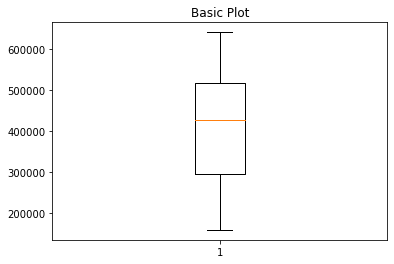

In [16]:
## TODO Need to complete the analysis
print(dfm['2021':]['MeanValue'].mean())

fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(dfm['2021':]['MeanValue'])

In [17]:
# plug the optimal parameter values into a new SARIMAX model.

for name, pdq, pdqs, df in zip(best_parameter['name'], best_parameter['pdq'], best_parameter['pdqs'], county_dfs):
    
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    output = ARIMA_MODEL.fit()
    print('SARIMA Model Result for {}'.format(name))
    print(output.summary().tables[1])
                           
                           
# Fit the model and print results

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.94747D+00    |proj g|=  1.93868D-01

At iterate    5    f=  7.90316D+00    |proj g|=  4.57387D-02

At iterate   10    f=  7.90307D+00    |proj g|=  2.03891D-04

At iterate   15    f=  7.90306D+00    |proj g|=  1.22891D-03

At iterate   20    f=  7.90297D+00    |proj g|=  1.70119D-02

At iterate   25    f=  7.88316D+00    |proj g|=  7.88999D-02

At iterate   30    f=  7.88106D+00    |proj g|=  5.60490D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.63306D+00    |proj g|=  4.33096D-02

At iterate   10    f=  7.63030D+00    |proj g|=  3.43314D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   1.424D-04   7.630D+00
  F =   7.6302967977782332     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA Model Result for Bergen County
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8379      0.049     17.111      0.000       0.742       0.934
ma.L1          0.0676   

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02822D+00    |proj g|=  5.34154D-01

At iterate    5    f=  7.93399D+00    |proj g|=  4.57795D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   1.525D-04   7.934D+00
  F =   7.9339707892830980     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA Model Result for Burlington County
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


At iterate   10    f=  8.45523D+00    |proj g|=  2.15456D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   6.467D-05   8.455D+00
  F =   8.4552208960414053     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA Model Result for Camden County
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7722      0.073     10.567      0.000       0.629       0.915
ma.L1         -0.1825      0.094     -1.934      0.053      -0.367       0.002
ar.S.L12

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.86543D+00    |proj g|=  3.66114D-04

At iterate   10    f=  7.86510D+00    |proj g|=  4.07097D-02

At iterate   15    f=  7.84444D+00    |proj g|=  2.31249D-01

At iterate   20    f=  7.83731D+00    |proj g|=  1.26231D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     26      1     0     0   1.262D-05   7.837D+00
  F =   7.8373092441552528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA Model Result for Cape May County
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  7.61046D+00    |proj g|=  1.87763D-04

At iterate   15    f=  7.61045D+00    |proj g|=  4.86511D-03

At iterate   20    f=  7.60835D+00    |proj g|=  6.22124D-02

At iterate   25    f=  7.59097D+00    |proj g|=  1.65363D-02

At iterate   30    f=  7.59090D+00    |proj g|=  1.55765D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     35      1     0     0   1.558D-05   7.591D+00
  F =   7.5908986188576302     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA Model Result for Cumberland County
                 coef    std err          z      P>|z|      [0.025     

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.97640D+00    |proj g|=  2.99191D-03

At iterate   10    f=  7.97638D+00    |proj g|=  4.48700D-03

At iterate   15    f=  7.97519D+00    |proj g|=  6.59970D-02

At iterate   20    f=  7.94982D+00    |proj g|=  1.53388D-01

At iterate   25    f=  7.94722D+00    |proj g|=  2.25121D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   2.251D-05   7.947D+00
  F =   7.9472197077704747     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA Model Result for Essex County
                 coef    std err          z      P>|z|      [0.025      0.97

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.29562D+00    |proj g|=  3.96329D-02

At iterate   10    f=  7.29444D+00    |proj g|=  1.76437D-04

At iterate   15    f=  7.29444D+00    |proj g|=  1.62379D-03

At iterate   20    f=  7.29407D+00    |proj g|=  2.08746D-02

At iterate   25    f=  7.28731D+00    |proj g|=  6.47484D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     34      1     0     0   1.065D-05   7.287D+00
  F =   7.2872753462820850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA Model Result for Gloucester County
                 coef    std err          z      P>|z|      [0.025     

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.69602D+00    |proj g|=  4.85344D-01

At iterate    5    f=  7.57400D+00    |proj g|=  1.01259D-01

At iterate   10    f=  7.57151D+00    |proj g|=  1.74044D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   1.740D-04   7.572D+00
  F =   7.5715081925689267     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA Model Result for Hudson County
                 coef    std err

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.84095D+00    |proj g|=  3.99296D-02

At iterate   10    f=  7.84084D+00    |proj g|=  1.33931D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   2.700D-04   7.841D+00
  F =   7.8408446696271730     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA Model Result for Hunterdon County
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8394      0.059     14.281      0.000       0.724       0.955
ma.L1          0.0488

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.31048D+00    |proj g|=  3.63602D-02

At iterate   10    f=  7.30911D+00    |proj g|=  2.73365D-04

At iterate   15    f=  7.30911D+00    |proj g|=  1.94848D-03

At iterate   20    f=  7.30871D+00    |proj g|=  2.47139D-02

At iterate   25    f=  7.29925D+00    |proj g|=  1.57599D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     33      1     0     0   1.824D-04   7.296D+00
  F =   7.2960701935591903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA Model Result for Mercer County
                 coef    std err          z      P>|z|      [0.025      0.9

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.57444D+00    |proj g|=  8.31412D-02

At iterate   10    f=  7.57337D+00    |proj g|=  3.15944D-04

At iterate   15    f=  7.57336D+00    |proj g|=  3.30770D-03

At iterate   20    f=  7.57305D+00    |proj g|=  3.96847D-02

At iterate   25    f=  7.55411D+00    |proj g|=  1.81029D-01

At iterate   30    f=  7.54480D+00    |proj g|=  3.41501D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     37      1     0     0   4.343D-06   7.545D+00
  F =   7.5447872592530656     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA Model Result for Middlesex County
          

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  7.91257D+00    |proj g|=  6.16075D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   1.580D-04   7.913D+00
  F =   7.9125650301851351     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA Model Result for Monmouth County
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7813      0.059     13.240      0.000       0.666       0.897
ma.L1          0.1613      0.092      1.760      0.078      -0.018       0.341
ar.S.

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.33211D+00    |proj g|=  4.74294D-02

At iterate   10    f=  7.33145D+00    |proj g|=  2.29360D-04

At iterate   15    f=  7.33144D+00    |proj g|=  7.12039D-03

At iterate   20    f=  7.33046D+00    |proj g|=  8.11149D-02

At iterate   25    f=  7.31824D+00    |proj g|=  9.51673D-02

At iterate   30    f=  7.31661D+00    |proj g|=  2.00788D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     36      1     0     0   2.008D-05   7.317D+00
  F =   7.3166120192210826     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA Model Result for Morris County
             

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  7.56102D+00    |proj g|=  2.22430D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   1.162D-04   7.561D+00
  F =   7.5605465405227701     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA Model Result for Ocean County
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8418      0.042     19.976      0.000       0.759       0.924
ma.L1          0.1197      0.080      1.487      0.137      -0.038       0.277
ar.S.L12

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.



At iterate    5    f=  7.64206D+00    |proj g|=  1.47974D-02

At iterate   10    f=  7.64195D+00    |proj g|=  1.65037D-04

At iterate   15    f=  7.64193D+00    |proj g|=  4.70202D-03

At iterate   20    f=  7.63996D+00    |proj g|=  5.17026D-02

At iterate   25    f=  7.62722D+00    |proj g|=  1.84714D-02

At iterate   30    f=  7.62678D+00    |proj g|=  9.26343D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     32      1     0     0   9.263D-06   7.627D+00
  F =   7.6267782556156805     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA Model Result for Passaic County
            

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.90366D+00    |proj g|=  4.87036D-01

At iterate    5    f=  7.86446D+00    |proj g|=  4.17481D-03

At iterate   10    f=  7.86444D+00    |proj g|=  1.30037D-04

At iterate   15    f=  7.86444D+00    |proj g|=  2.17789D-03

At iterate   20    f=  7.86428D+00    |proj g|=  2.66477D-02

At iterate   25    f=  7.85547D+00    |proj g|=  1.07359D-01

At iterate   30    f=  7.85255D+00    |proj g|=  2.43380D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate    5    f=  8.01757D+00    |proj g|=  5.83822D-02

At iterate   10    f=  8.01681D+00    |proj g|=  1.18235D-04

At iterate   15    f=  8.01679D+00    |proj g|=  3.50779D-03

At iterate   20    f=  8.01540D+00    |proj g|=  3.62868D-02

At iterate   25    f=  7.99796D+00    |proj g|=  2.55634D-02

At iterate   30    f=  7.99783D+00    |proj g|=  1.36962D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     36      1     0     0   1.370D-05   7.998D+00
  F =   7.9978336748657979     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA Model Result for Somerset County
           

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   15    f=  7.74853D+00    |proj g|=  1.65853D-03

At iterate   20    f=  7.74829D+00    |proj g|=  2.46879D-02

At iterate   25    f=  7.72109D+00    |proj g|=  2.02348D-01

At iterate   30    f=  7.70063D+00    |proj g|=  5.30803D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     36      1     0     0   1.070D-06   7.701D+00
  F =   7.7006181343252020     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA Model Result for Sussex County
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  8.05649D+00    |proj g|=  1.34590D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   1.346D-04   8.056D+00
  F =   8.0564873988801775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
SARIMA Model Result for Union County
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8530      0.047     18.318      0.000       0.762       0.944
ma.L1          0.0806      0.095      0.848      0.397      -0.106       0.267
ar.S.L12

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.



At iterate   10    f=  8.12615D+00    |proj g|=  9.43132D-05

At iterate   15    f=  8.12615D+00    |proj g|=  3.10003D-03

At iterate   20    f=  8.12532D+00    |proj g|=  2.68100D-02

At iterate   25    f=  8.11169D+00    |proj g|=  2.83213D-02

At iterate   30    f=  8.11066D+00    |proj g|=  1.89958D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     35      1     0     0   1.677D-06   8.111D+00
  F =   8.1106566517039145     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA Model Result for Warren County
                 coef    std err          z      P>|z|      [0.025      0.9

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.94747D+00    |proj g|=  1.93868D-01

At iterate    5    f=  7.90316D+00    |proj g|=  4.57387D-02

At iterate   10    f=  7.90307D+00    |proj g|=  2.03891D-04

At iterate   15    f=  7.90306D+00    |proj g|=  1.22891D-03

At iterate   20    f=  7.90297D+00    |proj g|=  1.70119D-02

At iterate   25    f=  7.88316D+00    |proj g|=  7.88999D-02

At iterate   30    f=  7.88106D+00    |proj g|=  5.60490D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


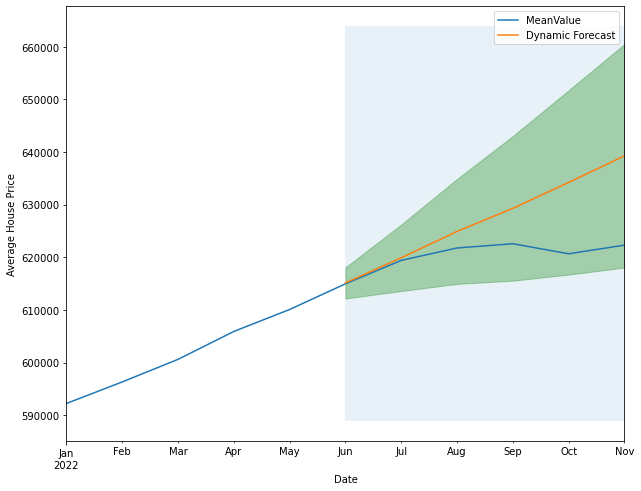

The Mean Squared Error of our forecasts is 9372.02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70605D+00    |proj g|=  3.80994D-01

At iterate    5    f=  7.63306D+00    |proj g|=  4.33096D-02

At iterate   10    f=  7.63030D+00    |proj g|=  3.43314D-04


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   1.424D-04   7.630D+00
  F =   7.6302967977782332     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


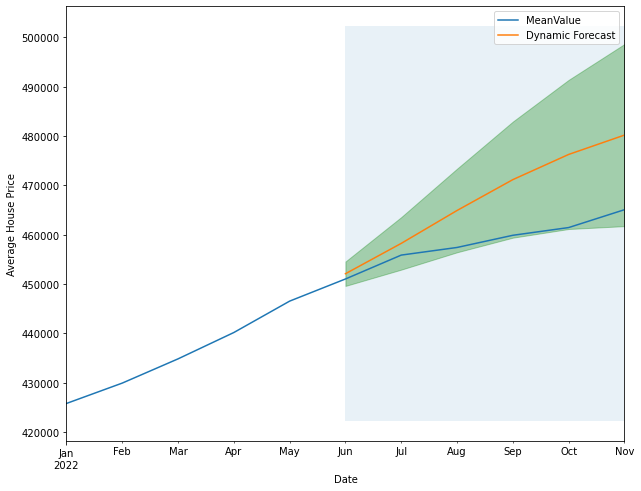

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


The Mean Squared Error of our forecasts is 10310.67
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02822D+00    |proj g|=  5.34154D-01

At iterate    5    f=  7.93399D+00    |proj g|=  4.57795D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   1.525D-04   7.934D+00
  F =   7.9339707892830980     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


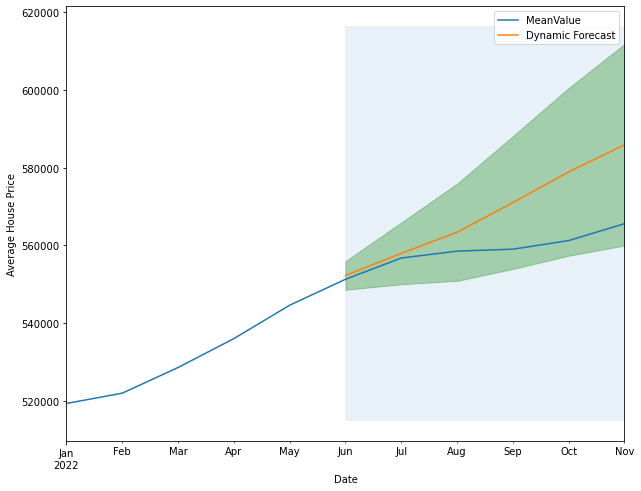

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


The Mean Squared Error of our forecasts is 12200.21
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.55408D+00    |proj g|=  8.89204D-01

At iterate    5    f=  8.46271D+00    |proj g|=  8.12953D-02

At iterate   10    f=  8.45523D+00    |proj g|=  2.15456D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   6.467D-05   8.455D+00
  F =   8.4552208960414053     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


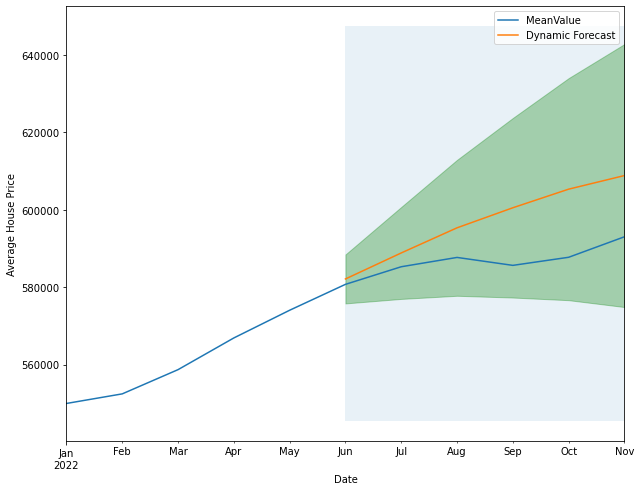

The Mean Squared Error of our forecasts is 11940.9
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.92671D+00    |proj g|=  2.97227D-01

At iterate    5    f=  7.86543D+00    |proj g|=  3.66114D-04

At iterate   10    f=  7.86510D+00    |proj g|=  4.07097D-02


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   15    f=  7.84444D+00    |proj g|=  2.31249D-01

At iterate   20    f=  7.83731D+00    |proj g|=  1.26231D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     26      1     0     0   1.262D-05   7.837D+00
  F =   7.8373092441552528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


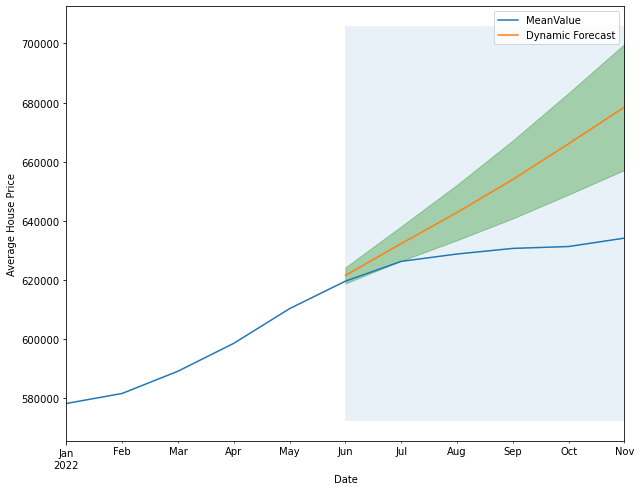

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


The Mean Squared Error of our forecasts is 25658.03
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88051D+00    |proj g|=  7.31078D-01

At iterate    5    f=  7.61048D+00    |proj g|=  5.15481D-03


 This problem is unconstrained.



At iterate   10    f=  7.61046D+00    |proj g|=  1.87763D-04

At iterate   15    f=  7.61045D+00    |proj g|=  4.86511D-03

At iterate   20    f=  7.60835D+00    |proj g|=  6.22124D-02

At iterate   25    f=  7.59097D+00    |proj g|=  1.65363D-02

At iterate   30    f=  7.59090D+00    |proj g|=  1.55765D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     35      1     0     0   1.558D-05   7.591D+00
  F =   7.5908986188576302     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


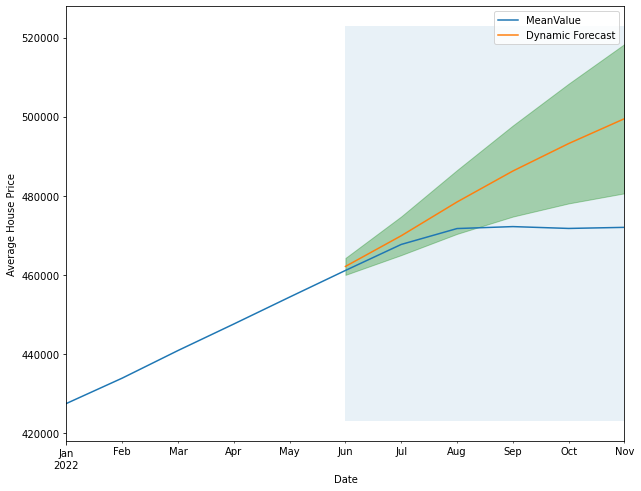

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


The Mean Squared Error of our forecasts is 15631.62
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.01361D+00    |proj g|=  1.39409D-01

At iterate    5    f=  7.97640D+00    |proj g|=  2.99191D-03


 This problem is unconstrained.



At iterate   10    f=  7.97638D+00    |proj g|=  4.48700D-03

At iterate   15    f=  7.97519D+00    |proj g|=  6.59970D-02

At iterate   20    f=  7.94982D+00    |proj g|=  1.53388D-01

At iterate   25    f=  7.94722D+00    |proj g|=  2.25121D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   2.251D-05   7.947D+00
  F =   7.9472197077704747     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


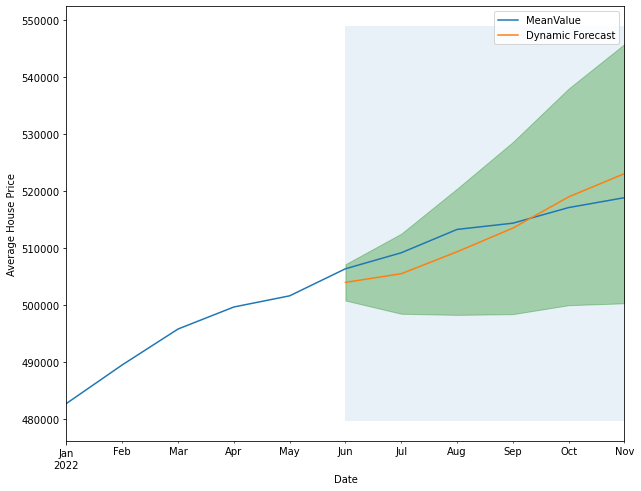

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


The Mean Squared Error of our forecasts is 3066.63
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35140D+00    |proj g|=  2.95483D-01

At iterate    5    f=  7.29562D+00    |proj g|=  3.96329D-02

At iterate   10    f=  7.29444D+00    |proj g|=  1.76437D-04

At iterate   15    f=  7.29444D+00    |proj g|=  1.62379D-03

At iterate   20    f=  7.29407D+00    |proj g|=  2.08746D-02

At iterate   25    f=  7.28731D+00    |proj g|=  6.47484D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


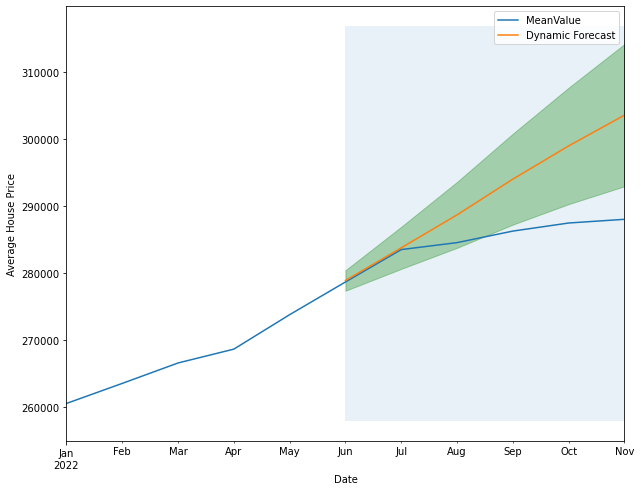

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


The Mean Squared Error of our forecasts is 8666.25
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.69602D+00    |proj g|=  4.85344D-01

At iterate    5    f=  7.57400D+00    |proj g|=  1.01259D-01

At iterate   10    f=  7.57151D+00    |proj g|=  1.74044D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   1.740D-04   7.572D+00
  F =   7.5715081925689267     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


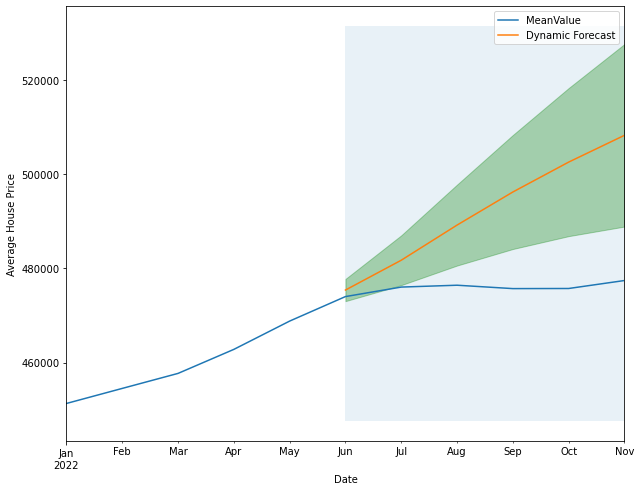

The Mean Squared Error of our forecasts is 19515.92
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.87258D+00    |proj g|=  1.88861D-01

At iterate    5    f=  7.84095D+00    |proj g|=  3.99296D-02


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  7.84084D+00    |proj g|=  1.33931D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   2.700D-04   7.841D+00
  F =   7.8408446696271730     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


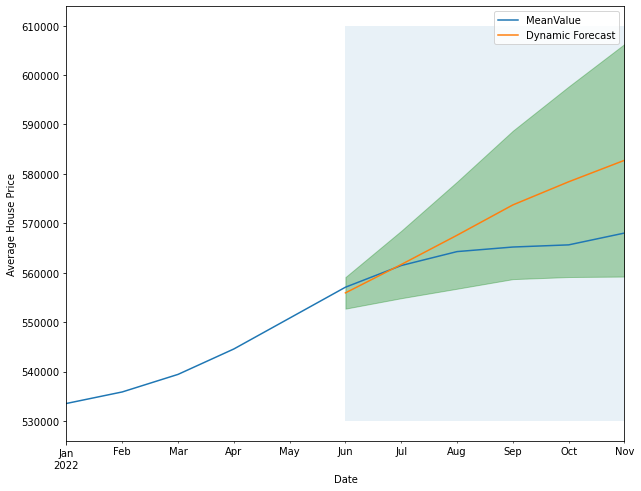

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


The Mean Squared Error of our forecasts is 8797.71
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.47673D+00    |proj g|=  4.82285D-01

At iterate    5    f=  7.31048D+00    |proj g|=  3.63602D-02


 This problem is unconstrained.



At iterate   10    f=  7.30911D+00    |proj g|=  2.73365D-04

At iterate   15    f=  7.30911D+00    |proj g|=  1.94848D-03

At iterate   20    f=  7.30871D+00    |proj g|=  2.47139D-02

At iterate   25    f=  7.29925D+00    |proj g|=  1.57599D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     33      1     0     0   1.824D-04   7.296D+00
  F =   7.2960701935591903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


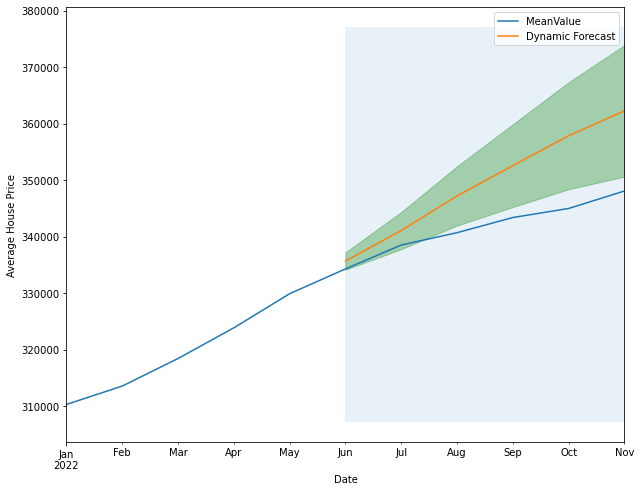

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


The Mean Squared Error of our forecasts is 9142.4
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62615D+00    |proj g|=  3.24122D-01

At iterate    5    f=  7.57444D+00    |proj g|=  8.31412D-02

At iterate   10    f=  7.57337D+00    |proj g|=  3.15944D-04


 This problem is unconstrained.



At iterate   15    f=  7.57336D+00    |proj g|=  3.30770D-03

At iterate   20    f=  7.57305D+00    |proj g|=  3.96847D-02

At iterate   25    f=  7.55411D+00    |proj g|=  1.81029D-01

At iterate   30    f=  7.54480D+00    |proj g|=  3.41501D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     37      1     0     0   4.343D-06   7.545D+00
  F =   7.5447872592530656     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


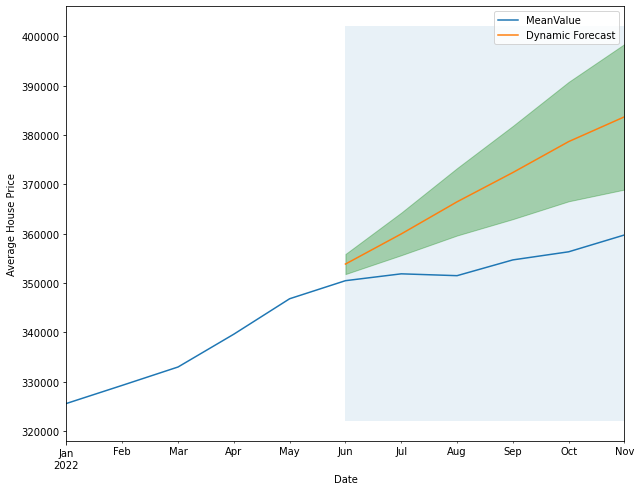

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


The Mean Squared Error of our forecasts is 16772.25
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.01589D+00    |proj g|=  1.01412D+00

At iterate    5    f=  7.91329D+00    |proj g|=  3.72458D-02

At iterate   10    f=  7.91257D+00    |proj g|=  6.16075D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   1.580D-04   7.913D+00
  F =   7.9125650301851351     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


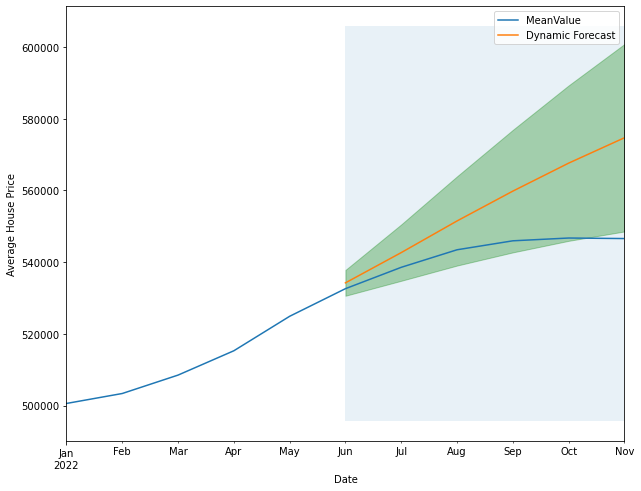

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


The Mean Squared Error of our forecasts is 15822.9
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.37238D+00    |proj g|=  2.13474D-01

At iterate    5    f=  7.33211D+00    |proj g|=  4.74294D-02

At iterate   10    f=  7.33145D+00    |proj g|=  2.29360D-04

At iterate   15    f=  7.33144D+00    |proj g|=  7.12039D-03

At iterate   20    f=  7.33046D+00    |proj g|=  8.11149D-02

At iterate   25    f=  7.31824D+00    |proj g|=  9.51673D-02

At iterate   30    f=  7.31661D+00    |proj g|=  2.00788D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

    

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


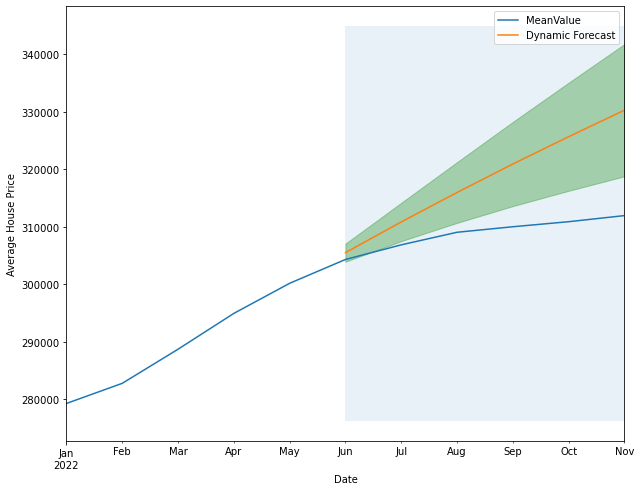

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


The Mean Squared Error of our forecasts is 11084.61
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.63063D+00    |proj g|=  2.59993D-01

At iterate    5    f=  7.56102D+00    |proj g|=  2.22430D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   1.162D-04   7.561D+00
  F =   7.5605465405227701     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


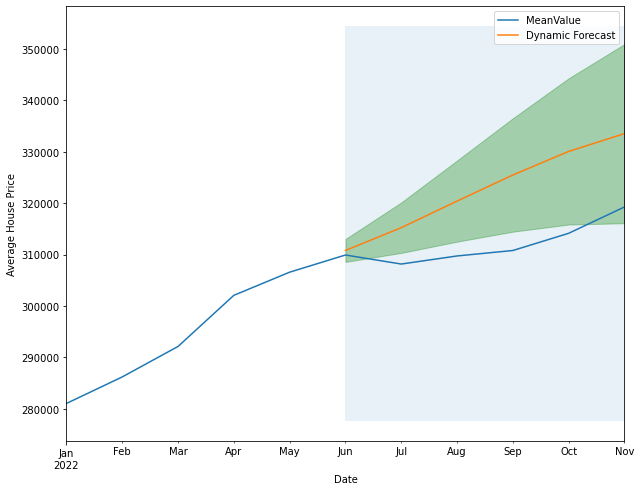

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


The Mean Squared Error of our forecasts is 11818.45
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.65107D+00    |proj g|=  8.57074D-02

At iterate    5    f=  7.64206D+00    |proj g|=  1.47974D-02

At iterate   10    f=  7.64195D+00    |proj g|=  1.65037D-04

At iterate   15    f=  7.64193D+00    |proj g|=  4.70202D-03

At iterate   20    f=  7.63996D+00    |proj g|=  5.17026D-02

At iterate   25    f=  7.62722D+00    |proj g|=  1.84714D-02

At iterate   30    f=  7.62678D+00    |proj g|=  9.26343D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

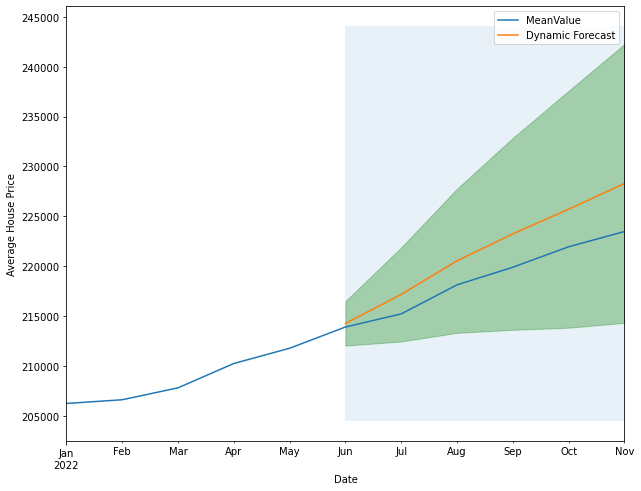

The Mean Squared Error of our forecasts is 3117.28
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.90366D+00    |proj g|=  4.87036D-01

At iterate    5    f=  7.86446D+00    |proj g|=  4.17481D-03


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   10    f=  7.86444D+00    |proj g|=  1.30037D-04

At iterate   15    f=  7.86444D+00    |proj g|=  2.17789D-03

At iterate   20    f=  7.86428D+00    |proj g|=  2.66477D-02

At iterate   25    f=  7.85547D+00    |proj g|=  1.07359D-01

At iterate   30    f=  7.85255D+00    |proj g|=  2.43380D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     39      1     0     0   3.691D-07   7.853D+00
  F =   7.8525494815537638     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


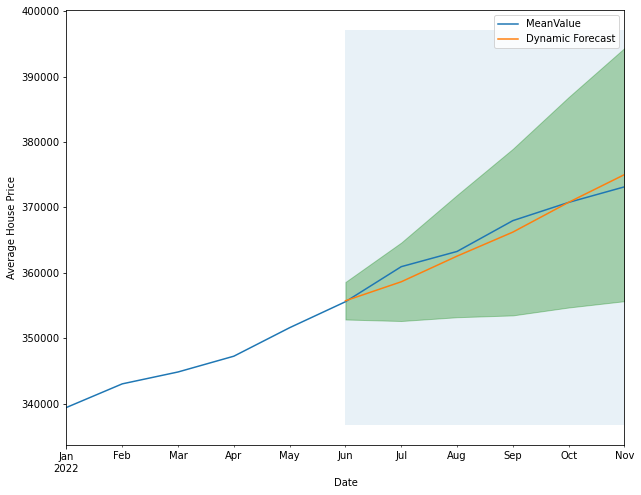

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


The Mean Squared Error of our forecasts is 1439.35
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04185D+00    |proj g|=  3.20143D-01

At iterate    5    f=  8.01757D+00    |proj g|=  5.83822D-02

At iterate   10    f=  8.01681D+00    |proj g|=  1.18235D-04

At iterate   15    f=  8.01679D+00    |proj g|=  3.50779D-03

At iterate   20    f=  8.01540D+00    |proj g|=  3.62868D-02

At iterate   25    f=  7.99796D+00    |proj g|=  2.55634D-02

At iterate   30    f=  7.99783D+00    |proj g|=  1.36962D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

    

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


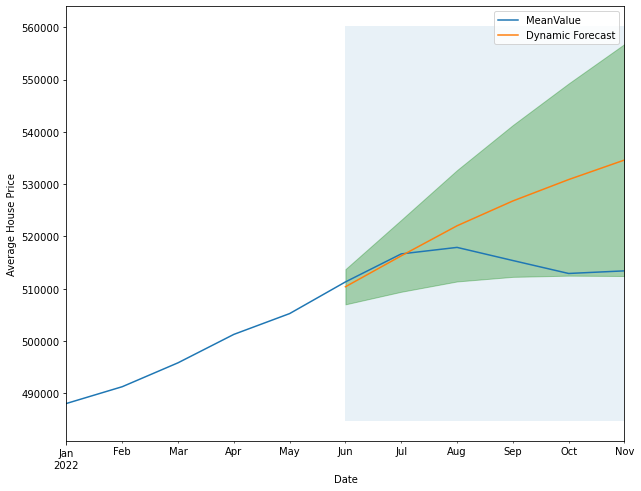

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


The Mean Squared Error of our forecasts is 12371.83
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.90080D+00    |proj g|=  1.31198D+00

At iterate    5    f=  7.75661D+00    |proj g|=  9.86754D-02

At iterate   10    f=  7.74853D+00    |proj g|=  4.10133D-04


 This problem is unconstrained.



At iterate   15    f=  7.74853D+00    |proj g|=  1.65853D-03

At iterate   20    f=  7.74829D+00    |proj g|=  2.46879D-02

At iterate   25    f=  7.72109D+00    |proj g|=  2.02348D-01

At iterate   30    f=  7.70063D+00    |proj g|=  5.30803D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     36      1     0     0   1.070D-06   7.701D+00
  F =   7.7006181343252020     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


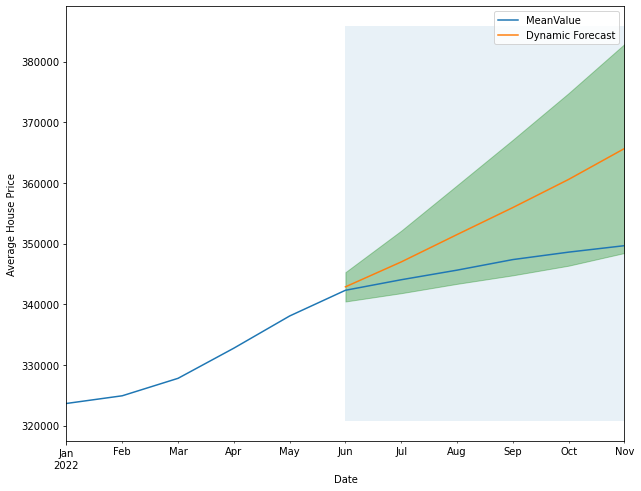

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


The Mean Squared Error of our forecasts is 9281.57
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07490D+00    |proj g|=  1.38161D-01

At iterate    5    f=  8.05649D+00    |proj g|=  2.90166D-03

At iterate   10    f=  8.05649D+00    |proj g|=  1.34590D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   1.346D-04   8.056D+00
  F =   8.0564873988801775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


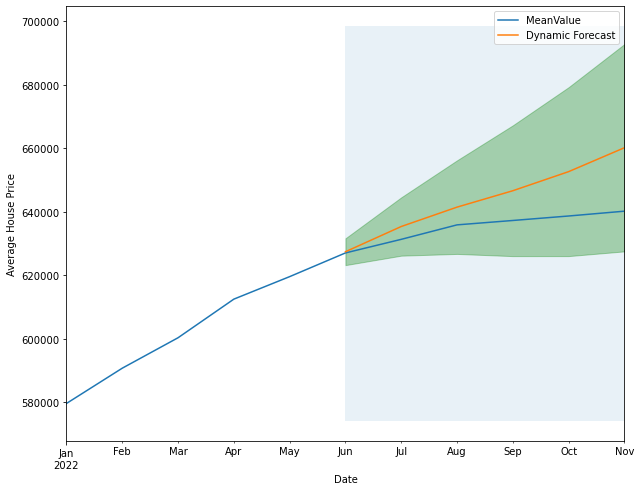

The Mean Squared Error of our forecasts is 11027.95
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15662D+00    |proj g|=  3.69787D-01

At iterate    5    f=  8.12671D+00    |proj g|=  2.08743D-02

At iterate   10    f=  8.12615D+00    |proj g|=  9.43132D-05


/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.



At iterate   15    f=  8.12615D+00    |proj g|=  3.10003D-03

At iterate   20    f=  8.12532D+00    |proj g|=  2.68100D-02

At iterate   25    f=  8.11169D+00    |proj g|=  2.83213D-02

At iterate   30    f=  8.11066D+00    |proj g|=  1.89958D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     35      1     0     0   1.677D-06   8.111D+00
  F =   8.1106566517039145     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


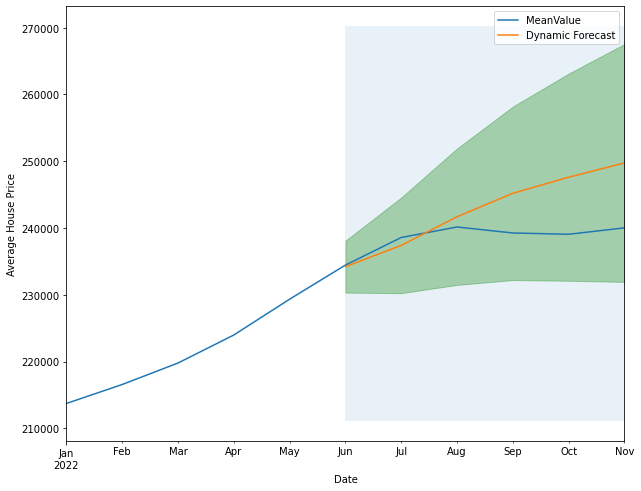

The Mean Squared Error of our forecasts is 5868.99


In [18]:
#Make Prediction post 2022 and compare with real values
summary = pd.DataFrame()
county = []
mse = []
models = []
for name, pdq, pdqs, df in zip(best_parameter['name'], best_parameter['pdq'], best_parameter['pdqs'], county_dfs):

    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False)
                                
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2022-06-30
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2022-06-30'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    county_predicted = pred_dynamic.predicted_mean
    county_actual = df['2022-06-30':]['MeanValue']
    
    #Plot the dynamic forecast with confidence intervals as above
    ax = df['2022':].plot(label='observed', figsize=(10, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2022-06-30'), county_predicted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Average House Price')

    plt.legend()
    plt.show()

    ##print(type(county_predicted))
    ##print(county_actual)
    sqrt_mse = np.sqrt(((county_predicted - county_actual)**2).mean())
    print('The Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse, 2))) 
    
    county.append(name)
    mse.append(sqrt_mse)
    
summary['County'] = county
summary['Sqrt_MSE'] = mse

In [15]:
summary

County      Sqrt_MSE
0     Atlantic County   9372.017216
1       Bergen County  10310.674222
2   Burlington County  12200.212958
3       Camden County  11940.898071
4     Cape May County  25658.031677
5   Cumberland County  15631.616939
6        Essex County   3066.634473
7   Gloucester County   8666.254671
8       Hudson County  19515.924784
9    Hunterdon County   8797.713752
10      Mercer County   9142.401576
11   Middlesex County  16772.253120
12    Monmouth County  15822.901074
13      Morris County  11084.606797
14       Ocean County  11818.449875
15     Passaic County   3117.282044
16       Salem County   1439.347281
17    Somerset County  12371.827175
18      Sussex County   9281.568901
19       Union County  11027.945333
20      Warren County   5868.991999

In [19]:
#Final Model 
forecast = pd.DataFrame()
current = []
forecast_3Yr = []
forecast_5Yr =[]
conf_3Yr_L=[]
conf_3Yr_U=[]
conf_5Yr_L=[]
conf_5Yr_U=[]
for cnty, output, df in zip(county, models, county_dfs):
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    current.append(df['2022-11']['MeanValue'][0])
    
    forecast_3Yr.append(forecast_3)
    conf_3Yr_L.append((pred_conf_3.iloc[:, 0]).iloc[-1])
    conf_3Yr_U.append((pred_conf_3.iloc[:, 1]).iloc[-1])
    forecast_5Yr.append(forecast_5)
    conf_5Yr_L.append((pred_conf_5.iloc[:, 0]).iloc[-1])
    conf_5Yr_U.append((pred_conf_5.iloc[:, 1]).iloc[-1])

    
    
forecast['County'] = county
forecast['Current Value'] = current
forecast['3 Years Value'] = forecast_3Yr
forecast['5 Years Value'] = forecast_5Yr
forecast['3 Years Lower'] = conf_3Yr_L
forecast['3 Years Upper'] = conf_3Yr_U
forecast['5 Years Lower'] = conf_5Yr_L
forecast['5 Years Upper'] = conf_5Yr_U

forecast['3Yr-ROI']=((forecast['3 Years Value'] - forecast['Current Value'])/forecast['Current Value']).map('{:,.2f}'.format)
forecast['5Yr-ROI']=((forecast['5 Years Value'] - forecast['Current Value'])/forecast['Current Value']).map('{:,.2f}'.format)
forecast['3Yr-ROI-Lower']=((forecast['3 Years Lower'] - forecast['Current Value'])/forecast['Current Value']).map('{:,.2f}'.format)
forecast['3Yr-ROI-Upper']=((forecast['3 Years Upper'] - forecast['Current Value'])/forecast['Current Value']).map('{:,.2f}'.format)
forecast['5Yr-ROI-Lower']=((forecast['5 Years Lower'] - forecast['Current Value'])/forecast['Current Value']).map('{:,.2f}'.format)
forecast['5Yr-ROI-Upper']=((forecast['5 Years Upper'] - forecast['Current Value'])/forecast['Current Value']).map('{:,.2f}'.format)


print(forecast)

/var/folders/55/nnkwdj2178z85z6pk884kg40mpppbj/T/ipykernel_57826/761162072.py:18: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  current.append(df['2022-11']['MeanValue'][0])
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


               County  Current Value  3 Years Value  5 Years Value  \
0     Atlantic County       622297.0  740289.840527   8.181675e+05   
1       Bergen County       465069.0  613872.007608   7.123119e+05   
2   Burlington County       565603.0  722274.489986   8.251252e+05   
3       Camden County       593026.0  728409.406636   8.190267e+05   
4     Cape May County       634207.0  768261.003945   8.561697e+05   
5   Cumberland County       471976.0  612128.152202   7.019519e+05   
6        Essex County       518810.0  647626.986618   7.331463e+05   
7   Gloucester County       288005.0  362911.294494   4.136294e+05   
8       Hudson County       477392.0  576167.782186   6.407707e+05   
9    Hunterdon County       568032.0  698407.109063   7.842407e+05   
10      Mercer County       348080.0  482976.176587   5.726799e+05   
11   Middlesex County       359738.0  496587.219942   5.864568e+05   
12    Monmouth County       546582.0  670797.868726   7.574804e+05   
13      Morris Count

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is ava

<AxesSubplot:ylabel='County'>

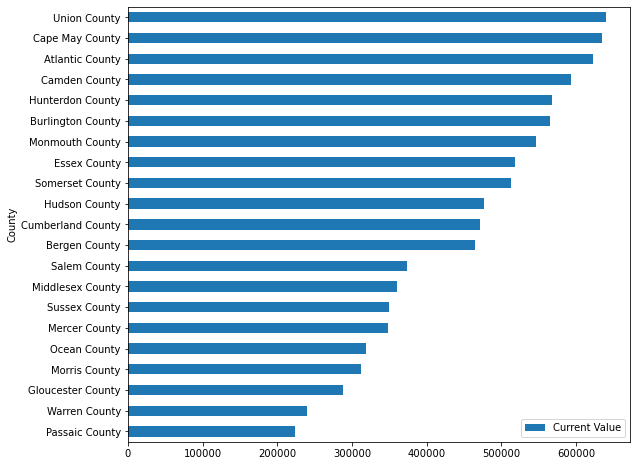

In [20]:
cur_df=forecast[['County','Current Value']].copy()
cur_df.set_index('County', inplace = True)
cur_df['Current Value'] = cur_df['Current Value'].astype(int)
cur_df = cur_df.sort_values('Current Value', ascending = True)
cur_df.plot.barh(figsize=(9,8))

<AxesSubplot:ylabel='County'>

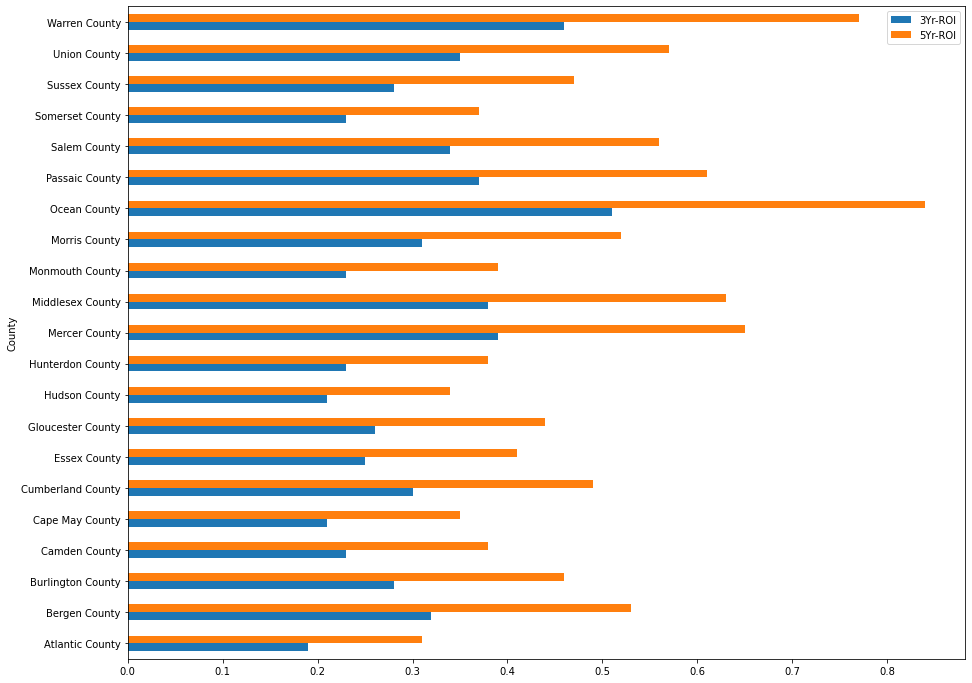

In [22]:
roi_df=forecast[['County','3Yr-ROI', '5Yr-ROI']].copy()
roi_df.set_index('County', inplace = True)
roi_df['3Yr-ROI'] = roi_df['3Yr-ROI'].astype(float)
roi_df['5Yr-ROI'] = roi_df['5Yr-ROI'].astype(float)

roi_df.plot.barh(figsize=(15,12))

<AxesSubplot:ylabel='County'>

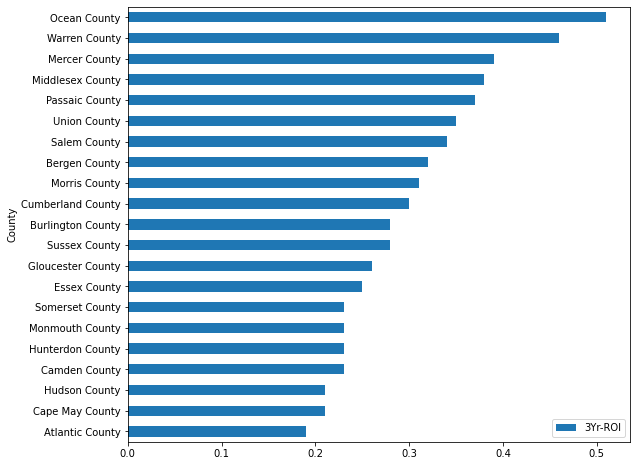

In [23]:
roi3_df=roi_df[['3Yr-ROI']].copy()
roi3_df = roi3_df.sort_values('3Yr-ROI', ascending = True)

roi3_df.plot.barh(figsize=(9,8))

<AxesSubplot:ylabel='County'>

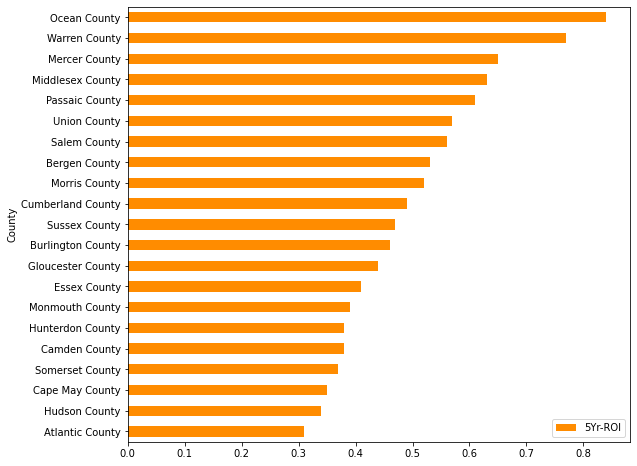

In [24]:
roi5_df=roi_df[['5Yr-ROI']].copy()
roi5_df = roi5_df.sort_values('5Yr-ROI', ascending = True)

roi5_df.plot.barh(figsize=(9,8), color={"5Yr-ROI": "DarkOrange"})

<AxesSubplot:ylabel='County'>

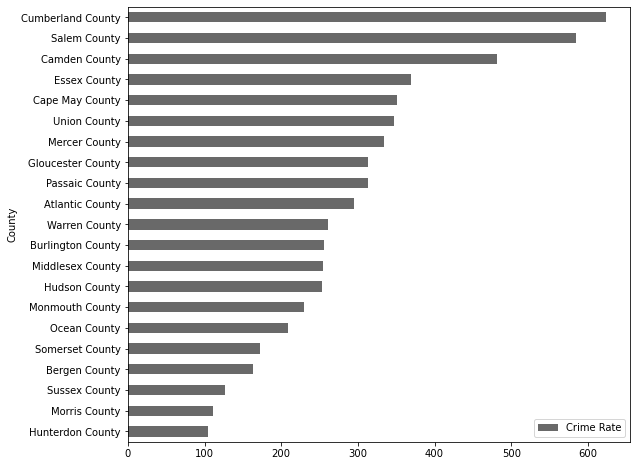

In [25]:

crime_df = pd.read_excel(r'Crime Rate.xlsx', sheet_name='Summary')
crime_df.set_index('County', inplace = True)
crime_df = crime_df.sort_values('Crime Rate', ascending = True)
crime_df.plot.barh(figsize=(9,8), color={"Crime Rate": "DimGray"})
                                

<AxesSubplot:ylabel='County'>

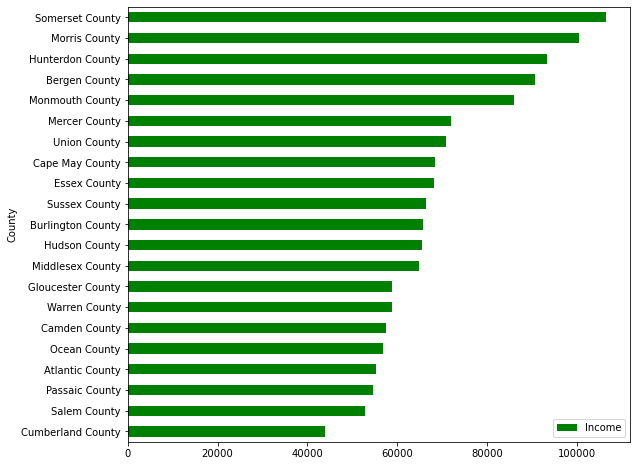

In [26]:
income_df = pd.read_excel(r'Income_Data.xlsx', sheet_name='Summary')
income_df.set_index('County', inplace = True)
income_df = income_df.sort_values('Income', ascending = True)
income_df.plot.barh(figsize=(9,8), color={"Income": "Green"})


<AxesSubplot:ylabel='County'>

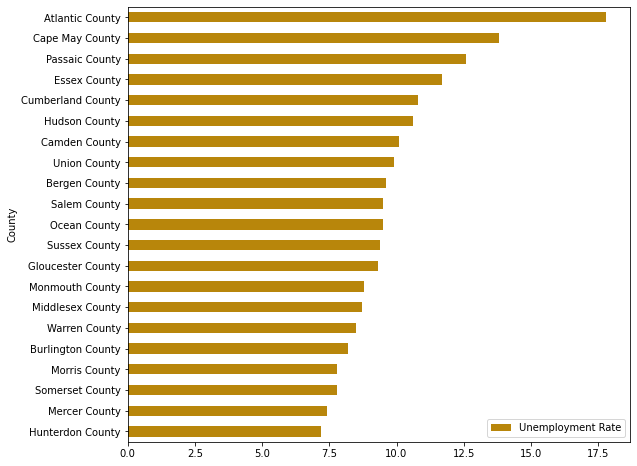

In [27]:
Unemployment_df = pd.read_excel(r'Unemployment_Data.xlsx', sheet_name='Summary')
Unemployment_df.set_index('County', inplace = True)
Unemployment_df = Unemployment_df.sort_values('Unemployment Rate', ascending = True)
Unemployment_df.plot.barh(figsize=(9,8), color={"Unemployment Rate": "DarkGoldenrod"})

<AxesSubplot:ylabel='County'>

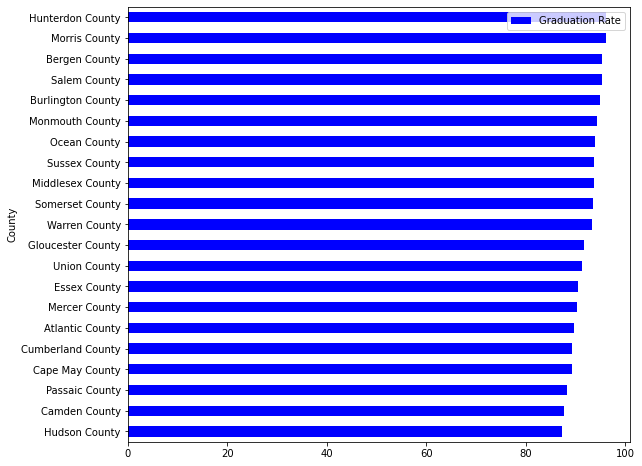

In [28]:
SchoolGraduationRate_df = pd.read_excel(r'SchoolGraduationRate.xlsx')
SchoolGraduationRate_df.set_index('County', inplace = True)
SchoolGraduationRate_df = SchoolGraduationRate_df.sort_values('Graduation Rate', ascending = True)
SchoolGraduationRate_df.plot.barh(figsize=(9,8), color={"Graduation Rate": "Blue"})

<AxesSubplot:ylabel='County'>

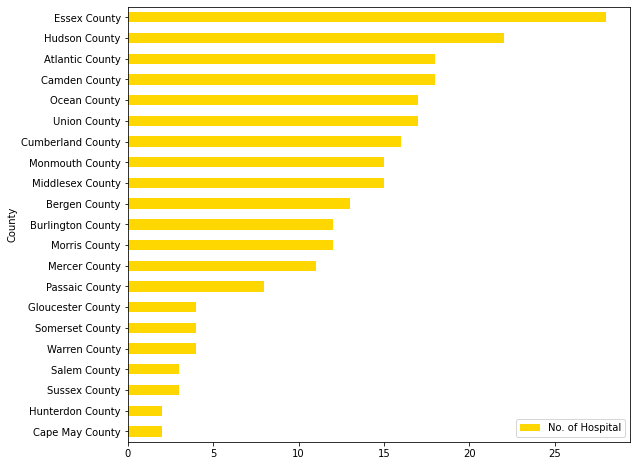

In [29]:
Hospital_df = pd.read_excel(r'Hospitals.xlsx')
Hospital_df.set_index('County', inplace = True)
Hospital_df = Hospital_df.sort_values('No. of Hospital', ascending = True)
Hospital_df.plot.barh(figsize=(9,8), color={"No. of Hospital": "Gold"})

In [30]:
comb_df = crime_df.copy()
comb_df = comb_df.join(income_df , on='County')
comb_df = comb_df.join(Unemployment_df , on='County')
comb_df = comb_df.join(SchoolGraduationRate_df , on='County')
comb_df = comb_df.join(Hospital_df , on='County')

comb_df.head()

Crime Rate  Income  Unemployment Rate  Graduation Rate  \
County                                                                     
Hunterdon County       105.2   93279                7.2        96.133333   
Morris County          110.7  100617                7.8        96.092000   
Sussex County          126.7   66431                9.4        93.655556   
Bergen County          163.4   90759                9.6        95.343750   
Somerset County        171.8  106558                7.8        93.566667   

                  No. of Hospital  
County                             
Hunterdon County                2  
Morris County                  12  
Sussex County                   3  
Bergen County                  13  
Somerset County                 4

In [31]:
medv = dfm['2020':'2020']
medv = pd.DataFrame(medv.groupby(["RegionName"])["MeanValue"].median())
medv.rename(columns={'MeanValue': 'MedianPrice'}, inplace=True)
medv.index.names = ['County']

medv.head()

MedianPrice
County                        
Atlantic County       209624.5
Bergen County         507058.0
Burlington County     244567.0
Camden County         195833.5
Cape May County       417091.5

In [32]:
comb_df = comb_df.join(medv , on='County')
comb_df.head()

Crime Rate  Income  Unemployment Rate  Graduation Rate  \
County                                                                     
Hunterdon County       105.2   93279                7.2        96.133333   
Morris County          110.7  100617                7.8        96.092000   
Sussex County          126.7   66431                9.4        93.655556   
Bergen County          163.4   90759                9.6        95.343750   
Somerset County        171.8  106558                7.8        93.566667   

                  No. of Hospital  MedianPrice  
County                                          
Hunterdon County                2     394491.5  
Morris County                  12     449321.0  
Sussex County                   3     262761.0  
Bergen County                  13     507058.0  
Somerset County                 4     420302.0

In [33]:
print(comb_df.shape)
print("------------------")
print(comb_df.dtypes)
print("------------------")
print(comb_df.nunique())
print("------------------")
print(comb_df.isnull().sum())

(21, 6)
------------------
Crime Rate           float64
Income                 int64
Unemployment Rate    float64
Graduation Rate      float64
No. of Hospital        int64
MedianPrice          float64
dtype: object
------------------
Crime Rate           21
Income               21
Unemployment Rate    19
Graduation Rate      21
No. of Hospital      13
MedianPrice          21
dtype: int64
------------------
Crime Rate           0
Income               0
Unemployment Rate    0
Graduation Rate      0
No. of Hospital      0
MedianPrice          0
dtype: int64


In [34]:
comb_df.describe()

Crime Rate         Income  Unemployment Rate  Graduation Rate  \
count   21.000000      21.000000          21.000000        21.000000   
mean   293.233333   69417.333333           9.952381        92.160673   
std    139.428678   16728.201999           2.452676         2.853231   
min    105.200000   43844.000000           7.200000        87.318182   
25%    209.300000   57483.000000           8.500000        89.590000   
50%    261.100000   65654.000000           9.500000        93.333333   
75%    347.300000   71990.000000          10.600000        94.328125   
max    623.700000  106558.000000          17.800000        96.133333   

       No. of Hospital    MedianPrice  
count        21.000000      21.000000  
mean         11.619048  329355.809524  
std           7.351709  114193.449061  
min           2.000000  146339.000000  
25%           4.000000  244567.000000  
50%          12.000000  352808.500000  
75%          17.000000  420302.000000  
max          28.000000  507058.000000

In [35]:
# Finding out the correlation between the features
corr = comb_df.corr()
corr.shape

(6, 6)

<AxesSubplot:>

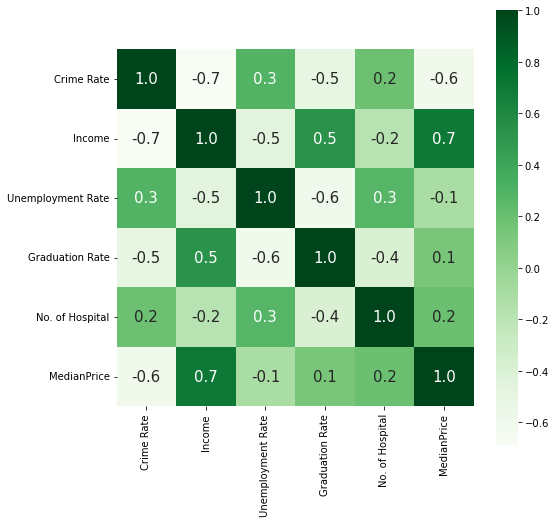

In [145]:
plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Greens')

In [36]:
# Spliting target variable and independent variables
x = comb_df.drop(['MedianPrice'], axis = 1)
y = comb_df['MedianPrice']

In [37]:
# Splitting to training and testing data

from sklearn.model_selection import train_test_split
x_train, x_test,y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 4)

In [39]:
# Import library for Linear Regression
from sklearn.linear_model import LinearRegression

# Create a Linear regressor
lm = LinearRegression()

# Train the model using the training sets 
lm.fit(x_train, y_train)

LinearRegression()

In [40]:
#Converting the coefficient values to a dataframe
coeffcients = pd.DataFrame([x_train.columns,lm.coef_]).T
coeffcients = coeffcients.rename(columns={0: 'Attribute', 1: 'Coefficients'})
coeffcients

Attribute  Coefficients
0         Crime Rate   -262.993378
1             Income      4.068048
2  Unemployment Rate  -3911.659411
3    Graduation Rate -22962.249812
4    No. of Hospital   4124.952704

In [41]:
# Model prediction on train data
y_pred = lm.predict(x_train)

In [42]:
from sklearn import metrics

# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.6005243999626726
Adjusted R^2: 0.350852149939343
MAE: 48247.54803735217
MSE: 3471429957.639339
RMSE: 58918.84212744968


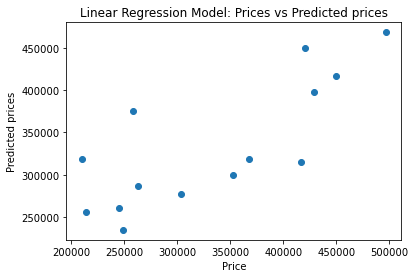

In [43]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Price")
plt.ylabel("Predicted prices")
plt.title("Linear Regression Model: Prices vs Predicted prices")
plt.show()

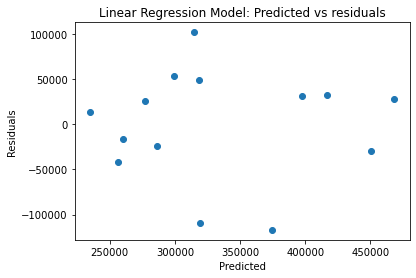

In [44]:
# Checking residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("Linear Regression Model: Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

/Users/nilanjana.chatterjee/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


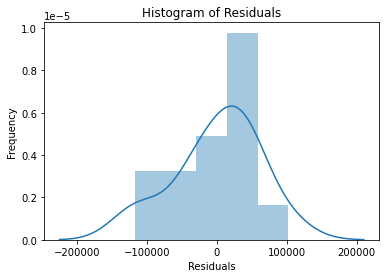

In [45]:
# Checking Normality of errors
sns.distplot(y_train-y_pred)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [46]:
# Predicting Test data with the model
y_test_pred = lm.predict(x_test)
# Model Evaluation
acc_linreg = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_linreg)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.5629765619848929
Adjusted R^2: -1.6221406280906425
MAE: 83847.84374889592
MSE: 8633553263.055128
RMSE: 92916.9159144616


In [47]:
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
reg = RandomForestRegressor()

# Train the model using the training sets 
reg.fit(x_train, y_train)

RandomForestRegressor()

In [48]:
# Model prediction on train data
y_pred = reg.predict(x_train)
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.8120963511632286
Adjusted R^2: 0.6946565706402466
MAE: 35289.82392857143
MSE: 1632876590.361863
RMSE: 40408.867719373964


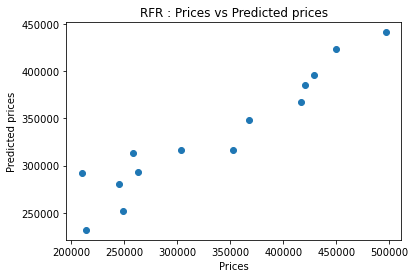

In [49]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("RFR : Prices vs Predicted prices")
plt.show()

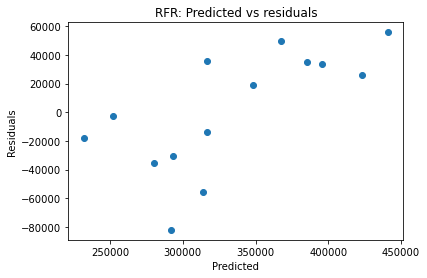

In [50]:
# Checking residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("RFR: Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

In [51]:
# Predicting Test data with the model
y_test_pred = reg.predict(x_test)
# Model Evaluation
acc_rf = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_rf)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.2992331704306903
Adjusted R^2: -3.2046009774158577
MAE: 100824.74285714285
MSE: 13843897653.51617
RMSE: 117660.09371709752


In [62]:
# Import XGBoost Regressor
from xgboost import XGBRegressor

#Create a XGBoost Regressor
xb = XGBRegressor()

# Train the model using the training sets 
xb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [63]:
# Model prediction on train data
y_pred = xb.predict(x_train)

# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))


R^2: 0.9999999999998415
Adjusted R^2: 0.9999999999997424
MAE: 0.030133928571428572
MSE: 0.0013776506696428572
RMSE: 0.0371167168489194


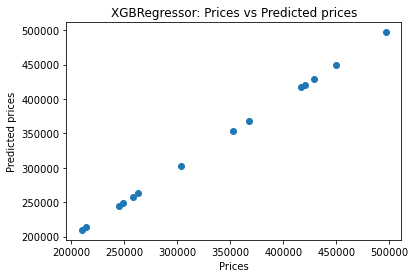

In [64]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("XGBRegressor: Prices vs Predicted prices")
plt.show()

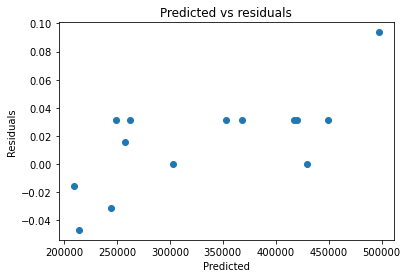

In [65]:
# Checking residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

In [66]:
#Predicting Test data with the model
y_test_pred = xb.predict(x_test)
# Model Evaluation
acc_xgb = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_xgb)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.24040408405305824
Adjusted R^2: -3.5575754956816503
MAE: 108738.52901785714
MSE: 15006087152.928328
RMSE: 122499.33531627152


In [70]:
# Creating scaled set to be used in model to improve our results
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

In [71]:
# Import SVM Regressor
from sklearn import svm

# Create a SVM Regressor
sc_reg = svm.SVR()
# Train the model using the training sets 
sc_reg.fit(x_train, y_train)
# Model prediction on train data
y_pred = sc_reg.predict(x_train)

In [72]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: -0.0040551777336947925
Adjusted R^2: -0.631589663817254
MAE: 85175.35370112685
MSE: 8725206803.073704
RMSE: 93408.8154462613


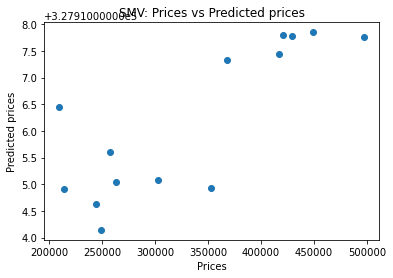

In [73]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("SMV: Prices vs Predicted prices")
plt.show()

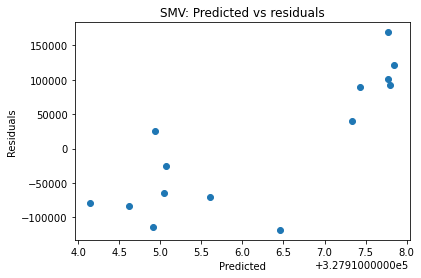

In [75]:
# Checking residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("SMV: Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

In [76]:
# Predicting Test data with the model
y_test_pred = sc_reg.predict(X_test)
# Model Evaluation
acc_svm = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_svm)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: -0.0029154290714399345
Adjusted R^2: -5.01749257442864
MAE: 132949.32419968848
MSE: 19812950569.778706
RMSE: 140758.4831183496


In [77]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'Support Vector Machines'],
    'R-squared Score': [acc_linreg*100, acc_rf*100, acc_xgb*100, acc_svm*100]})
models.sort_values(by='R-squared Score', ascending=False)

Model  R-squared Score
0        Linear Regression        56.297656
1            Random Forest        29.923317
2                  XGBoost        24.040408
3  Support Vector Machines        -0.291543